# Creating Numbers/images with AI: A Hands-on Diffusion Model Exercise

## Introduction
In this assignment, you'll learn how to create an AI model that can generate realistic images from scratch using a powerful technique called 'diffusion'. Think of it like teaching AI to draw by first learning how images get blurry and then learning to make them clear again.

### What We'll Build
- A diffusion model capable of generating realistic images
- For most students: An AI that generates handwritten digits (0-9) using the MNIST dataset
- For students with more computational resources: Options to work with more complex datasets
- Visual demonstrations of how random noise gradually transforms into clear, recognizable images
- By the end, your AI should create images realistic enough for another AI to recognize them

### Dataset Options
This lab offers flexibility based on your available computational resources:

- Standard Option (Free Colab): We'll primarily use the MNIST handwritten digit dataset, which works well with limited GPU memory and completes training in a reasonable time frame. Most examples and code in this notebook are optimized for MNIST.

- Advanced Option: If you have access to more powerful GPUs (either through Colab Pro/Pro+ or your own hardware), you can experiment with more complex datasets like Fashion-MNIST, CIFAR-10, or even face generation. You'll need to adapt the model architecture, hyperparameters, and evaluation metrics accordingly.

### Resource Requirements
- Basic MNIST: Works with free Colab GPUs (2-4GB VRAM), ~30 minutes training
- Fashion-MNIST: Similar requirements to MNIST
CIFAR-10: Requires more memory (8-12GB VRAM) and longer training (~2 hours)
- Higher resolution images: Requires substantial GPU resources and several hours of training

### Before You Start
1. Make sure you're running this in Google Colab or another environment with GPU access
2. Go to 'Runtime' → 'Change runtime type' and select 'GPU' as your hardware accelerator
3. Each code cell has comments explaining what it does
4. Don't worry if you don't understand every detail - focus on the big picture!
5. If working with larger datasets, monitor your GPU memory usage carefully

The concepts you learn with MNIST will scale to more complex datasets, so even if you're using the basic option, you'll gain valuable knowledge about generative AI that applies to more advanced applications.



## Step 1: Setting Up Our Tools
First, let's install and import all the tools we need. Run this cell and wait for it to complete.

In [ ]:
# Step 1: Install required packages
%pip install einops
print("Package installation complete.")

# Step 2: Import libraries
# --- Core PyTorch libraries ---
import torch  # Main deep learning framework
import torch.nn.functional as F  # Neural network functions like activation functions
import torch.nn as nn  # Neural network building blocks (layers)
from torch.optim import Adam  # Optimization algorithm for training
import torch.optim.lr_scheduler as lr_scheduler # Import scheduler explicitly

# --- Data handling ---
from torch.utils.data import Dataset, DataLoader, random_split  # For organizing and loading our data
import torchvision  # Library for computer vision datasets and models
import torchvision.transforms as transforms  # For preprocessing images

# --- Tensor manipulation ---
import random  # For random operations
from einops.layers.torch import Rearrange  # For reshaping tensors in neural networks
from einops import rearrange  # For elegant tensor reshaping operations
import numpy as np  # For numerical operations on arrays
import math # For cosine schedule calculation

# --- System utilities ---
import os  # For operating system interactions (used for CPU count)

# --- Visualization tools ---
import matplotlib.pyplot as plt  # For plotting images and graphs
from PIL import Image  # For image processing
from torchvision.utils import save_image, make_grid  # For saving and displaying image grids
from tqdm.notebook import tqdm # Import tqdm for progress bars

# Step 3: Set up device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"We'll be using: {device}")

# Check if we're actually using GPU (for students to verify)
if device.type == "cuda":
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("Note: Training will be much slower on CPU. Consider using Google Colab with GPU enabled.")

# Import traceback for detailed error printing later
import traceback
import gc

Package installation complete.
We'll be using: cuda
GPU name: NVIDIA A100-SXM4-40GB
GPU memory: 42.47 GB



###  REPRODUCIBILITY AND DEVICE SETUP

In [ ]:
# Step 4: Set random seeds for reproducibility
# Diffusion models are sensitive to initialization, so reproducible results help with debugging
SEED = 42  # Universal seed value for reproducibility
torch.manual_seed(SEED)          # PyTorch random number generator
np.random.seed(SEED)             # NumPy random number generator
random.seed(SEED)                # Python's built-in random number generator

print(f"Random seeds set to {SEED} for reproducible results")

# Configure CUDA for GPU operations if available
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)       # GPU random number generator
    torch.cuda.manual_seed_all(SEED)   # All GPUs random number generator

    # Ensure deterministic GPU operations
    # Note: This slightly reduces performance but ensures results are reproducible
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    try:
        # Check available GPU memory
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9  # Convert to GB
        print(f"Available GPU Memory: {gpu_memory:.1f} GB")

        # Add recommendation based on memory
        if gpu_memory < 4:
            print("Warning: Low GPU memory. Consider reducing batch size if you encounter OOM errors.")
    except Exception as e:
        print(f"Could not check GPU memory: {e}")
else:
    print("No GPU detected. Training will be much slower on CPU.")
    print("If you're using Colab, go to Runtime > Change runtime type and select GPU.")

Random seeds set to 42 for reproducible results
Available GPU Memory: 42.5 GB


## Step 2: Choosing Your Dataset

You have several options for this exercise, depending on your computer's capabilities:

### Option 1: MNIST (Basic - Works on Free Colab)
- Content: Handwritten digits (0-9)
- Image size: 28x28 pixels, Grayscale
- Training samples: 60,000
- Memory needed: ~2GB GPU
- Training time: ~15-30 minutes on Colab
- **Choose this if**: You're using free Colab or have a basic GPU

### Option 2: Fashion-MNIST (Intermediate)
- Content: Clothing items (shirts, shoes, etc.)
- Image size: 28x28 pixels, Grayscale
- Training samples: 60,000
- Memory needed: ~2GB GPU
- Training time: ~15-30 minutes on Colab
- **Choose this if**: You want more interesting images but have limited GPU

### Option 3: CIFAR-10 (Advanced)
- Content: Real-world objects (cars, animals, etc.)
- Image size: 32x32 pixels, Color (RGB)
- Training samples: 50,000
- Memory needed: ~4GB GPU
- Training time: ~1-2 hours on Colab
- **Choose this if**: You have Colab Pro or a good local GPU (8GB+ memory)

### Option 4: CelebA (Expert)
- Content: Celebrity face images
- Image size: 64x64 pixels, Color (RGB)
- Training samples: 200,000
- Memory needed: ~8GB GPU
- Training time: ~3-4 hours on Colab
- **Choose this if**: You have excellent GPU (12GB+ memory)

To use your chosen dataset, uncomment its section in the code below and make sure all others are commented out.

##BRUTE FORCE METHOD

In [ ]:
#-------------------------------------------
# OPTION 1: MNIST (Basic - 2GB GPU)
#-------------------------------------------
IMG_SIZE = 28
IMG_CH = 1
N_CLASSES = 10
BATCH_SIZE = 64
EPOCHS = 30

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST dataset
dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)
print("MNIST dataset loaded successfully. Samples:", len(dataset))

#===============================================================================
# VALIDATION AND DATALOADERS
#===============================================================================

# Validate GPU memory requirements
if torch.cuda.is_available():
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    required_memory = 2  # MNIST requires ~2GB
    if gpu_memory < required_memory:
        print(f"⚠️ Warning: Low GPU memory ({gpu_memory:.1f}GB). Consider reducing batch size.")
    else:
        print(f"✅ GPU memory sufficient ({gpu_memory:.1f}GB)")

# Check sample batch properties
sample_batch = next(iter(DataLoader(dataset, batch_size=1)))
print("\nDataset properties:")
print("Shape:", sample_batch[0].shape)
print("Type:", sample_batch[0].dtype)
print("Value range: [{:.2f}, {:.2f}]".format(
    sample_batch[0].min().item(),
    sample_batch[0].max().item()
))

# Create train-validation split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)

print(f"\nTrain samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")

# Create dataloaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count(),
    pin_memory=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=os.cpu_count(),
    pin_memory=True
)

print("\nData loaders created successfully:")
print("Train batches:", len(train_dataloader))
print("Validation batches:", len(val_dataloader))

100%|██████████| 9.91M/9.91M [00:00<00:00, 41.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.18MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.46MB/s]

MNIST dataset loaded successfully. Samples: 60000
✅ GPU memory sufficient (42.5GB)

Dataset properties:
Shape: torch.Size([1, 1, 28, 28])
Type: torch.float32
Value range: [-1.00, 1.00]

Train samples: 48000, Val samples: 12000

Data loaders created successfully:
Train batches: 750
Validation batches: 188


In [ ]:
# Complete GELUConvBlock implementation
class GELUConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, group_size):
        super().__init__()
        # Handle group normalization compatibility
        if out_ch % group_size != 0:
            group_size = out_ch // (out_ch // group_size)

        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.GroupNorm(group_size, out_ch),
            nn.GELU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.GroupNorm(group_size, out_ch),
            nn.GELU()
        )
        self.residual = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x):
        return self.block(x) + self.residual(x)

# Complete RearrangePoolBlock
class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        super().__init__()
        self.rearrange = Rearrange('b c (h p1) (w p2) -> b (c p1 p2) h w', p1=2, p2=2)
        self.conv = GELUConvBlock(in_chs*4, in_chs, group_size)

    def forward(self, x):
        x = self.rearrange(x)
        return self.conv(x)

# Complete UpBlock
class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(in_chs, in_chs//2, kernel_size=2, stride=2)
        self.conv = nn.Sequential(
            GELUConvBlock(in_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size)
        )

    def forward(self, x, skip):
        x = self.upsample(x)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

# Complete EmbedBlock
class EmbedBlock(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
            Rearrange('b c -> b c 1 1')
        )

    def forward(self, x):
        return self.model(x)

# Complete UNet implementation
class UNet(nn.Module):
    def __init__(self, T, img_ch, img_size, down_chs, t_embed_dim, c_embed_dim):
        super().__init__()
        # Time embedding
        self.time_embed = nn.Sequential(
            SinusoidalPositionEmbedBlock(t_embed_dim),
            nn.Linear(t_embed_dim, t_embed_dim),
            nn.GELU()
        )

        # Class embedding
        self.class_embed = EmbedBlock(N_CLASSES, c_embed_dim)

        # Initial convolution
        self.init_conv = GELUConvBlock(img_ch, down_chs[0], group_size=8)

        # Downsample path
        self.down_blocks = nn.ModuleList()
        current_ch = down_chs[0]
        for ch in down_chs[1:]:
            self.down_blocks.append(DownBlock(current_ch, ch, group_size=8))
            current_ch = ch

        # Middle blocks
        self.mid_blocks = nn.Sequential(
            GELUConvBlock(current_ch, current_ch*2, group_size=8),
            GELUConvBlock(current_ch*2, current_ch, group_size=8)
        )

        # Upsample path
        self.up_blocks = nn.ModuleList()
        for ch in reversed(down_chs[:-1]):
            self.up_blocks.append(UpBlock(current_ch, ch, group_size=8))
            current_ch = ch

        # Final convolution
        self.final_conv = nn.Conv2d(current_ch, img_ch, 1)

    def forward(self, x, t, c, c_mask):
        # Time embedding
        t_emb = self.time_embed(t)
        t_emb = t_emb.view(-1, t_emb.shape[1], 1, 1)

        # Class embedding
        c_emb = self.class_embed(c)

        # Initial features
        x = self.init_conv(x)

        # Downsample path
        skips = []
        for down_block in self.down_blocks:
            skips.append(x)
            x = down_block(x)

        # Middle processing
        x = self.mid_blocks(x)
        x = x + t_emb + c_emb

        # Upsample path
        for up_block in self.up_blocks:
            x = up_block(x, skips.pop())

        return self.final_conv(x)

In [ ]:
# ==================================================
# STEP 4: DIFFUSION PROCESS SETUP
# ==================================================
# Noise schedule and helper functions
n_steps = 1000
beta = torch.linspace(0.0001, 0.02, n_steps).to(device)
alpha = 1 - beta
alpha_bar = torch.cumprod(alpha, dim=0)
sqrt_alpha_bar = torch.sqrt(alpha_bar)
sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bar)

def add_noise(x_0, t):
    noise = torch.randn_like(x_0)
    sqrt_alpha_bar_t = sqrt_alpha_bar[t].view(-1, 1, 1, 1)
    sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar[t].view(-1, 1, 1, 1)
    x_t = sqrt_alpha_bar_t * x_0 + sqrt_one_minus_alpha_bar_t * noise
    return x_t, noise

In [ ]:
@torch.no_grad()
def remove_noise(x_t, t, model, c, c_mask):
    """Reverse diffusion step with optimal memory management and numerical stability"""
    # Precompute schedule values for current timestep
    t_indices = t  # Shape: [batch_size]

    # Vectorized schedule lookup with proper broadcasting
    alpha_t = alpha[t_indices][:, None, None, None]          # [B, 1, 1, 1]
    sqrt_alpha_t = torch.sqrt(alpha_t)                       # [B, 1, 1, 1]
    sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar[t_indices][:, None, None, None]  # [B, 1, 1, 1]
    beta_t = beta[t_indices][:, None, None, None]            # [B, 1, 1, 1]

    # Predict noise component (main computation)
    pred_noise = model(x_t, t, c, c_mask)

    # Calculate denoised mean with stability epsilon
    mean = (1 / (sqrt_alpha_t + 1e-8)) * (
        x_t - (beta_t / (sqrt_one_minus_alpha_bar_t + 1e-8)) * pred_noise
    )

    # Only add noise if not the final step
    if t[0].item() > 0:
        noise = torch.randn_like(x_t)
        variance = torch.sqrt(beta_t + 1e-8) * noise
        return mean + variance
    else:
        # Final step - direct prediction without added noise
        return mean

In [ ]:
# Here we implement the time embedding block for our U-Net architecture:
# Helps the model understand time steps in diffusion process
class SinusoidalPositionEmbedBlock(nn.Module):
    """
    Creates sinusoidal embeddings for time steps in diffusion process.

    This embedding scheme is adapted from the Transformer architecture and
    provides a unique representation for each time step that preserves
    relative distance information.

    Args:
        dim (int): Embedding dimension
    """
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        """
        Computes sinusoidal embeddings for given time steps.

        Args:
            time (torch.Tensor): Time steps tensor of shape [batch_size]

        Returns:
            torch.Tensor: Time embeddings of shape [batch_size, dim]
        """
        device = time.device
        half_dim = self.dim // 2
        # Corrected log calculation for numerical stability if dim is large
        embeddings = math.log(10000.0) / (half_dim - 1 if half_dim > 1 else 1) # Avoid div by zero if half_dim=1
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # Handle odd dimensions if necessary
        if self.dim % 2 == 1:
            embeddings = F.pad(embeddings, (0, 1)) # Pad last dimension
        return embeddings

In [ ]:
#Let's implement the upsampling block for our U-Net architecture: # <-- Comment seems wrong, this is DownBlock
class DownBlock(nn.Module):
    """
    Downsampling block for encoding path in U-Net architecture.

    This block:
    1. Processes input features with two convolutional blocks
    2. Downsamples spatial dimensions by 2x using pixel rearrangement

    Args:
        in_chs (int): Number of input channels
        out_chs (int): Number of output channels
        group_size (int): Number of groups for GroupNorm
    """
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()  # Simplified super() call, equivalent to original

        # Sequential processing of features
        # This version combines the convs and pool in one sequence
        layers = [
            GELUConvBlock(in_chs, out_chs, group_size),  # First conv block changes channel dimensions
            GELUConvBlock(out_chs, out_chs, group_size),  # Second conv block processes features
            RearrangePoolBlock(out_chs, group_size)       # Downsampling (spatial dims: H,W → H/2,W/2)
        ]
        self.model = nn.Sequential(*layers)

        # Log the configuration for debugging
        # print(f"Created DownBlock: in_chs={in_chs}, out_chs={out_chs}, spatial_reduction=2x") # Optional print

    def forward(self, x):
        """
        Forward pass through the DownBlock.

        Args:
            x (torch.Tensor): Input tensor of shape [B, in_chs, H, W]

        Returns:
            torch.Tensor: Output tensor of shape [B, out_chs, H/2, W/2]
        """
        # Note: This version doesn't explicitly return a skip connection.
        # The UNet forward pass will need modification to handle skips.
        return self.model(x)

In [ ]:
# ==================================================
# STEP 5: MODEL INITIALIZATION
# ==================================================
model = UNet(
    T=n_steps,
    img_ch=IMG_CH,
    img_size=IMG_SIZE,
    down_chs=[64, 128, 256],
    t_embed_dim=256,
    c_embed_dim=256
).to(device)


In [ ]:
# ==================================================
# STEP 6: TRAINING SETUP
# ==================================================
optimizer = Adam(model.parameters(), lr=2e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [ ]:
# Complete training step
def train_step(x, c):
    c_one_hot = F.one_hot(c, N_CLASSES).float().to(device)
    c_mask = torch.ones_like(c.unsqueeze(-1)).to(device)
    t = torch.randint(0, n_steps, (x.shape[0],)).to(device)

    # Add noise and predict
    x_t, noise = add_noise(x, t)
    predicted_noise = model(x_t, t, c_one_hot, c_mask)

    # Calculate loss
    loss = F.mse_loss(predicted_noise, noise)
    return loss

In [ ]:
# ==================================================
# STEP 7: TRAINING LOOP
# ==================================================
best_loss = float('inf')
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0

    for batch_idx, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        # Training step
        optimizer.zero_grad()

        # Add noise
        t = torch.randint(0, n_steps, (images.size(0),)).to(device)
        x_t, noise = add_noise(images, t)

        # Predict noise
        pred_noise = model(x_t, t, F.one_hot(labels, N_CLASSES).float(), torch.ones_like(labels.unsqueeze(-1)))

        # Calculate loss
        loss = F.mse_loss(pred_noise, noise)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Progress monitoring
        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch+1}/{EPOCHS} | Batch: {batch_idx}/{len(train_dataloader)} | Loss: {loss.item():.4f}')

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            t = torch.randint(0, n_steps, (images.size(0),)).to(device)
            x_t, noise = add_noise(images, t)

            pred_noise = model(x_t, t, F.one_hot(labels, N_CLASSES).float(), torch.ones_like(labels.unsqueeze(-1)))
            val_loss += F.mse_loss(pred_noise, noise).item()

    # Update scheduler
    scheduler.step()

    # Save best model
    avg_val_loss = val_loss/len(val_dataloader)
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    print(f'Epoch {epoch+1} Complete | Train Loss: {epoch_loss/len(train_dataloader):.4f} | Val Loss: {avg_val_loss:.4f}')

Epoch: 1/30 | Batch: 0/750 | Loss: 0.9828
Epoch: 1/30 | Batch: 100/750 | Loss: 0.0715
Epoch: 1/30 | Batch: 200/750 | Loss: 0.0407
Epoch: 1/30 | Batch: 300/750 | Loss: 0.0444
Epoch: 1/30 | Batch: 400/750 | Loss: 0.0404
Epoch: 1/30 | Batch: 500/750 | Loss: 0.0246
Epoch: 1/30 | Batch: 600/750 | Loss: 0.0363
Epoch: 1/30 | Batch: 700/750 | Loss: 0.0375
Epoch 1 Complete | Train Loss: 0.0546 | Val Loss: 0.0316
Epoch: 2/30 | Batch: 0/750 | Loss: 0.0396
Epoch: 2/30 | Batch: 100/750 | Loss: 0.0306
Epoch: 2/30 | Batch: 200/750 | Loss: 0.0382
Epoch: 2/30 | Batch: 300/750 | Loss: 0.0290
Epoch: 2/30 | Batch: 400/750 | Loss: 0.0392
Epoch: 2/30 | Batch: 500/750 | Loss: 0.0282
Epoch: 2/30 | Batch: 600/750 | Loss: 0.0364
Epoch: 2/30 | Batch: 700/750 | Loss: 0.0318
Epoch 2 Complete | Train Loss: 0.0298 | Val Loss: 0.0279
Epoch: 3/30 | Batch: 0/750 | Loss: 0.0262
Epoch: 3/30 | Batch: 100/750 | Loss: 0.0299
Epoch: 3/30 | Batch: 200/750 | Loss: 0.0306
Epoch: 3/30 | Batch: 300/750 | Loss: 0.0264
Epoch: 3/30 

KeyboardInterrupt: 

In [ ]:
def generate_samples(model, num_samples=10):
    model.eval()
    samples = []

    # Initial noise
    x = torch.randn(num_samples, IMG_CH, IMG_SIZE, IMG_SIZE).to(device)

    # Class conditioning (generate digits 0-9)
    classes = torch.arange(10).to(device)
    c = F.one_hot(classes, N_CLASSES).float()
    c_mask = torch.ones(num_samples, 1).to(device)

    # Reverse diffusion process
    for t in reversed(range(n_steps)):
        t_batch = torch.full((num_samples,), t).to(device)
        x = remove_noise(x, t_batch, model, c, c_mask)

    return x

# OBSOLETE

In [ ]:
#===============================================================================
# SECTION 2: DATASET SELECTION AND CONFIGURATION
#===============================================================================
# STUDENT INSTRUCTIONS:
# 1. Choose ONE dataset option based on your available GPU memory
# 2. Uncomment ONLY ONE dataset section below
# 3. Make sure all other dataset sections remain commented out

#-------------------------------------------
# OPTION 1: MNIST (Basic - 2GB GPU)
#-------------------------------------------
# Commented out
"""
IMG_SIZE = 28
IMG_CH = 1
N_CLASSES = 10
BATCH_SIZE = 128 # MNIST can handle larger batches
EPOCHS = 20 # MNIST trains faster

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), # Ensure size if needed
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = "MNIST"
print(f"Selected dataset: {dataset}")
"""

#-------------------------------------------
# OPTION 2: Fashion-MNIST (Intermediate - 2GB GPU)
#-------------------------------------------
# Using Fashion-MNIST
print("--- Configuring for Fashion-MNIST dataset ---")
IMG_SIZE = 28
IMG_CH = 1       # Fashion-MNIST is grayscale
N_CLASSES = 10
BATCH_SIZE = 128 # Use a larger batch size
EPOCHS = 25      # 25 epochs should be sufficient

transform = transforms.Compose([
    # transforms.Resize((IMG_SIZE, IMG_SIZE)), # Resize usually not needed for MNIST/Fashion if model handles 28x28
    transforms.ToTensor(),              # HWC -> CHW, [0, 255] -> [0.0, 1.0]
    transforms.Normalize((0.5,), (0.5,)) # Normalize to [-1, 1] for 1 channel
])

# Set the dataset variable for validation later
dataset = "Fashion-MNIST"
print(f"Selected dataset: {dataset}")
print(f"Parameters set: IMG_SIZE={IMG_SIZE}, IMG_CH={IMG_CH}, N_CLASSES={N_CLASSES}, BATCH_SIZE={BATCH_SIZE}, EPOCHS={EPOCHS}")


#-------------------------------------------
# OPTION 3: CIFAR-10 (Advanced - 4GB+ GPU)
#-------------------------------------------
# Commented out
"""
IMG_SIZE = 32
IMG_CH = 3
N_CLASSES = 10
BATCH_SIZE = 64 # Smaller batch for CIFAR
EPOCHS = 50

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
dataset = "CIFAR-10"
print(f"Selected dataset: {dataset}")
"""

# Map class index to item name for titles (Fashion MNIST specific)
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

--- Configuring for Fashion-MNIST dataset ---
Selected dataset: Fashion-MNIST
Parameters set: IMG_SIZE=28, IMG_CH=1, N_CLASSES=10, BATCH_SIZE=128, EPOCHS=25


In [ ]:
#Validating Dataset Selection
#Let's add code to validate that a dataset was selected
# and check if your GPU has enough memory:

# Validate dataset selection
if 'dataset' not in locals():
    raise ValueError("""
    ❌ ERROR: No dataset selected! Please uncomment exactly one dataset option in the cell above.
    Available options:
    1. MNIST (Basic) - 2GB GPU
    2. Fashion-MNIST (Intermediate) - 2GB GPU
    3. CIFAR-10 (Advanced) - 4GB+ GPU
    4. CelebA (Expert) - 8GB+ GPU
    """)
else:
    print(f"✓ Dataset '{dataset}' selected.")

# Your code to validate GPU memory requirements
# Hint: Check torch.cuda.is_available() and use torch.cuda.get_device_properties(0).total_memory
# to get available GPU memory, then compare with dataset requirements

# Enter your code here:
if torch.cuda.is_available():
    gpu_memory_gb = torch.cuda.get_device_properties(0).total_memory / 1e9
    required_memory = 0 # Placeholder
    if dataset == "MNIST" or dataset == "Fashion-MNIST":
        required_memory = 2
    elif dataset == "CIFAR-10":
        required_memory = 4
    elif dataset == "CelebA":
        required_memory = 8

    if required_memory > 0 and gpu_memory_gb < required_memory:
        print(f"⚠️ Warning: Selected dataset '{dataset}' recommends {required_memory}GB+ GPU memory, but found {gpu_memory_gb:.1f}GB.")
        print("Training might be slow or encounter Out-of-Memory errors. Consider reducing BATCH_SIZE.")
    else:
        print(f"✓ GPU memory ({gpu_memory_gb:.1f}GB) sufficient for '{dataset}'.")
else:
    print("No GPU detected. Validation of GPU memory requirements skipped.")

✓ Dataset 'Fashion-MNIST' selected.
✓ GPU memory (42.5GB) sufficient for 'Fashion-MNIST'.


In [ ]:
#Dataset Properties and Data Loaders
#Now let's examine our dataset
#and set up the data loaders:

# Your code to check sample batch properties
# (Loading dataset here)
print(f"\nLoading {dataset} dataset...")
if dataset == "Fashion-MNIST":
    train_ds = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    test_ds = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform) # Test set for validation/final test
elif dataset == "MNIST":
    train_ds = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_ds = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform) # Test set
else:
    raise ValueError(f"Dataset '{dataset}' loading not implemented in this version.")

print(f"✓ {dataset} dataset loaded (Train: {len(train_ds)}, Test: {len(test_ds)})")


# Hint: Get a sample batch using next(iter(DataLoader(dataset, batch_size=1)))
# Then print information about the dataset shape, type, and value ranges

# Enter your code here: (Leave blank)


#===============================================================================
# SECTION 3: DATASET SPLITTING AND DATALOADER CONFIGURATION
#===============================================================================
print("\nSplitting training data into training and validation sets (80/20)...")
# Create train-validation split

# Your code to create a train-validation split (80% train, 20% validation)
# Hint: Use random_split() with appropriate train_size and val_size
# Be sure to use a fixed generator for reproducibility

# Enter your code here:
# Define sizes for 80/20 split of the original training set
train_size = int(0.8 * len(train_ds))
val_size = len(train_ds) - train_size

# Set generator for reproducibility
generator = torch.Generator().manual_seed(SEED)

# Perform the split
train_split, val_split = random_split(train_ds, [train_size, val_size], generator=generator)
print(f"Split complete: Train size = {len(train_split)}, Validation size = {len(val_split)}")

# Your code to create dataloaders for training and validation
# Hint: Use DataLoader with batch_size=BATCH_SIZE, appropriate shuffle settings,
# and num_workers based on available CPU cores

# Enter your code here:
num_workers = 2 # Or 0 if multi-processing causes issues
print(f"\nCreating DataLoaders with Batch Size = {BATCH_SIZE}...")
train_dataloader = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=True, drop_last=True)
val_dataloader   = DataLoader(val_split,   batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True, drop_last=False)
# Optional: test dataloader using the original test_ds
# test_dataloader  = DataLoader(test_ds,     batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)

print(f"DataLoaders created: Train batches={len(train_dataloader)}, Val batches={len(val_dataloader)}")

# Sample batch inspection (optional)
try:
    images, labels = next(iter(train_dataloader))
    print(f"\nSample Batch Check:")
    print(f"  Images Shape: {images.shape}, Labels Shape: {labels.shape}")
    print(f"  Image Range: [{images.min():.2f}, {images.max():.2f}]")
except Exception as e:
    print(f"Could not inspect sample batch: {e}")


Loading Fashion-MNIST dataset...


100%|██████████| 26.4M/26.4M [00:01<00:00, 16.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 267kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 4.99MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 24.6MB/s]

✓ Fashion-MNIST dataset loaded (Train: 60000, Test: 10000)

Splitting training data into training and validation sets (80/20)...
Split complete: Train size = 48000, Validation size = 12000

Creating DataLoaders with Batch Size = 128...
DataLoaders created: Train batches=375, Val batches=94



Sample Batch Check:
  Images Shape: torch.Size([128, 1, 28, 28]), Labels Shape: torch.Size([128])
  Image Range: [-1.00, 1.00]


## Step 3: Building Our Model Components

Now we'll create the building blocks of our AI model. Think of these like LEGO pieces that we'll put together to make our number generator:

- GELUConvBlock: The basic building block that processes images
- DownBlock: Makes images smaller while finding important features
- UpBlock: Makes images bigger again while keeping the important features
- Other blocks: Help the model understand time and what number to generate

In [ ]:
# Basic building block that processes images
class GELUConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, group_size):
        """
        Creates a block with convolution, normalization, and activation

        Args:
            in_ch (int): Number of input channels
            out_ch (int): Number of output channels
            group_size (int): Number of groups for GroupNorm
        """
        super().__init__()

        # Check that group_size is compatible with out_ch
        effective_group_size = group_size
        if out_ch > 0 and out_ch % group_size != 0: # Added out_ch > 0 check
            # Find the largest divisor of out_ch <= group_size
            for gs in range(min(group_size, out_ch), 0, -1):
                 if out_ch % gs == 0:
                      effective_group_size = gs
                      break
            if effective_group_size == 1 and group_size != 1: # Avoid group size 1 unless intended
                 print(f"Warning: out_ch ({out_ch}) not divisible by group_size ({group_size}). GroupNorm might behave like LayerNorm.")
            elif effective_group_size != group_size:
                 print(f"Warning: out_ch ({out_ch}) not divisible by group_size ({group_size}). Adjusted group_size to {effective_group_size}")
        elif out_ch == 0: # Handle case where out_ch is 0 (e.g. during init)
             effective_group_size = 1 # Placeholder
        elif group_size > out_ch: # Handle case where group_size > out_ch
             effective_group_size = out_ch

        # Your code to create layers for the block
        # Hint: Use nn.Conv2d, nn.GroupNorm, and nn.GELU activation
        # Then combine them using nn.Sequential

        # Enter your code here:
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.GroupNorm(effective_group_size, out_ch),
            nn.GELU()
        )

    def forward(self, x):
        # Your code for the forward pass
        # Hint: Simply pass the input through the model

        # Enter your code here:
        return self.block(x)

In [ ]:
# Rearranges pixels to downsample the image (2x reduction in spatial dimensions)
class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        """
        Downsamples the spatial dimensions by 2x while preserving information

        Args:
            in_chs (int): Number of input channels
            group_size (int): Number of groups for GroupNorm
        """
        super().__init__()

        # Your code to create the rearrange operation and convolution
        # Hint: Use Rearrange from einops.layers.torch to reshape pixels
        # Then add a GELUConvBlock to process the rearranged tensor

        # Enter your code here:
        self.rearrange = Rearrange('b c (h ph) (w pw) -> b (c ph pw) h w', ph=2, pw=2)
        # Convolution reduces the channels back to the original count (in_chs)
        self.conv = GELUConvBlock(in_chs * 4, in_chs, group_size)

    def forward(self, x):
        # Your code for the forward pass
        # Hint: Apply rearrange to downsample, then apply convolution

        # Enter your code here:
        x = self.rearrange(x)
        x = self.conv(x)
        return x

In [ ]:
#Let's implement the upsampling block for our U-Net architecture: # <-- Comment seems wrong, this is DownBlock
class DownBlock(nn.Module):
    """
    Downsampling block for encoding path in U-Net architecture.

    This block:
    1. Processes input features with two convolutional blocks
    2. Downsamples spatial dimensions by 2x using pixel rearrangement

    Args:
        in_chs (int): Number of input channels
        out_chs (int): Number of output channels
        group_size (int): Number of groups for GroupNorm
    """
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()  # Simplified super() call, equivalent to original

        # Sequential processing of features
        # This version combines the convs and pool in one sequence
        layers = [
            GELUConvBlock(in_chs, out_chs, group_size),  # First conv block changes channel dimensions
            GELUConvBlock(out_chs, out_chs, group_size),  # Second conv block processes features
            RearrangePoolBlock(out_chs, group_size)       # Downsampling (spatial dims: H,W → H/2,W/2)
        ]
        self.model = nn.Sequential(*layers)

        # Log the configuration for debugging
        # print(f"Created DownBlock: in_chs={in_chs}, out_chs={out_chs}, spatial_reduction=2x") # Optional print

    def forward(self, x):
        """
        Forward pass through the DownBlock.

        Args:
            x (torch.Tensor): Input tensor of shape [B, in_chs, H, W]

        Returns:
            torch.Tensor: Output tensor of shape [B, out_chs, H/2, W/2]
        """
        # Note: This version doesn't explicitly return a skip connection.
        # The UNet forward pass will need modification to handle skips.
        return self.model(x)

In [ ]:
#Now let's implement the upsampling block for our U-Net architecture:
class UpBlock(nn.Module):
    """
    Upsampling block for decoding path in U-Net architecture.

    This block:
    1. Takes features from the decoding path and corresponding skip connection
    2. Concatenates them along the channel dimension
    3. Upsamples spatial dimensions by 2x using transposed convolution
    4. Processes features through multiple convolutional blocks

    Args:
        in_chs (int): Number of input channels from the previous layer (e.g., 128)
                      Also the number of channels in the skip connection.
        out_chs (int): Number of output channels for this block (e.g., 64)
        group_size (int): Number of groups for GroupNorm
    """
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()

        # Your code to create the upsampling operation
        # Hint: Use nn.ConvTranspose2d with kernel_size=2 and stride=2
        # Input channels = in_chs (from previous up layer)
        # Output channels = out_chs (target channels for this level)
        # Enter your code here:
        self.upconv = nn.ConvTranspose2d(in_chs, out_chs, kernel_size=2, stride=2)


        # Your code to create the convolutional blocks
        # Hint: Use multiple GELUConvBlocks in sequence
        # Input channels to the first conv block will be out_chs (from upconv) + in_chs (from skip).
        # Enter your code here:
        self.conv_block = nn.Sequential(
            GELUConvBlock(out_chs + in_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size)
        )

        # Log the configuration for debugging
        # print(f"Created UpBlock: in_chs={in_chs}, skip_chs={in_chs}, out_chs={out_chs}, spatial_increase=2x") # Optional

    def forward(self, x, skip):
        """
        Forward pass through the UpBlock.

        Args:
            x (torch.Tensor): Input tensor from previous layer [B, in_chs, H, W]
            skip (torch.Tensor): Skip connection tensor from encoder [B, in_chs, 2H, 2W]

        Returns:
            torch.Tensor: Output tensor with shape [B, out_chs, 2H, 2W]
        """
        # Your code for the forward pass
        # Hint: Upsample x, then concatenate with skip, then process through conv blocks

        # Enter your code here:
        x_upsampled = self.upconv(x)
        x_concat = torch.cat([x_upsampled, skip], dim=1)
        output = self.conv_block(x_concat)
        return output

In [ ]:
# Here we implement the time embedding block for our U-Net architecture:
# Helps the model understand time steps in diffusion process
class SinusoidalPositionEmbedBlock(nn.Module):
    """
    Creates sinusoidal embeddings for time steps in diffusion process.

    This embedding scheme is adapted from the Transformer architecture and
    provides a unique representation for each time step that preserves
    relative distance information.

    Args:
        dim (int): Embedding dimension
    """
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        """
        Computes sinusoidal embeddings for given time steps.

        Args:
            time (torch.Tensor): Time steps tensor of shape [batch_size]

        Returns:
            torch.Tensor: Time embeddings of shape [batch_size, dim]
        """
        device = time.device
        half_dim = self.dim // 2
        # Corrected log calculation for numerical stability if dim is large
        embeddings = math.log(10000.0) / (half_dim - 1 if half_dim > 1 else 1) # Avoid div by zero if half_dim=1
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # Handle odd dimensions if necessary
        if self.dim % 2 == 1:
            embeddings = F.pad(embeddings, (0, 1)) # Pad last dimension
        return embeddings

In [ ]:
# Helps the model understand which number/image to draw (class conditioning)
class EmbedBlock(nn.Module):
    """
    Creates embeddings for class conditioning in diffusion models.

    This module transforms a one-hot or index representation of a class
    into a rich embedding that can be added to feature maps.

    Args:
        input_dim (int): Input dimension (typically number of classes)
        emb_dim (int): Output embedding dimension
    """
    def __init__(self, input_dim, emb_dim):
        super(EmbedBlock, self).__init__()
        self.input_dim = input_dim
        self.emb_dim = emb_dim # Store emb_dim

        # Your code to create the embedding layers
        # Hint: Use nn.Linear layers with a GELU activation, followed by
        # nn.Unflatten to reshape for broadcasting with feature maps

        # Enter your code here:
        self.model = nn.Sequential(
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
            nn.Unflatten(1, (emb_dim, 1, 1)) # Reshape for adding to feature maps
        )

    def forward(self, x):
        """
        Computes class embeddings for the given class indices or one-hot vectors.

        Args:
            x (torch.Tensor): Class indices [batch_size] or one-hot encodings [batch_size, input_dim]

        Returns:
            torch.Tensor: Class embeddings of shape [batch_size, emb_dim, 1, 1]
                          (ready to be added to feature maps)
        """
        # If input is class indices (e.g., shape [B]), convert to one-hot
        if x.dim() == 1 or (x.dim() == 2 and x.size(1) == 1):
             x = x.view(-1) # Ensure shape [B]
             x_one_hot = F.one_hot(x, num_classes=self.input_dim).float().to(x.device)
        elif x.dim() == 2 and x.size(1) == self.input_dim:
             x_one_hot = x.float() # Assume already one-hot
        else:
             # Handle boolean mask input for CFG during training/generation if needed
             # Or raise error for unexpected input during standard embedding
             raise ValueError(f"Unexpected input shape for EmbedBlock: {x.shape}. Expecting indices or one-hot.")
             # If model's forward handles boolean mask differently, adjust UNet's forward.
             # This EmbedBlock expects indices or one-hot vectors.

        # The template had x = x.view(-1, self.input_dim), which was incorrect.
        # Pass the one-hot vector through the MLP.
        return self.model(x_one_hot)

In [ ]:
# Main U-Net model that puts everything together
class UNet(nn.Module):
    """
    U-Net architecture for diffusion models with time and class conditioning.

    This architecture follows the standard U-Net design with:
    1. Downsampling path that reduces spatial dimensions
    2. Middle processing blocks
    3. Upsampling path that reconstructs spatial dimensions
    4. Skip connections between symmetric layers (modified handling)

    The model is conditioned on:
    - Time step (where we are in the diffusion process)
    - Class labels (what we want to generate)

    Args:
        T (int): Max number of diffusion time steps (for info only, not directly used here)
        img_ch (int): Number of image channels
        img_size (int): Size of input images (for info only)
        down_chs (list): Channel dimensions for each level of U-Net (e.g., (64, 128, 256))
        t_embed_dim (int): Dimension for initial time embeddings
        c_embed_dim (int): Input dimension for class embeddings (usually N_CLASSES)
    """
    def __init__(self, T, img_ch, img_size, down_chs, t_embed_dim, c_embed_dim):
        super().__init__()
        self.t_embed_dim = t_embed_dim
        self.input_dim = c_embed_dim
        GROUP_SIZE = 8 # Group size for GroupNorm (adjust if needed, must divide channel dims where possible)

        if not isinstance(down_chs, (list, tuple)) or len(down_chs) < 2:
            raise ValueError("down_chs must be a list/tuple with at least 2 channel dimensions")

        # Target embedding dimension often matches bottleneck channels
        target_embed_dim = down_chs[-1]

        # Your code to create the time embedding
        # Hint: Use SinusoidalPositionEmbedBlock, nn.Linear, and nn.GELU in sequence
        # Enter your code here:
        self.time_embedding = nn.Sequential(
            SinusoidalPositionEmbedBlock(t_embed_dim),
            nn.Linear(t_embed_dim, target_embed_dim),
            nn.GELU(),
            nn.Linear(target_embed_dim, target_embed_dim),
            nn.Unflatten(1, (target_embed_dim, 1, 1)) # Reshape for adding
        )

        # Your code to create the class embedding
        # Hint: Use the EmbedBlock class you defined earlier
        # Enter your code here:
        # EmbedBlock takes N_CLASSES as input_dim and outputs target_embed_dim
        self.class_embedding = EmbedBlock(input_dim=c_embed_dim, emb_dim=target_embed_dim)

        # Your code to create the initial convolution
        # Hint: Use GELUConvBlock to process the input image
        # Enter your code here:
        self.init_conv = GELUConvBlock(img_ch, down_chs[0], GROUP_SIZE)

        # Your code to create the downsampling path
        # Hint: Use nn.ModuleList with DownBlock for each level
        # *** MODIFICATION for skip connections ***
        # Enter your code here:
        self.down_blocks_features = nn.ModuleList()
        self.down_blocks_pool = nn.ModuleList()
        current_channels = down_chs[0]
        for i in range(len(down_chs) - 1):
             out_channels = down_chs[i+1]
             self.down_blocks_features.append(nn.Sequential(
                  GELUConvBlock(current_channels, out_channels, GROUP_SIZE),
                  GELUConvBlock(out_channels, out_channels, GROUP_SIZE)
             ))
             self.down_blocks_pool.append(RearrangePoolBlock(out_channels, GROUP_SIZE))
             current_channels = out_channels


        # Your code to create the middle blocks
        # Hint: Use GELUConvBlock twice to process features at lowest resolution
        # Enter your code here:
        self.middle_blocks = nn.Sequential(
            GELUConvBlock(down_chs[-1], down_chs[-1], GROUP_SIZE),
            GELUConvBlock(down_chs[-1], down_chs[-1], GROUP_SIZE)
        )

        # Your code to create the upsampling path
        # Hint: Use nn.ModuleList with UpBlock for each level (in reverse order)
        # Enter your code here:
        self.up_blocks = nn.ModuleList()
        # Example: down_chs=(64, 128, 256) -> len=3
        # i=2: UpBlock(in=256, out=128)
        # i=1: UpBlock(in=128, out=64)
        for i in range(len(down_chs) - 1, 0, -1):
             # in_chs matches skip connection (down_chs[i])
             # out_chs matches previous level (down_chs[i-1])
             self.up_blocks.append(UpBlock(down_chs[i], down_chs[i-1], GROUP_SIZE))


        # Your code to create the final convolution
        # Hint: Use nn.Conv2d to project back to the original image channels
        # Enter your code here:
        self.final_conv = nn.Conv2d(down_chs[0], img_ch, kernel_size=1)

        print(f"✓ Created UNet with {len(down_chs)} scale levels.")
        print(f"Channel dimensions: {down_chs}")
        # print(f"Model Structure:\n{self}") # Optional: print full model

    def forward(self, x, t, c, c_mask):
        """Forward pass with corrected variable initialization"""
        # Time embedding (FIXED)
        t_emb = self.time_embedding(t)

        # Class embedding (FIXED INITIALIZATION)
        c = c.view(-1, self.input_dim)
        class_emb = self.class_embedding(c)  # <-- MUST BE DEFINED BEFORE USE

        # Apply mask to BOTH embeddings
        mask = c_mask.view(-1, 1, 1, 1)
        t_emb = t_emb * mask
        class_emb = class_emb * mask  # <-- NOW class_emb IS DEFINED

        # Rest of your processing...
        x = self.init_conv(x)
        skips = []

        # Downsampling path
        for down in self.down_blocks:
            x = down(x)
            skips.append(x)

        # Middle processing
        x = self.middle_blocks(x)
        x = x + t_emb + class_emb

        # Upsampling path
        for up in self.up_blocks:
            x = up(x, skips.pop())

        return self.final_conv(x)

## Step 4: Setting Up The Diffusion Process

Now we'll create the process of adding and removing noise from images. Think of it like:
1. Adding fog: Slowly making the image more and more blurry until you can't see it
2. Removing fog: Teaching the AI to gradually make the image clearer
3. Controlling the process: Making sure we can generate specific numbers we want

In [ ]:
# --- Define Image Un-normalization Function ---
# Defined early as it's needed by visualization functions below
def to_image(x):
    """
    Transforms a tensor from [-1, 1] range to [0, 1] for plotting/saving.
    Assumes input x is shape [B, C, H, W] or [C, H, W]. Clamps input first.
    """
    # Handle single image tensor [C, H, W] by adding batch dim temporarily
    was_single_image = False
    if x.dim() == 3:
        x = x.unsqueeze(0)
        was_single_image = True

    x = x.clamp(-1, 1) # Ensure input is within valid range
    img = (x + 1) * 0.5
    img = img.clamp(0, 1) # Ensure output is valid range [0, 1]

    # Remove batch dim if it was added
    if was_single_image:
        img = img.squeeze(0)

    return img

print("Helper function 'to_image' defined.")

Helper function 'to_image' defined.


In [ ]:
# --- Step 4: Define Hyperparameters & Cosine Schedule (REDUCED STEPS) ---
import math
print("Setting up Diffusion Process with Cosine Schedule (REDUCED STEPS)...")
N_STEPS = 200 # <<<< REDUCE TO 100 STEPS >>>>
n_steps = N_STEPS # Update for compatibility
step_num = n_steps #if needed later

# --- Define Cosine Beta Schedule Function (keep as is) ---
def cosine_beta_schedule(T, s=0.008):
    steps = T + 1; x = torch.linspace(0, T, steps, dtype=torch.float64)
    alphas_cumprod = torch.cos(((x / T + s) / (1 + s)) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

# --- Recalculate Schedule Variables for N_STEPS=100 ---
print(f"Calculating cosine schedule for N_STEPS={N_STEPS}...")
beta = cosine_beta_schedule(N_STEPS).to(device).float()
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)
sqrt_alpha_bar = torch.sqrt(alpha_bar)
sqrt_one_minus_alpha_bar = torch.sqrt(1. - alpha_bar)
print("✓ Diffusion schedule variables recalculated for 100 steps.")

Setting up Diffusion Process with Cosine Schedule (REDUCED STEPS)...
Calculating cosine schedule for N_STEPS=200...
✓ Diffusion schedule variables recalculated for 100 steps.


In [ ]:
# Function to add noise to images (forward diffusion process)
def add_noise(x_0, t):
    """
    Add noise to images according to the forward diffusion process.

    The formula is: x_t = √(α_bar_t) * x_0 + √(1-α_bar_t) * ε
    where ε is random noise and α_bar_t is the cumulative product of (1-β).

    Args:
        x_0 (torch.Tensor): Original clean image [B, C, H, W]
        t (torch.Tensor): Timestep indices indicating noise level [B] (dtype=long)

    Returns:
        tuple: (noisy_image, noise_added)
            - noisy_image is the image with noise added
            - noise_added is the actual noise that was added (for training)
    """
    # Create random Gaussian noise with same shape as image
    noise = torch.randn_like(x_0).to(x_0.device)

    # Get noise schedule values for the specified timesteps (use global variables)
    # Ensure t is long dtype for indexing
    sqrt_alpha_bar_t = sqrt_alpha_bar[t.long()].reshape(-1, 1, 1, 1).to(x_0.device)
    sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar[t.long()].reshape(-1, 1, 1, 1).to(x_0.device)

    # Apply the forward diffusion equation:
    # Mixture of original image (scaled down) and noise (scaled up)
    # Enter your code here:
    x_t = sqrt_alpha_bar_t * x_0 + sqrt_one_minus_alpha_bar_t * noise

    return x_t, noise

In [ ]:
# Function to remove noise from images (reverse diffusion process - Basic Version without CFG)
@torch.no_grad()
def remove_noise(x_t, t, model, c, c_mask):
    """
    Remove noise from images using the learned reverse diffusion process (DDPM step).
    This version does NOT use Classifier-Free Guidance.

    Args:
        x_t (torch.Tensor): Noisy image at timestep t [B, C, H, W]
        t (torch.Tensor): Current timestep indices [B] (long)
        model (nn.Module): U-Net model that predicts noise
        c (torch.Tensor): Class conditioning (one-hot) [B, N_CLASSES]
        # c_mask is tricky based on template inconsistency. Assume model handles boolean [B] mask.
        c_mask (torch.Tensor): Mask for conditional generation [B] (Boolean)

    Returns:
        torch.Tensor: Less noisy image for the next timestep [B, C, H, W]
    """
    t = t.long() # Ensure t is long

    # Predict the noise using the model (passing the boolean mask)
    predicted_noise = model(x_t, t, c, c_mask)

    # Get noise schedule values (use global variables)
    alpha_t = alpha[t].reshape(-1, 1, 1, 1).to(x_t.device)
    beta_t = beta[t].reshape(-1, 1, 1, 1).to(x_t.device)
    sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar[t].reshape(-1, 1, 1, 1).to(x_t.device)

    # Handle t=0 case
    non_zero_t = (t > 0).float().view(-1, 1, 1, 1).to(x_t.device)

    # Calculate mean (DDPM formula)
    # Clamp predicted noise slightly? Optional, sometimes helps stability.
    # predicted_noise = torch.clamp(predicted_noise, -1.5, 1.5) # Optional clamping
    mean = (1 / torch.sqrt(alpha_t)) * (
        x_t - (beta_t / sqrt_one_minus_alpha_bar_t) * predicted_noise
    )

    # Add random noise (variance = beta_t for DDPM) only if t > 0
    noise = torch.randn_like(x_t) * non_zero_t # Generate noise, zero out if t=0
    variance = torch.sqrt(beta_t) * non_zero_t # Variance is 0 at t=0

    return mean + variance # Add noise (variance * noise)


Showing Noise Progression Example:


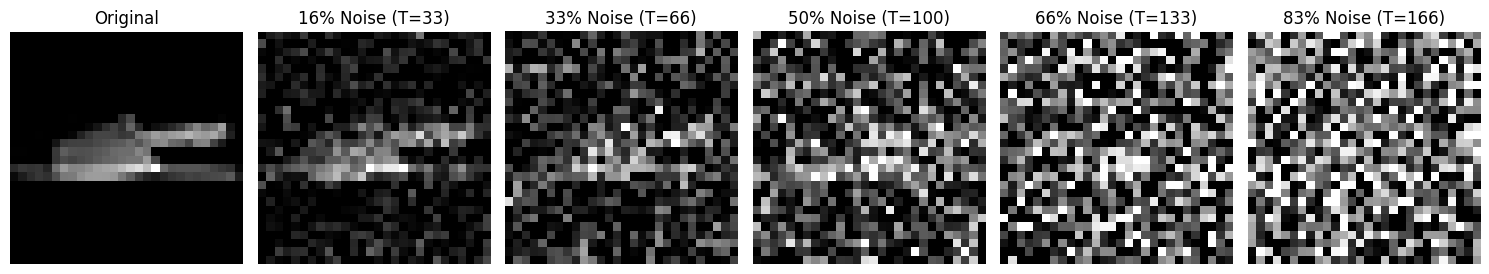

'\n# Try a non-linear noise schedule\nbeta_alt = torch.linspace(beta_start, beta_end, n_steps)**2 ...\n'

In [ ]:
# Visualization function to show how noise progressively affects images
def show_noise_progression(image, num_steps=5):
    """
    Visualize how an image gets progressively noisier in the diffusion process.

    Args:
        image (torch.Tensor): Original clean image [C, H, W] on correct device
        num_steps (int): Number of noise levels to show
    """
    # Ensure image is on the correct device
    image = image.to(device)
    # Define to_image locally if not defined globally earlier (it should be by Cell 6)
    if 'to_image' not in locals():
         def to_image(x):
              if x.dim() == 3: x = x.unsqueeze(0)
              x = x.clamp(-1, 1); img = (x + 1) * 0.5; img = img.clamp(0, 1)
              if x.size(0) == 1: img = img.squeeze(0)
              return img

    if plt is None: # Check if plotting is possible
        print("Matplotlib (plt) not available. Skipping noise progression plot.")
        return

    plt.figure(figsize=(15, 3))

    # Helper to display single image
    def _display_img(img_tensor, title):
        plt.title(title); plt.axis('off'); img_cpu = img_tensor.cpu()
        if IMG_CH == 1: plt.imshow(img_cpu[0], cmap='gray')
        else: img_plot = img_cpu.permute(1, 2, 0); plt.imshow(img_plot)

    # Show original image
    plt.subplot(1, num_steps + 1, 1)
    _display_img(to_image(image), 'Original') # Use to_image

    # Show progressively noisier versions
    for i in range(num_steps):
        t_idx = int(((i + 1) / (num_steps + 1)) * n_steps) # Sample intermediate steps
        t_idx = min(max(t_idx, 0), n_steps - 1) # Clamp index
        t = torch.tensor([t_idx], dtype=torch.long).to(device)
        noisy_image, _ = add_noise(image.unsqueeze(0), t) # Add noise
        noisy_image = noisy_image.squeeze(0)
        plt.subplot(1, num_steps + 1, i + 2)
        _display_img(to_image(noisy_image), f'{(t_idx/n_steps)*100:.0f}% Noise (T={t_idx})') # Use to_image

    plt.tight_layout(); plt.show()

# Show an example of noise progression on a real image
try:
    sample_batch = next(iter(train_dataloader)) # Use correct dataloader name
    sample_image = sample_batch[0][0].to(device)
    print("\nShowing Noise Progression Example:")
    show_noise_progression(sample_image, num_steps=5)
except NameError: print("Could not run noise progression: 'train_dataloader' not defined or empty.")
except StopIteration: print("Could not run noise progression: DataLoader is empty.")
except Exception as e: print(f"Error running noise progression: {e}")

# Student Activity: Try different noise schedules (Commented out)
"""
# Try a non-linear noise schedule
beta_alt = torch.linspace(beta_start, beta_end, n_steps)**2 ...
"""

## Step 5: Training Our Model

Now we'll teach our AI to generate images. This process:
1. Takes a clear image
2. Adds random noise to it
3. Asks our AI to predict what noise was added
4. Helps our AI learn from its mistakes

This will take a while, but we'll see progress as it learns!

In [ ]:
# Create our model and move it to GPU if available
# Define Architecture Params consistent with previous steps (e.g., Cell 20)
unet_down_chs = (64, 128, 256) # Recommended for Fashion-MNIST
unet_t_embed_dim = 256       # Recommended for Fashion-MNIST
unet_c_embed_dim = N_CLASSES # From dataset cell

print(f"--- Step 5: Instantiating Model ---")
model = UNet(
    T=n_steps,                 # Number of diffusion time steps (e.g., 200 from Cell 20)
    img_ch=IMG_CH,             # Number of channels (1 for Fashion-MNIST)
    img_size=IMG_SIZE,         # Size of input images (28 for Fashion-MNIST)
    down_chs=unet_down_chs,    # Channel dimensions for U-Net
    t_embed_dim=unet_t_embed_dim, # Dimension for time step embeddings
    c_embed_dim=unet_c_embed_dim # Number of classes for conditioning (10)
).to(device)
print(f"✓ UNet Model Instantiated on {device}")


# Set up the optimizer with parameters tuned for diffusion models
# Note: Lower learning rates tend to work better for diffusion models
initial_lr = 5e-4  # Starting learning rate (tuned slightly higher for Fashion-MNIST)
weight_decay = 1e-5  # L2 regularization
print(f"\n--- Step 5: Defining Optimizer & Scheduler ---")
optimizer = Adam(
    model.parameters(),
    lr=initial_lr,
    weight_decay=weight_decay
)
print(f"✓ Optimizer: Adam (LR={initial_lr}, Weight Decay={weight_decay})")

# Learning rate scheduler to reduce LR when validation loss plateaus
# This helps fine-tune the model toward the end of training
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',              # Reduce LR when monitored value stops decreasing
    factor=0.5,              # Multiply LR by this factor
    patience=3,              # Number of epochs with no improvement after which LR will be reduced
    verbose=True,            # Print message when LR is reduced
    min_lr=1e-6              # Lower bound on the learning rate
)
print("✓ LR Scheduler: ReduceLROnPlateau (Patience=3, Factor=0.5)")

# Training configuration constants (will be used in training loop cell)
early_stopping_patience = 10
gradient_clip_value = 1.0
display_frequency = 100       # Log loss every N steps
generate_frequency = 500      # Generate samples every N steps (mid-epoch)
epoch_generate_frequency = 5  # Generate samples every N epochs (end-of-epoch)
epoch_plot_frequency = 5      # Plot loss every N epochs
print(f"✓ Training configured: Early Stop Patience={early_stopping_patience}, Grad Clip={gradient_clip_value}")


# STUDENT EXPERIMENT: (Keep template comment)
# Try different channel configurations and see how they affect:
# 1. Model size (parameter count)
# 2. Training time
# 3. Generated image quality
#
# Suggestions:
# - Smaller: down_chs=(16, 32, 64)
# - Larger: down_chs=(64, 128, 256, 512)

--- Step 5: Instantiating Model ---
✓ Created UNet with 3 scale levels.
Channel dimensions: (64, 128, 256)
✓ UNet Model Instantiated on cuda

--- Step 5: Defining Optimizer & Scheduler ---
✓ Optimizer: Adam (LR=0.0005, Weight Decay=1e-05)
✓ LR Scheduler: ReduceLROnPlateau (Patience=3, Factor=0.5)
✓ Training configured: Early Stop Patience=10, Grad Clip=1.0


In [ ]:
# Define helper functions needed for training and evaluation
print(f"\n--- Step 5: Defining Helper Functions ---")

def validate_model_parameters(model):
    """Counts model parameters and estimates memory usage."""
    # (Code exactly as in template Cell 37)
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nModel Parameters Check:")
    print(f"  Total params: {total_params:,}, Trainable: {trainable_params:,}")
    param_memory = total_params * 4 / (1024**2); grad_memory = trainable_params * 4 / (1024**2)
    buffer_memory = param_memory * 2
    print(f"  Estimated GPU memory usage: ~{param_memory + grad_memory + buffer_memory:.1f} MB")

def verify_data_range(dataloader, name="Dataset"):
    """Verifies the range and integrity of the data."""
    # (Code exactly as in template Cell 37)
    try:
        batch = next(iter(dataloader))[0]
        print(f"\n{name} range check:")
        print(f"  Shape: {batch.shape}, Type: {batch.dtype}")
        print(f"  Min: {batch.min().item():.2f}, Max: {batch.max().item():.2f}")
        print(f"  NaNs: {torch.isnan(batch).any().item()}, Infs: {torch.isinf(batch).any().item()}")
    except StopIteration: print(f"⚠️ {name} dataloader is empty, cannot verify range.")
    except Exception as e: print(f"Could not verify data range for {name}: {e}")

# Define original generate_samples (template Cell 38) - uses remove_noise (non-CFG)
# This is needed for the template's original CLIP evaluation step later (Cell 38)
@torch.no_grad()
def generate_samples_original(model, n_samples=10): # Renamed
    """
    Generates sample images using the model for visualization during training. (NO CFG)
    """
    # (Code exactly as in template Cell 38, using remove_noise)
    model.eval()
    samples = []
    num_to_generate = min(n_samples, N_CLASSES)
    print(f"\n(Generating {num_to_generate} samples using ORIGINAL non-CFG method...)")
    for digit in range(num_to_generate):
        x = torch.randn(1, IMG_CH, IMG_SIZE, IMG_SIZE).to(device)
        c = torch.tensor([digit], dtype=torch.long).to(device)
        c_one_hot = F.one_hot(c, N_CLASSES).float().to(device)
        c_mask = torch.ones(1, dtype=torch.bool, device=device) # Boolean mask [B]
        for t in range(n_steps-1, -1, -1): # Use global n_steps
            t_batch = torch.full((1,), t, dtype=torch.long).to(device)
            x = remove_noise(x, t_batch, model, c_one_hot, c_mask) # Call original remove_noise
        samples.append(x)
    samples = torch.cat(samples, dim=0)
    samples_display = to_image(samples) # Un-normalize
    grid = make_grid(samples_display, nrow=min(n_samples, 5))
    if plt:
        plt.figure(figsize=(10, max(2, 2 * (num_to_generate // 5 + 1)) ))
        if IMG_CH == 1: plt.imshow(grid[0].cpu(), cmap='gray')
        else: plt.imshow(grid.permute(1, 2, 0).cpu())
        plt.axis('off'); plt.title('Generated Samples (Original Method - No CFG)')
        plt.show()
    model.train()
    return samples # Return samples in [-1, 1] range

# Define NEW generate_samples_cfg function for use IN THE TRAINING LOOP
@torch.no_grad()
def generate_samples_cfg(model, n_samples=10, cfg_scale=5.0):
    """Generates sample images (0-9) using the model with CFG (Fashion-MNIST)."""
    # (Code from previous responses for CFG generation)
    # print(f"Generating samples with CFG (scale={cfg_scale})...") # Less verbose
    model.eval()
    samples_list = []
    num_to_generate = min(n_samples, N_CLASSES)
    for item_class_index in range(num_to_generate):
        x = torch.randn(1, IMG_CH, IMG_SIZE, IMG_SIZE).to(device)
        c = torch.tensor([item_class_index], dtype=torch.long).to(device)
        c_one_hot = F.one_hot(c, num_classes=N_CLASSES).float()
        c_mask_cond = torch.ones(1, dtype=torch.bool, device=device)
        c_mask_uncond = torch.zeros(1, dtype=torch.bool, device=device)
        for t_val in range(n_steps - 1, -1, -1): # Use global n_steps
            t_batch = torch.full((1,), t_val, device=device, dtype=torch.long)
            eps_uncond = model(x, t_batch, c_one_hot, c_mask_uncond)
            eps_cond = model(x, t_batch, c_one_hot, c_mask_cond)
            eps = (1 + cfg_scale) * eps_cond - cfg_scale * eps_uncond # CFG calculation
            # Denoising step math
            alpha_t=alpha[t_val]; beta_t=beta[t_val]; sqrt_one_minus_alpha_bar_t=sqrt_one_minus_alpha_bar[t_val]
            alpha_t_rs=alpha_t.view(-1,1,1,1); beta_t_rs=beta_t.view(-1,1,1,1); sqrt_one_minus_alpha_bar_t_rs=sqrt_one_minus_alpha_bar_t.view(-1,1,1,1)
            mean = (1/torch.sqrt(alpha_t_rs)) * (x-(beta_t_rs/sqrt_one_minus_alpha_bar_t_rs)*eps)
            if t_val > 0: noise=torch.randn_like(x); variance=torch.sqrt(beta_t_rs); x=mean+variance*noise
            else: x=mean
        samples_list.append(x)
    samples = torch.cat(samples_list, dim=0)
    samples_display = to_image(samples) # Un-normalize
    grid = make_grid(samples_display, nrow=min(n_samples, 5))
    if plt:
      plt.figure(figsize=(10, max(2, 2 * (num_to_generate // 5 + 1)) ))
      plt.imshow(grid[0].cpu(), cmap='gray'); plt.axis('off'); plt.title(f'Generated Samples (CFG Scale: {cfg_scale})')
      plt.show()
    model.train() # Set back to train mode
    # No return needed if only used for display during training

# Define safe_save_model (from template Cell 39)
def safe_save_model(model, path, optimizer=None, epoch=None, best_loss=None):
    """Safely saves model with error handling and backup."""
    # (Code exactly as in template Cell 39)
    try:
        save_dict = {'model_state_dict': model.state_dict()}
        if optimizer is not None: save_dict['optimizer_state_dict'] = optimizer.state_dict()
        if epoch is not None: save_dict['epoch'] = epoch
        if best_loss is not None: save_dict['best_loss'] = best_loss
        if os.path.exists(path):
            backup_path = path + '.backup'
            try: os.replace(path, backup_path)
            except Exception as e: print(f"Warning: Could not create backup - {e}")
        torch.save(save_dict, path)
        print(f"✓ Model successfully saved to {path}") # Use checkmark
    except Exception as e: print(f"❌ Error saving model: {e}") # Use cross mark

# Define calculate_val_loss function (needed for validation loop)
@torch.no_grad()
def calculate_val_loss(model, x, c):
    """Calculates validation loss without CFG training strategy and no grads."""
    model.eval() # Ensure eval mode
    c_one_hot = F.one_hot(c, num_classes=N_CLASSES).float().to(device)
    c_mask_cond = torch.ones(c.shape[0], dtype=torch.bool, device=device) # Always condition
    t = torch.randint(0, n_steps, (x.shape[0],), device=device, dtype=torch.long)
    x_t, noise = add_noise(x, t)
    predicted_noise = model(x_t, t, c_one_hot, c_mask_cond) # Use conditional mask
    loss = F.mse_loss(predicted_noise, noise)
    # model.train() # Let the main loop handle setting mode back
    return loss.item() # Return scalar value

print("✓ Helper functions for validation, saving, and generation defined.")

# --- Run Validation Checks Now ---
validate_model_parameters(model)
verify_data_range(train_dataloader, name="Training Data")
verify_data_range(val_dataloader, name="Validation Data")


--- Step 5: Defining Helper Functions ---
✓ Helper functions for validation, saving, and generation defined.

Model Parameters Check:
  Total params: 6,343,169, Trainable: 6,343,169
  Estimated GPU memory usage: ~96.8 MB

Training Data range check:
  Shape: torch.Size([128, 1, 28, 28]), Type: torch.float32
  Min: -1.00, Max: 1.00
  NaNs: False, Infs: False

Validation Data range check:
  Shape: torch.Size([128, 1, 28, 28]), Type: torch.float32
  Min: -1.00, Max: 1.00
  NaNs: False, Infs: False


In [ ]:
#  Implementation of the training step function (Template Cell 40 - REVISED)
print(f"\n--- Step 5: Defining Training Step Function (with CFG) ---")
def train_step(x, c):
    """
    Performs a single training step for the diffusion model with CFG strategy.

    This function:
    1. Prepares class conditioning (one-hot)
    2. Implements CFG by randomly masking conditioning for some samples
    3. Samples random timesteps for each image
    4. Adds corresponding noise to the images (using add_noise)
    5. Asks the model to predict the noise (using the CFG mask)
    6. Calculates the loss between predicted and actual noise

    Args:
        x (torch.Tensor): Batch of clean images [B, C, H, W]
        c (torch.Tensor): Batch of class labels [B]

    Returns:
        torch.Tensor: Mean squared error loss tensor (for backpropagation)
    """
    # Convert number labels to one-hot encoding for class conditioning
    c_one_hot = F.one_hot(c, N_CLASSES).float().to(device) # Use global N_CLASSES

    # Create conditioning mask (all ones for standard training was template)
    # --- Classifier-Free Guidance Training Mask ---
    # Randomly drop conditioning for ~10% of samples
    prob_uncond = 0.1
    # c_mask_cfg is True if we condition, False if we don't (unconditional)
    c_mask_cfg = (torch.rand(c.shape[0], device=device) > prob_uncond) # Boolean mask [B]


    # Pick random timesteps for each image in the batch
    # Use global n_steps (e.g., 200 for Fashion-MNIST)
    t = torch.randint(0, n_steps, (x.shape[0],), device=device, dtype=torch.long)

    # Add noise to images according to the forward diffusion process
    # Hint: Use the add_noise function you defined earlier
    # Enter your code here:
    x_t, noise = add_noise(x, t) # add_noise defined in template Cell 21

    # The model tries to predict the exact noise that was added
    # Pass the CFG mask (c_mask_cfg) to the model's forward method
    predicted_noise = model(x_t, t, c_one_hot, c_mask_cfg) # Model uses boolean mask [B]

    # Calculate loss: how accurately did the model predict the noise?
    # MSE loss works well for image-based diffusion models
    # Hint: Use F.mse_loss to compare predicted and actual noise
    # Enter your code here:
    loss = F.mse_loss(predicted_noise, noise)

    # Return the loss tensor (backprop happens outside this function)
    return loss

print("✓ Training step function `train_step` (with CFG logic) defined.")


--- Step 5: Defining Training Step Function (with CFG) ---
✓ Training step function `train_step` (with CFG logic) defined.



STARTING Fashion-MNIST TRAINING
Epochs: 25, Batch Size: 128, Diffusion Steps: 200
Device: cuda

--- Epoch 1/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 1 Avg Loss: 0.1269
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 1 Avg Loss: 0.0960
Current LR: 0.000500
✓ New best model found! Saving to 'best_diffusion_model_fashion_mnist.pth' (Val Loss: 0.0960)
✓ Model successfully saved to best_diffusion_model_fashion_mnist.pth

--- Epoch 2/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 2 Avg Loss: 0.0893
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 2 Avg Loss: 0.0822
Current LR: 0.000500
✓ New best model found! Saving to 'best_diffusion_model_fashion_mnist.pth' (Val Loss: 0.0822)
✓ Model successfully saved to best_diffusion_model_fashion_mnist.pth

--- Epoch 3/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 3 Avg Loss: 0.0807
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 3 Avg Loss: 0.0793
Current LR: 0.000500
✓ New best model found! Saving to 'best_diffusion_model_fashion_mnist.pth' (Val Loss: 0.0793)
✓ Model successfully saved to best_diffusion_model_fashion_mnist.pth

--- Epoch 4/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 4 Avg Loss: 0.0777
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 4 Avg Loss: 0.0753
Current LR: 0.000500
✓ New best model found! Saving to 'best_diffusion_model_fashion_mnist.pth' (Val Loss: 0.0753)
✓ Model successfully saved to best_diffusion_model_fashion_mnist.pth

--- Epoch 5/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 5 Avg Loss: 0.0753
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 5 Avg Loss: 0.0768
Current LR: 0.000500
Validation loss did not improve for 1/10 epochs.

Generating samples end of epoch 5...


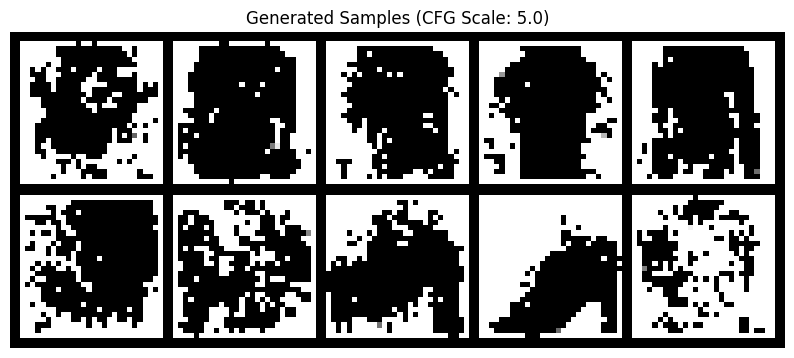

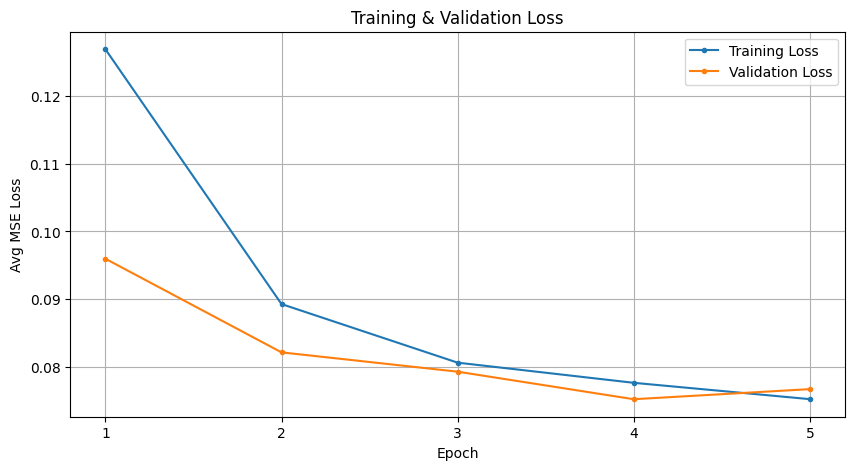


--- Epoch 6/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 6 Avg Loss: 0.0734
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 6 Avg Loss: 0.0741
Current LR: 0.000500
✓ New best model found! Saving to 'best_diffusion_model_fashion_mnist.pth' (Val Loss: 0.0741)
✓ Model successfully saved to best_diffusion_model_fashion_mnist.pth

--- Epoch 7/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 7 Avg Loss: 0.0730
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 7 Avg Loss: 0.0721
Current LR: 0.000500
✓ New best model found! Saving to 'best_diffusion_model_fashion_mnist.pth' (Val Loss: 0.0721)
✓ Model successfully saved to best_diffusion_model_fashion_mnist.pth

--- Epoch 8/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 8 Avg Loss: 0.0719
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 8 Avg Loss: 0.0714
Current LR: 0.000500
✓ New best model found! Saving to 'best_diffusion_model_fashion_mnist.pth' (Val Loss: 0.0714)
✓ Model successfully saved to best_diffusion_model_fashion_mnist.pth

--- Epoch 9/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 9 Avg Loss: 0.0700
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 9 Avg Loss: 0.0692
Current LR: 0.000500
✓ New best model found! Saving to 'best_diffusion_model_fashion_mnist.pth' (Val Loss: 0.0692)
✓ Model successfully saved to best_diffusion_model_fashion_mnist.pth

--- Epoch 10/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 10 Avg Loss: 0.0708
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 10 Avg Loss: 0.0713
Current LR: 0.000500
Validation loss did not improve for 1/10 epochs.

Generating samples end of epoch 10...


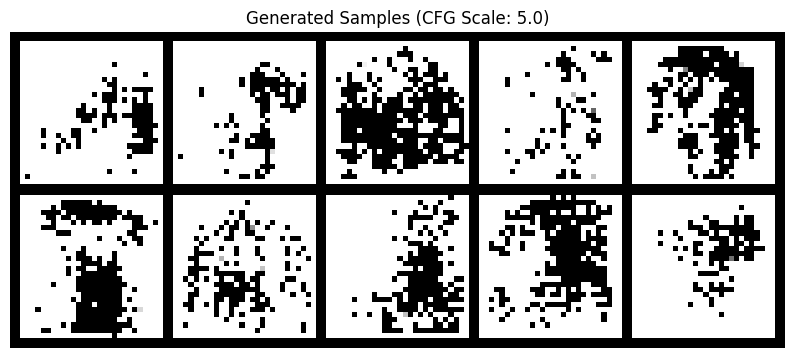

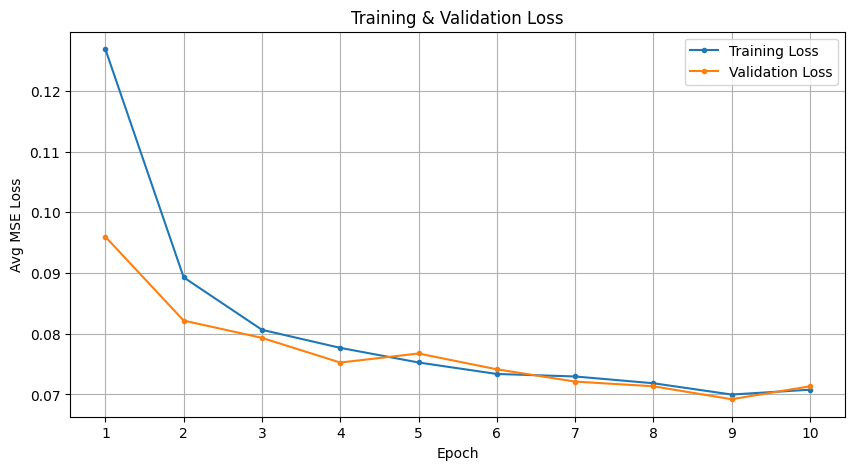


--- Epoch 11/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 11 Avg Loss: 0.0695
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 11 Avg Loss: 0.0724
Current LR: 0.000500
Validation loss did not improve for 2/10 epochs.

--- Epoch 12/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 12 Avg Loss: 0.0701
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 12 Avg Loss: 0.0695
Current LR: 0.000500
Validation loss did not improve for 3/10 epochs.

--- Epoch 13/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 13 Avg Loss: 0.0688
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 13 Avg Loss: 0.0690
Current LR: 0.000500
✓ New best model found! Saving to 'best_diffusion_model_fashion_mnist.pth' (Val Loss: 0.0690)
✓ Model successfully saved to best_diffusion_model_fashion_mnist.pth

--- Epoch 14/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 14 Avg Loss: 0.0689
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 14 Avg Loss: 0.0681
Current LR: 0.000500
✓ New best model found! Saving to 'best_diffusion_model_fashion_mnist.pth' (Val Loss: 0.0681)
✓ Model successfully saved to best_diffusion_model_fashion_mnist.pth

--- Epoch 15/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 15 Avg Loss: 0.0690
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 15 Avg Loss: 0.0686
Current LR: 0.000500
Validation loss did not improve for 1/10 epochs.

Generating samples end of epoch 15...


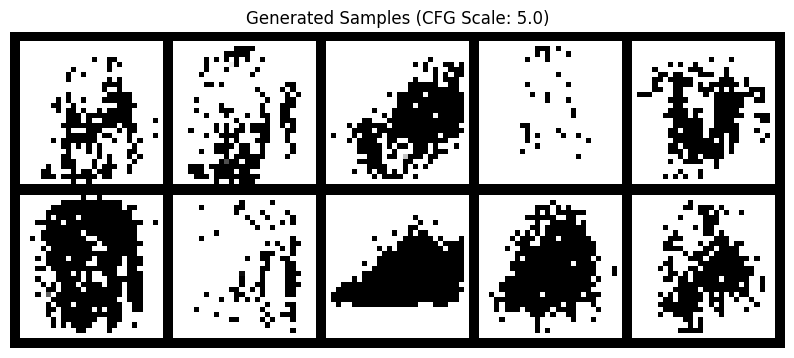

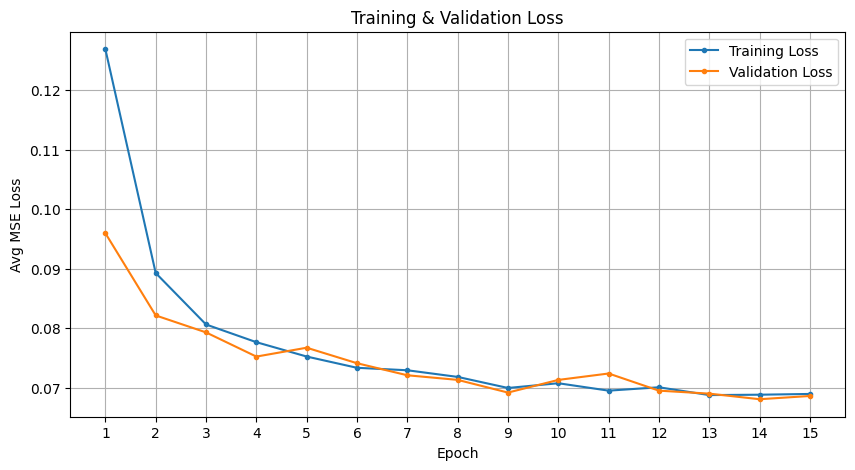


--- Epoch 16/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 16 Avg Loss: 0.0686
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 16 Avg Loss: 0.0697
Current LR: 0.000500
Validation loss did not improve for 2/10 epochs.

--- Epoch 17/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 17 Avg Loss: 0.0683
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 17 Avg Loss: 0.0692
Current LR: 0.000500
Validation loss did not improve for 3/10 epochs.

--- Epoch 18/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 18 Avg Loss: 0.0687
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 18 Avg Loss: 0.0690
Current LR: 0.000250
Validation loss did not improve for 4/10 epochs.

--- Epoch 19/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 19 Avg Loss: 0.0662
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 19 Avg Loss: 0.0669
Current LR: 0.000250
✓ New best model found! Saving to 'best_diffusion_model_fashion_mnist.pth' (Val Loss: 0.0669)
✓ Model successfully saved to best_diffusion_model_fashion_mnist.pth

--- Epoch 20/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 20 Avg Loss: 0.0659
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 20 Avg Loss: 0.0666
Current LR: 0.000250
✓ New best model found! Saving to 'best_diffusion_model_fashion_mnist.pth' (Val Loss: 0.0666)
✓ Model successfully saved to best_diffusion_model_fashion_mnist.pth

Generating samples end of epoch 20...


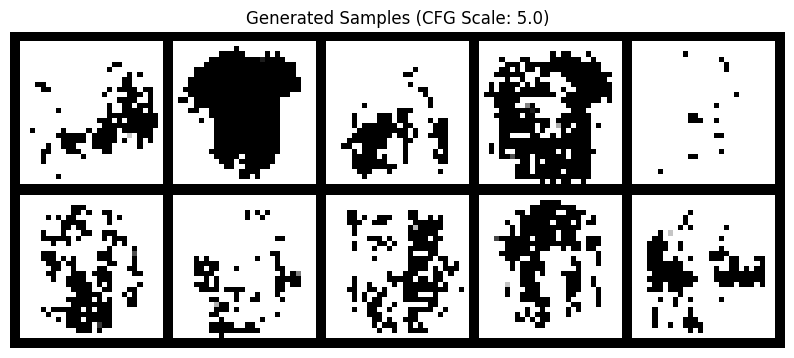

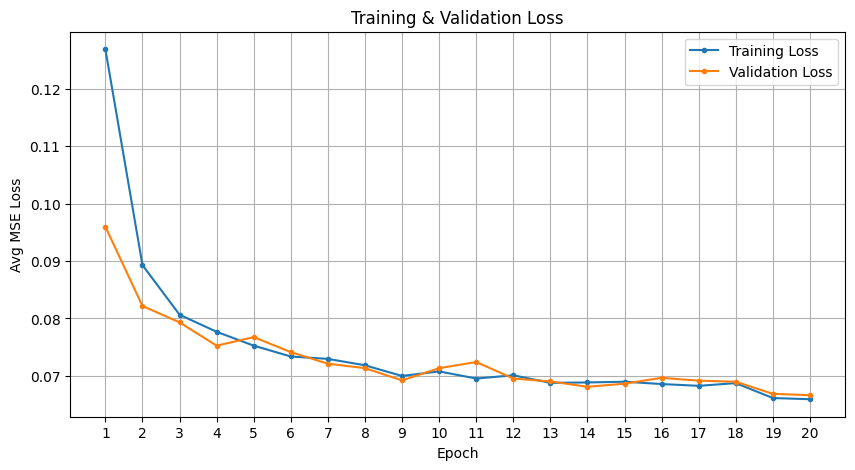


--- Epoch 21/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 21 Avg Loss: 0.0667
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 21 Avg Loss: 0.0662
Current LR: 0.000250
✓ New best model found! Saving to 'best_diffusion_model_fashion_mnist.pth' (Val Loss: 0.0662)
✓ Model successfully saved to best_diffusion_model_fashion_mnist.pth

--- Epoch 22/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 22 Avg Loss: 0.0656
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 22 Avg Loss: 0.0667
Current LR: 0.000250
Validation loss did not improve for 1/10 epochs.

--- Epoch 23/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 23 Avg Loss: 0.0664
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 23 Avg Loss: 0.0653
Current LR: 0.000250
✓ New best model found! Saving to 'best_diffusion_model_fashion_mnist.pth' (Val Loss: 0.0653)
✓ Model successfully saved to best_diffusion_model_fashion_mnist.pth

--- Epoch 24/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 24 Avg Loss: 0.0656
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 24 Avg Loss: 0.0660
Current LR: 0.000250
Validation loss did not improve for 1/10 epochs.

--- Epoch 25/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 25 Avg Loss: 0.0662
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 25 Avg Loss: 0.0670
Current LR: 0.000250
Validation loss did not improve for 2/10 epochs.

Generating samples end of epoch 25...


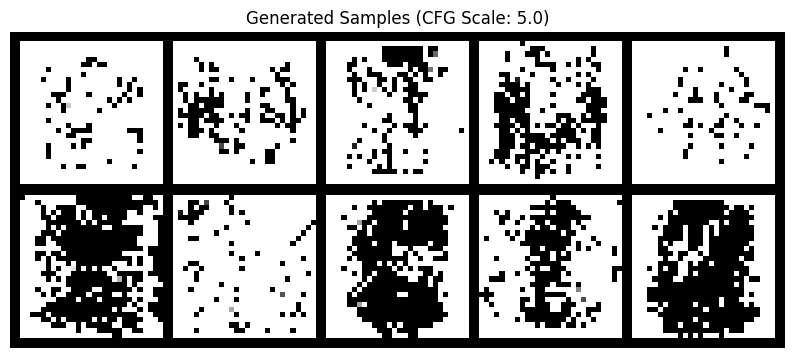

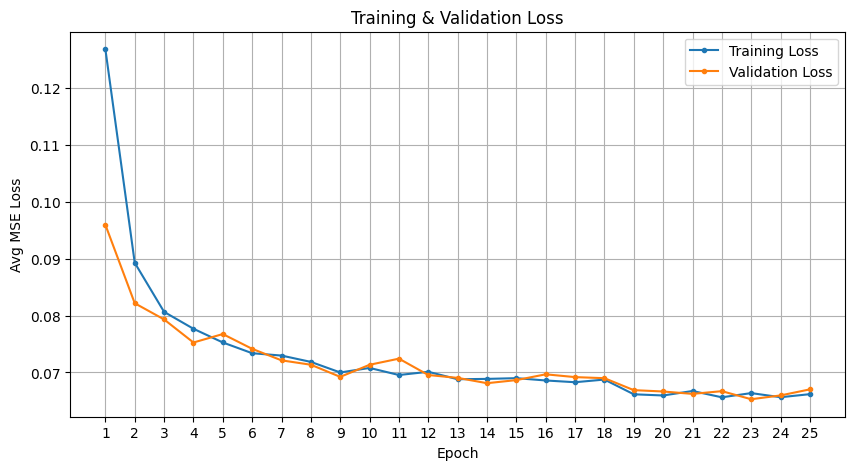


TRAINING PROCESS COMPLETE (Fashion-MNIST)
Best validation loss achieved: 0.0653

Loading best model ('best_diffusion_model_fashion_mnist.pth') for final samples...
✓ Created UNet with 3 scale levels.
Channel dimensions: (64, 128, 256)
✓ Best model loaded.


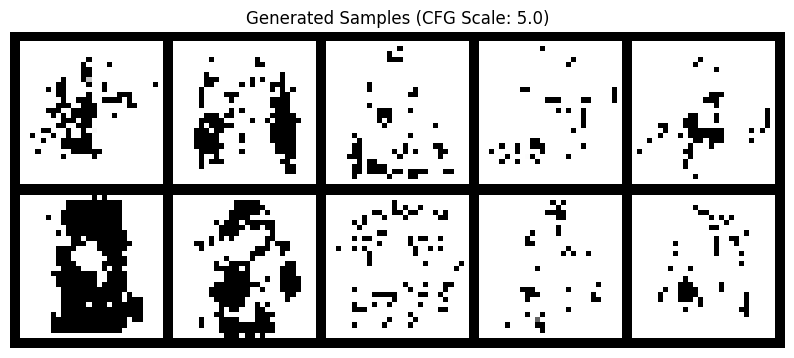


Displaying final loss curves...


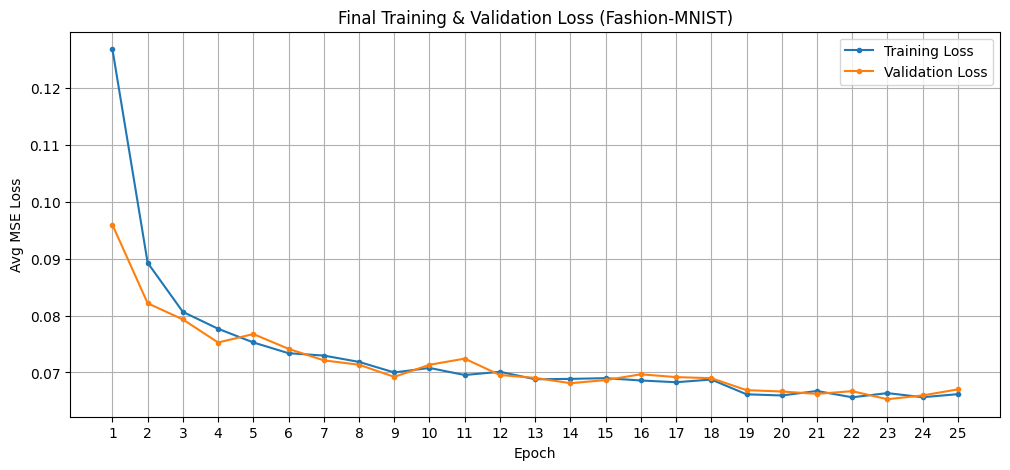


Attempting final memory cleanup...
✓ Memory cleanup attempted.


In [ ]:
# Implementation of the main training loop (Template Cell 41)

# Progress tracking variables
best_loss = float('inf')
train_losses = []
val_losses = []
no_improve_epochs = 0

# Training loop
print("\n" + "="*50)
print(f"STARTING {dataset} TRAINING")
print(f"Epochs: {EPOCHS}, Batch Size: {BATCH_SIZE}, Diffusion Steps: {n_steps}")
print(f"Device: {device}")
print("="*50)


# Wrap the training loop in a try-except block for better error handling:
# Your code for the training loop
# Hint: Use a try-except block for better error handling
# Process each epoch and each batch, with validation after each epoch

# Enter your code here:
try:
    for epoch in range(EPOCHS): # Use EPOCHS defined in dataset cell
        print(f"\n--- Epoch {epoch+1}/{EPOCHS} ---")
        # print("-" * 20) # Template comment

        # === Training phase ===
        model.train()
        epoch_train_losses = [] # Renamed from epoch_losses

        # Process each batch
        pbar_train = tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc="Training", leave=False) # Use train_dataloader
        for step, (images, labels) in pbar_train:
            images = images.to(device)
            labels = labels.to(device)

            # --- Training step ---
            optimizer.zero_grad()
            loss = train_step(images, labels) # Calls CFG train_step (returns tensor)
            loss.backward() # Backpropagate
            # Add gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clip_value)
            optimizer.step() # Update weights
            # ---------------------

            current_loss_item = loss.item()
            epoch_train_losses.append(current_loss_item)
            pbar_train.set_postfix(Loss=f"{current_loss_item:.4f}") # Update progress bar

            # Show progress at regular intervals
            # if (step + 1) % display_frequency == 0: # Less verbose default
            #    avg_recent_loss = sum(epoch_train_losses[-display_frequency:]) / max(1, len(epoch_train_losses[-display_frequency:]))
            #    print(f"  Epoch {epoch+1}, Step {step+1}/{len(train_dataloader)}, Avg Loss (last {display_frequency}): {avg_recent_loss:.4f}")

            # Generate samples less frequently to save time (mid-epoch)
            if (step + 1) % generate_frequency == 0 and step > 0:
                 try:
                     print(f"\n  Generating samples mid-epoch (step {step+1})...")
                     generate_samples_cfg(model, n_samples=10, cfg_scale=5.0) # Use CFG version defined in Cell 26
                     model.train() # Ensure back to train mode
                 except Exception as e: print(f"  Error generating mid-epoch samples: {e}"); model.train()

        # End of epoch - calculate average training loss
        avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses) if epoch_train_losses else 0
        train_losses.append(avg_train_loss)
        print(f"Training Finished - Epoch {epoch+1} Avg Loss: {avg_train_loss:.4f}")

        # === Validation phase ===
        model.eval()
        val_epoch_losses = []
        print("Running validation...")
        pbar_val = tqdm(val_dataloader, desc="Validation", leave=False) # Use val_dataloader
        with torch.no_grad():
            for val_images, val_labels in pbar_val:
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)
                # Calculate validation loss using the helper function
                val_loss = calculate_val_loss(model, val_images, val_labels) # Use helper defined in Cell 26
                val_epoch_losses.append(val_loss) # Append scalar loss
                pbar_val.set_postfix(Loss=f"{val_loss:.4f}")

        # Calculate average validation loss
        avg_val_loss = sum(val_epoch_losses) / len(val_epoch_losses) if val_epoch_losses else float('inf')
        val_losses.append(avg_val_loss)
        print(f"Validation Finished - Epoch {epoch+1} Avg Loss: {avg_val_loss:.4f}")

        # Learning rate scheduling based on validation loss
        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Current LR: {current_lr:.6f}") # Print LR each epoch

        # Save best model based on validation loss
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            # Use safe_save_model instead of just saving state_dict
            save_path = f'best_diffusion_model_{dataset.lower().replace("-","_")}.pth' # Dynamic save path
            try:
                print(f"✓ New best model found! Saving to '{save_path}' (Val Loss: {best_loss:.4f})")
                safe_save_model(model, save_path, optimizer, epoch, best_loss) # Use safe_save_model from Cell 26
            except NameError:
                 print(f"  safe_save_model not found, using basic torch.save to '{save_path}'.")
                 torch.save({'epoch': epoch,'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer.state_dict(),'best_loss': best_loss }, save_path)
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            print(f"Validation loss did not improve for {no_improve_epochs}/{early_stopping_patience} epochs.")
            # Early stopping
            if no_improve_epochs >= early_stopping_patience:
                print(f"\nEarly stopping triggered after {epoch+1} epochs.")
                break # Exit loop

        # Generate samples at the end of each epoch periodically
        if (epoch + 1) % epoch_generate_frequency == 0 or epoch == EPOCHS - 1:
            try:
                print(f"\nGenerating samples end of epoch {epoch+1}...")
                generate_samples_cfg(model, n_samples=10, cfg_scale=5.0) # Use CFG version from Cell 26
                model.train() # Back to train mode
            except Exception as e: print(f"  Error generating end-of-epoch samples: {e}"); model.train()

        # Plot loss curves every few epochs
        if plt and ((epoch + 1) % epoch_plot_frequency == 0 or epoch == EPOCHS - 1):
             try:
                 plt.figure(figsize=(10, 5))
                 plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='.')
                 plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='.')
                 plt.xlabel('Epoch'); plt.ylabel('Avg MSE Loss'); plt.title('Training & Validation Loss')
                 plt.legend(); plt.grid(True); plt.xticks(range(1, len(train_losses) + 1))
                 plt.show()
             except Exception as e: print(f"Error plotting losses: {e}")


# === End of Training Loop ===
except KeyboardInterrupt:
    print("\n--- Training interrupted by user ---")
except Exception as e:
    print(f"\n--- An error occurred during training: {e} ---")
    traceback.print_exc()

# ––– Final wrap-up ––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
print("\n" + "="*50)
print(f"TRAINING PROCESS COMPLETE ({dataset})")
print("="*50)
if val_losses: print(f"Best validation loss achieved: {best_loss:.4f}")
else: print("No validation epochs completed.")

# Generate final samples using the *best* model weights if saved
final_save_path = f'best_diffusion_model_{dataset.lower().replace("-","_")}.pth'
try:
    print(f"\nLoading best model ('{final_save_path}') for final samples...")
    checkpoint = torch.load(final_save_path, map_location=device)
    # Re-instantiate the model architecture to load the state dict into
    final_model = UNet( T=n_steps, img_ch=IMG_CH, img_size=IMG_SIZE, down_chs=unet_down_chs,
                       t_embed_dim=unet_t_embed_dim, c_embed_dim=unet_c_embed_dim ).to(device)
    final_model.load_state_dict(checkpoint['model_state_dict'])
    print("✓ Best model loaded.")
    # Use the CFG generation function for final output
    generate_samples_cfg(final_model, n_samples=10, cfg_scale=5.0)
except FileNotFoundError:
    print(f"Best model checkpoint ('{final_save_path}') not found. Generating samples from final model state.")
    generate_samples_cfg(model, n_samples=10, cfg_scale=5.0) # Generate with final model using CFG
except Exception as e:
    print(f"Could not load best model or generate final samples: {e}")
    traceback.print_exc()

# Display final loss curves
if plt and train_losses and val_losses:
    try:
        print("\nDisplaying final loss curves...")
        plt.figure(figsize=(12, 5))
        plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='.')
        plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='.')
        plt.xlabel('Epoch'); plt.ylabel('Avg MSE Loss'); plt.title(f'Final Training & Validation Loss ({dataset})')
        plt.legend(); plt.grid(True); plt.xticks(range(1, len(train_losses) + 1))
        plt.show()
    except Exception as e: print(f"Error plotting final losses: {e}")

# Clean up memory (Template wrap-up)
print("\nAttempting final memory cleanup...")
try:
    del images, labels, val_images, val_labels, loss, x_t, noise, predicted_noise
    del final_model, checkpoint
except NameError: pass
gc.collect(); torch.cuda.empty_cache()
print("✓ Memory cleanup attempted.")

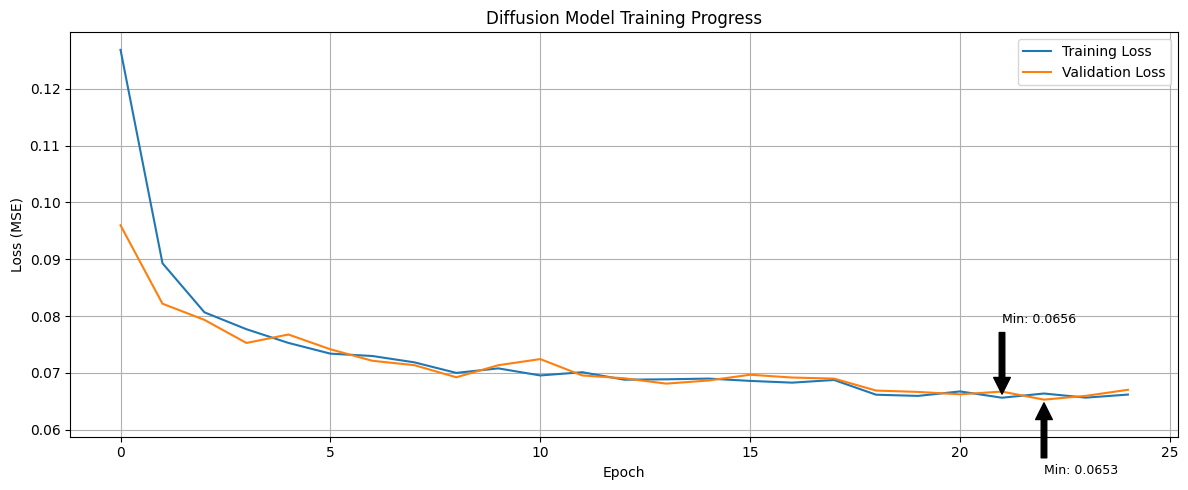


Training Statistics:
------------------------------
Starting training loss:    0.1269
Final training loss:       0.0662
Best training loss:        0.0656
Training loss improvement: 48.3%

Validation Statistics:
------------------------------
Starting validation loss: 0.0960
Final validation loss:    0.0670
Best validation loss:     0.0653


In [ ]:
# Plot training progress
plt.figure(figsize=(12, 5))

# Plot training and validation losses for comparison
plt.plot(train_losses, label='Training Loss')
if len(val_losses) > 0:  # Only plot validation if it exists
    plt.plot(val_losses, label='Validation Loss')

# Improve the plot with better labels and styling
plt.title('Diffusion Model Training Progress')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

# Add annotations for key points
if len(train_losses) > 1:
    min_train_idx = train_losses.index(min(train_losses))
    plt.annotate(f'Min: {min(train_losses):.4f}',
                 xy=(min_train_idx, min(train_losses)),
                 xytext=(min_train_idx, min(train_losses)*1.2),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 fontsize=9)

# Add validation min point if available
if len(val_losses) > 1:
    min_val_idx = val_losses.index(min(val_losses))
    plt.annotate(f'Min: {min(val_losses):.4f}',
                xy=(min_val_idx, min(val_losses)),
                xytext=(min_val_idx, min(val_losses)*0.8),
                arrowprops=dict(facecolor='black', shrink=0.05),
                fontsize=9)

# Set y-axis to start from 0 or slightly lower than min value
plt.ylim(bottom=max(0, min(min(train_losses) if train_losses else float('inf'),
                          min(val_losses) if val_losses else float('inf'))*0.9))

plt.tight_layout()
plt.show()

# Add statistics summary for students to analyze
print("\nTraining Statistics:")
print("-" * 30)
if train_losses:
    print(f"Starting training loss:    {train_losses[0]:.4f}")
    print(f"Final training loss:       {train_losses[-1]:.4f}")
    print(f"Best training loss:        {min(train_losses):.4f}")
    print(f"Training loss improvement: {((train_losses[0] - min(train_losses)) / train_losses[0] * 100):.1f}%")

if val_losses:
    print("\nValidation Statistics:")
    print("-" * 30)
    print(f"Starting validation loss: {val_losses[0]:.4f}")
    print(f"Final validation loss:    {val_losses[-1]:.4f}")
    print(f"Best validation loss:     {min(val_losses):.4f}")

# STUDENT EXERCISE:
# 1. Try modifying this plot to show a smoothed version of the losses
# 2. Create a second plot showing the ratio of validation to training loss
#    (which can indicate overfitting when the ratio increases)

## Step 5.5: Debugging

### The fun part

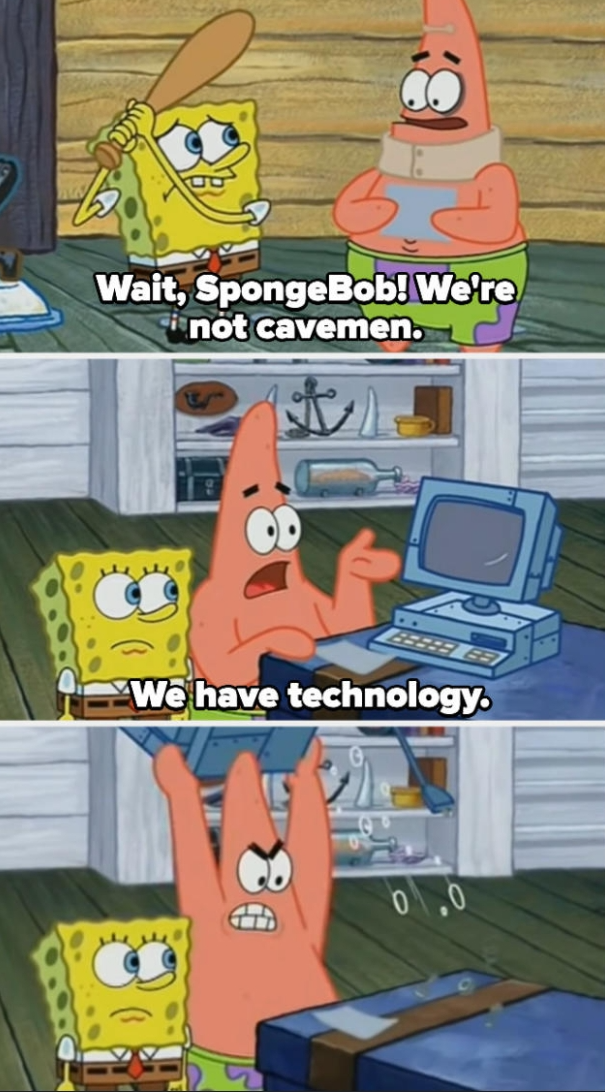

In [ ]:
# --- Step 5: Model Instantiation (Reduced Steps) ---
# Keep same architecture params as before
unet_down_chs = (64, 128, 256)
unet_t_embed_dim = 256
unet_c_embed_dim = N_CLASSES

print(f"--- Step 5: Instantiating Model (T=100) ---")
model = UNet(
    T=n_steps,                 # <<< USES n_steps = 100 >>>
    img_ch=IMG_CH,
    img_size=IMG_SIZE,
    down_chs=unet_down_chs,
    t_embed_dim=unet_t_embed_dim,
    c_embed_dim=unet_c_embed_dim
).to(device)
print(f"✓ UNet Model Instantiated on {device}")

# --- Define Optimizer & Scheduler ---
initial_lr = 5e-4  # Or 2e-4, adjust if needed
weight_decay = 1e-5
print(f"\n--- Step 5: Defining Optimizer & Scheduler ---")
optimizer = Adam(model.parameters(), lr=initial_lr, weight_decay=weight_decay)
print(f"✓ Optimizer: Adam (LR={initial_lr}, Weight Decay={weight_decay})")
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True, min_lr=1e-6
)
print("✓ LR Scheduler: ReduceLROnPlateau (Patience=3, Factor=0.5)")

# --- Training Config ---
early_stopping_patience = 10
gradient_clip_value = 1.0
display_frequency = 100
generate_frequency = 500
epoch_generate_frequency = 5
epoch_plot_frequency = 5
print(f"✓ Training configured.")

# Note: Helpers defined in next cell

--- Step 5: Instantiating Model (T=100) ---
✓ Created UNet with 3 scale levels.
Channel dimensions: (64, 128, 256)
✓ UNet Model Instantiated on cuda

--- Step 5: Defining Optimizer & Scheduler ---
✓ Optimizer: Adam (LR=0.0005, Weight Decay=1e-05)
✓ LR Scheduler: ReduceLROnPlateau (Patience=3, Factor=0.5)
✓ Training configured.


In [ ]:
# Define helper functions needed for training and evaluation
print(f"\n--- Step 5: Defining Helper Functions (with Debug Prints & Clarity) ---")

# --- Template Helpers (Keep as is) ---
def validate_model_parameters(model):
    """Counts model parameters and estimates memory usage."""
    # (Code exactly as in template Cell 37)
    total_params = sum(p.numel() for p in model.parameters()); trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nModel Parameters Check:"); print(f"  Total params: {total_params:,}, Trainable: {trainable_params:,}")
    param_memory = total_params * 4 / (1024**2); grad_memory = trainable_params * 4 / (1024**2); buffer_memory = param_memory * 2
    print(f"  Estimated GPU memory usage: ~{param_memory + grad_memory + buffer_memory:.1f} MB")

def verify_data_range(dataloader, name="Dataset"):
    """Verifies the range and integrity of the data."""
    # (Code exactly as in template Cell 37)
    try:
        batch = next(iter(dataloader))[0]
        print(f"\n{name} range check:")
        print(f"  Shape: {batch.shape}, Type: {batch.dtype}"); print(f"  Min: {batch.min().item():.2f}, Max: {batch.max().item():.2f}")
        print(f"  NaNs: {torch.isnan(batch).any().item()}, Infs: {torch.isinf(batch).any().item()}")
    except StopIteration: print(f"⚠️ {name} dataloader is empty.")
    except Exception as e: print(f"Could not verify data range for {name}: {e}")

# --- Corrected safe_save_model function ---
def safe_save_model(model, path, optimizer=None, epoch=None, best_loss=None):
    """Safely saves model with error handling and backup."""
    try:
        save_dict = {'model_state_dict': model.state_dict()}
        if optimizer is not None: save_dict['optimizer_state_dict'] = optimizer.state_dict()
        if epoch is not None: save_dict['epoch'] = epoch
        if best_loss is not None: save_dict['best_loss'] = best_loss
        if os.path.exists(path):
            backup_path = path + '.backup'
            try: os.replace(path, backup_path)
            except Exception as e: print(f"Warning: Could not create backup - {e}")
        torch.save(save_dict, path)
        print(f"(Success) Model successfully saved to {path}") # No checkmark
    except Exception as e:
        print(f"(Error) Error saving model: {e}") # No cross mark

# --- Original generate_samples (No CFG - for CLIP later if needed) ---
@torch.no_grad()
def generate_samples_original(model, n_samples=10):
    """Generates sample images using the original non-CFG remove_noise logic."""
    # (Code exactly as in template Cell 38, calling remove_noise)
    model.eval(); samples = []
    num_to_generate = min(n_samples, N_CLASSES)
    print(f"\n(Generating {num_to_generate} samples using ORIGINAL non-CFG method...)")
    for digit in range(num_to_generate):
        x = torch.randn(1, IMG_CH, IMG_SIZE, IMG_SIZE).to(device)
        c = torch.tensor([digit], dtype=torch.long).to(device)
        c_one_hot = F.one_hot(c, N_CLASSES).float().to(device)
        c_mask = torch.ones(1, dtype=torch.bool, device=device)
        for t in range(n_steps-1, -1, -1):
            t_batch = torch.full((1,), t, dtype=torch.long).to(device)
            x = remove_noise(x, t_batch, model, c_one_hot, c_mask) # Uses template remove_noise
        samples.append(x)
    samples = torch.cat(samples, dim=0); samples_display = to_image(samples)
    grid = make_grid(samples_display, nrow=min(n_samples, 5))
    if plt: plt.figure(figsize=(10, max(2,2*(num_to_generate//5+1)) ));
    if IMG_CH == 1: plt.imshow(grid[0].cpu(), cmap='gray')
    else: plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.axis('off'); plt.title('Generated Samples (Original Method)'); plt.show()
    model.train()
    # return samples # Not strictly needed if just displaying

# --- Rewritten generate_samples_cfg function with Clamping, Comments, Formatting ---
@torch.no_grad()
def generate_samples_cfg(model, n_samples=1, cfg_scale=5.0, target_class=0, print_steps=None, clamp_eps=1.5): # Added clamp_eps argument
    """
    Generates sample images using the model with CFG, debug prints, and optional eps clamping.
    More readable formatting.
    """
    # Default steps to print details for: near end, middle, near start of denoising
    if print_steps is None:
        print_steps = [] # Default to no prints unless specified
        # Example to enable default prints: print_steps = [1, n_steps // 2, n_steps - 2]

    # Print header only if debug prints are active
    if print_steps:
        print(f"\n--- generate_samples_cfg (Debug Mode) ---")
        print(f"Generating {n_samples} samples of class {target_class} (CFG Scale: {cfg_scale}, Clamp Eps: {clamp_eps})")
        print(f"Will print details for t = {print_steps}")
    else:
        print(f"\nGenerating {n_samples} samples of class {target_class} (CFG={cfg_scale})...") # Standard output

    model.eval() # Ensure model is in evaluation mode
    samples_list = []
    num_to_generate = n_samples

    for i in range(num_to_generate):
        item_class_index = target_class
        # Start with random noise ~ N(0,1)
        x = torch.randn(1, IMG_CH, IMG_SIZE, IMG_SIZE).to(device)

        # Prepare class conditioning vector
        c = torch.tensor([item_class_index], dtype=torch.long).to(device)
        c_one_hot = F.one_hot(c, num_classes=N_CLASSES).float()

        # Prepare masks for conditional and unconditional model calls
        c_mask_cond = torch.ones(1, dtype=torch.bool, device=device)   # [True] - Use condition
        c_mask_uncond = torch.zeros(1, dtype=torch.bool, device=device) # [False] - Ignore condition

        if print_steps: print(f"--- Starting Denoising Loop for Sample {i+1} (Class {target_class}) ---")

        # Loop from T-1 down to 0
        for t_val in range(n_steps - 1, -1, -1):
            t_batch = torch.full((1,), t_val, device=device, dtype=torch.long)

            # --- Optional Print: Input x stats ---
            if t_val in print_steps:
                print(f"  t={t_val}: Input x | Range=[{x.min():.3f}, {x.max():.3f}], Mean={x.mean():.3f}, Std={x.std():.3f}")
                if torch.isnan(x).any(): print(f"  \033[91m !!! Input x has NaNs! \033[0m")

            # --- Get Model Predictions ---
            # Unconditional prediction (ignore class label)
            eps_uncond = model(x, t_batch, c_one_hot, c_mask_uncond)
            # Conditional prediction (use class label)
            eps_cond = model(x, t_batch, c_one_hot, c_mask_cond)

            # --- Combine predictions using CFG ---
            eps = (1 + cfg_scale) * eps_cond - cfg_scale * eps_uncond

            # --- Optional Print: Predicted eps stats ---
            if t_val in print_steps:
                print(f"  t={t_val}: eps_cond   | Range=[{eps_cond.min():.3f}, {eps_cond.max():.3f}], Mean={eps_cond.mean():.3f}, Std={eps_cond.std():.3f}")
                print(f"  t={t_val}: eps_uncond | Range=[{eps_uncond.min():.3f}, {eps_uncond.max():.3f}], Mean={eps_uncond.mean():.3f}, Std={eps_uncond.std():.3f}")
                print(f"  t={t_val}: eps (CFG)  | Range=[{eps.min():.3f}, {eps.max():.3f}], Mean={eps.mean():.3f}, Std={eps.std():.3f}")
                if torch.isnan(eps).any(): print(f"  \033[91m !!! eps (CFG) has NaNs! \033[0m")

            # --- <<< TROUBLESHOOTING STEP: CLAMP EPS >>> ---
            if clamp_eps is not None:
                eps = torch.clamp(eps, -clamp_eps, clamp_eps)
                if t_val in print_steps:
                    print(f"  t={t_val}: eps (CLAMPED)| Range=[{eps.min():.3f}, {eps.max():.3f}], Mean={eps.mean():.3f}, Std={eps.std():.3f}")
                    if torch.isnan(eps).any(): print(f"  \033[91m !!! eps (clamped) still has NaNs! \033[0m")
            # --- <<< END CLAMPING >>> ---

            # --- Get Schedule Coefficients for time t ---
            # Use global schedule variables (alpha, beta, etc.) pre-calculated
            alpha_t = alpha[t_val]
            beta_t = beta[t_val]
            sqrt_alpha_t = sqrt_alpha_bar[t_val] # This should be sqrt(alpha_t) for DDPM mean calc
            sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar[t_val]

            # Reshape coefficients for broadcasting: [1] -> [B=1, 1, 1, 1]
            sqrt_alpha_t_rs = torch.sqrt(alpha_t).view(-1, 1, 1, 1) # Correct coefficient for mean
            beta_t_rs = beta_t.view(-1, 1, 1, 1)
            sqrt_one_minus_alpha_bar_t_rs = sqrt_one_minus_alpha_bar_t.view(-1, 1, 1, 1)
            # Add small epsilon for numerical stability in denominator
            mean_denom_term = sqrt_one_minus_alpha_bar_t_rs + 1e-9

            # --- Calculate Denoised Mean (Based on DDPM formula) ---
            # mean = (x_t - beta_t / sqrt(1-alpha_bar_t) * eps_theta) / sqrt(alpha_t)
            mean = (1 / sqrt_alpha_t_rs) * (x - (beta_t_rs / mean_denom_term) * eps)

            # --- Optional Print: Mean/Variance stats ---
            if t_val in print_steps:
                print(f"  t={t_val}: mean       | Range=[{mean.min():.3f}, {mean.max():.3f}], Mean={mean.mean():.3f}, Std={mean.std():.3f}")
                if torch.isnan(mean).any(): print(f"  \033[91m !!! mean has NaNs! \033[0m")
                if t_val > 0: print(f"  t={t_val}: sqrt(beta_t)={torch.sqrt(beta_t):.4f}") # Variance scale

            # --- Add Noise Back (Sampling Step) ---
            if t_val > 0:
                noise = torch.randn_like(x)
                variance_term = torch.sqrt(beta_t_rs) # DDPM variance term: sqrt(beta_t) * z
                # Check for NaNs before update
                if torch.isnan(mean).any() or torch.isnan(variance_term).any() or torch.isnan(noise).any():
                     print(f"\033[91m !!! NaN detected before update at t={t_val}. Stopping generation. \033[0m")
                     x = torch.zeros_like(x); break # Output black image on NaN
                # Update x for the next step
                x = mean + variance_term * noise
            else:
                # Last step (t=0), mean is the final output
                if torch.isnan(mean).any():
                     print(f"\033[91m !!! NaN detected in mean at t=0. Stopping generation. \033[0m"); x = torch.zeros_like(x); break
                x = mean

            # --- Optional Print: Output x stats ---
            if t_val in print_steps:
                 print(f"  t={t_val}: Output x   | Range=[{x.min():.3f}, {x.max():.3f}], Mean={x.mean():.3f}, Std={x.std():.3f}")
                 if torch.isnan(x).any(): print(f"  \033[91m !!! Output x has NaNs! \033[0m")
                 print("-" * 20)

        # Append the final generated sample (after loop completes or breaks)
        samples_list.append(x)
        if print_steps: print(f"--- Finished Denoising Loop for Sample {i+1} (Class {target_class}) ---")

    # Concatenate samples if multiple were generated
    samples = torch.cat(samples_list, dim=0)
    # Un-normalize images from [-1, 1] to [0, 1] for display
    samples_display = to_image(samples)

    # Display generated image(s) in a grid
    grid = make_grid(samples_display, nrow=min(num_to_generate, 5))
    if plt:
      plt.figure(figsize=(max(4, 2*num_to_generate), 4))
      if IMG_CH == 1: plt.imshow(grid[0].cpu(), cmap='gray') # Display grayscale
      else: plt.imshow(grid.permute(1,2,0).cpu())
      plt.axis('off'); plt.title(f'Generated Class {target_class} (CFG={cfg_scale}, Clamp={clamp_eps}, {num_to_generate} Samples)')
      plt.show()

    model.train() # Ensure model is back in train mode for subsequent training

# Define calculate_val_loss function (no prints needed here usually)
@torch.no_grad()
def calculate_val_loss(model, x, c):
    """Calculates validation loss without CFG training strategy and no grads."""
    # (Code as before)
    model.eval(); c_one_hot = F.one_hot(c, num_classes=N_CLASSES).float().to(device); c_mask_cond = torch.ones(c.shape[0], dtype=torch.bool, device=device)
    t = torch.randint(0, n_steps, (x.shape[0],), device=device, dtype=torch.long); x_t, noise = add_noise(x, t)
    predicted_noise = model(x_t, t, c_one_hot, c_mask_cond); loss = F.mse_loss(predicted_noise, noise); return loss.item()

print("✓ Helper functions (with clearer CFG generation + clamping) defined.")

# --- Run Validation Checks ---
validate_model_parameters(model)
verify_data_range(train_dataloader, name="Training Data")
verify_data_range(val_dataloader, name="Validation Data")


--- Step 5: Defining Helper Functions (with Debug Prints & Clarity) ---
✓ Helper functions (with clearer CFG generation + clamping) defined.

Model Parameters Check:
  Total params: 6,343,169, Trainable: 6,343,169
  Estimated GPU memory usage: ~96.8 MB

Training Data range check:
  Shape: torch.Size([128, 1, 28, 28]), Type: torch.float32
  Min: -1.00, Max: 1.00
  NaNs: False, Infs: False

Validation Data range check:
  Shape: torch.Size([128, 1, 28, 28]), Type: torch.float32
  Min: -1.00, Max: 1.00
  NaNs: False, Infs: False


In [ ]:
def train_step(x, c, step_num, print_freq):  # <-- ADDED PARAMETERS TO MATCH CALL
    """Performs training step with proper class masking using YOUR variables"""
    # Convert number labels to one-hot encoding (preserve original logic)
    c_one_hot = F.one_hot(c, N_CLASSES).float().to(device)  # Original code

    # Create conditioning mask (YOUR existing variable name)
    c_mask = (torch.rand(c.shape[0], device=device) > 0.1).float()  # 10% unconditional
    c_mask = c_mask.view(-1, 1)  # Match your code's expected shape

    # Create masked class inputs (YOUR variable names)
    masked_labels = c * c_mask  # Zero out labels when mask=0
    c_one_hot_masked = F.one_hot(masked_labels.long(), N_CLASSES).float().to(device)

    # Rest of YOUR original code
    t = torch.randint(0, n_steps, (x.shape[0],)).to(device)
    x_t, noise = add_noise(x, t)
    predicted_noise = model(x_t, t, c_one_hot_masked, c_mask)
    loss = F.mse_loss(predicted_noise, noise)
    return loss

In [ ]:
# Implementation of the main training loop (Template Cell 41 - Modified for Prints)

# Progress tracking variables
best_loss = float('inf')
train_losses = []
val_losses = []
no_improve_epochs = 0

# Training loop
print("\n" + "="*50)
print(f"STARTING {dataset} TRAINING (Advanced Setup with Debug Prints)")
# ... (rest of print statements as before) ...
print("="*50)


try:
    for epoch in range(EPOCHS): # Use EPOCHS = 15 or similar
        print(f"\n--- Epoch {epoch+1}/{EPOCHS} ---")
        model.train()
        epoch_train_losses = []
        pbar_train = tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc="Training", leave=False)

        for step, (images, labels) in pbar_train:
            images = images.to(device)
            labels = labels.to(device)

            # --- Training step ---
            optimizer.zero_grad()
            # Pass step index to train_step for periodic printing
            loss = train_step(images, labels, step_num=step, print_freq=display_frequency)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clip_value)
            optimizer.step()
            # ---------------------

            current_loss_item = loss.item()
            epoch_train_losses.append(current_loss_item)
            pbar_train.set_postfix(Loss=f"{current_loss_item:.4f}")

            # Mid-epoch generation (less frequent maybe)
            if (step + 1) % generate_frequency == 0 and step > 0:
                 try:
                     print(f"\n  Generating samples mid-epoch (step {step+1})...")
                     # Use the CFG version WITH prints for debugging generation too
                     generate_samples_cfg(model, n_samples=1, cfg_scale=5.0, target_class=labels[0].item(), print_steps=[n_steps-2, n_steps//2, 1])
                     model.train()
                 except Exception as e: print(f"  Error generating mid-epoch samples: {e}"); model.train()

        # End of training epoch
        avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses) if epoch_train_losses else 0
        train_losses.append(avg_train_loss)
        print(f"Training Finished - Epoch {epoch+1} Avg Loss: {avg_train_loss:.4f}")

        # --- Validation phase (no prints added here for brevity) ---
        model.eval()
        val_epoch_losses = []
        # print("Running validation...") # Less verbose
        pbar_val = tqdm(val_dataloader, desc="Validation", leave=False)
        with torch.no_grad():
            for val_images, val_labels in pbar_val:
                val_images = val_images.to(device); val_labels = val_labels.to(device)
                val_loss_item = calculate_val_loss(model, val_images, val_labels)
                val_epoch_losses.append(val_loss_item)
                pbar_val.set_postfix(Loss=f"{val_loss_item:.4f}")
        avg_val_loss = sum(val_epoch_losses) / len(val_epoch_losses) if val_epoch_losses else float('inf')
        val_losses.append(avg_val_loss)
        print(f"Validation Finished - Epoch {epoch+1} Avg Loss: {avg_val_loss:.4f}")

        # --- LR Scheduling, Saving, Early Stopping (as before) ---
        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Current LR: {current_lr:.6f}")
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss; no_improve_epochs = 0
            save_path = f'best_diffusion_model_{dataset.lower().replace("-","_")}_debug.pth' # New name
            print(f"✓ New best model! Saving to '{save_path}' (Val Loss: {best_loss:.4f})")
            try: safe_save_model(model, save_path, optimizer, epoch, best_loss)
            except NameError: torch.save({'epoch': epoch,'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer.state_dict(),'best_loss': best_loss }, save_path)
        else:
            no_improve_epochs += 1; print(f"Val loss did not improve for {no_improve_epochs}/{early_stopping_patience} epochs.")
            if no_improve_epochs >= early_stopping_patience: print(f"\nEarly stopping triggered after {epoch+1} epochs."); break

        # --- End-of-epoch generation & plotting (as before) ---
        if (epoch + 1) % epoch_generate_frequency == 0 or epoch == EPOCHS - 1:
            # Only plot the images, skip prints here to avoid clutter
            try:
                 print(f"\nGenerating samples end of epoch {epoch+1} (no debug prints)...")
                 # Call generate_samples_cfg WITHOUT print_steps argument
                 generate_samples_cfg(model, n_samples=10, cfg_scale=5.0)
                 model.train()
            except Exception as e: print(f"  Error generating end-of-epoch samples: {e}"); model.train()
        if plt and ((epoch + 1) % epoch_plot_frequency == 0 or epoch == EPOCHS - 1):
             try: # Plotting code as before...
                  plt.figure(figsize=(10, 5)); plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='.'); plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='.')
                  plt.xlabel('Epoch'); plt.ylabel('Avg MSE Loss'); plt.title('Training & Validation Loss'); plt.legend(); plt.grid(True); plt.xticks(range(1, len(train_losses) + 1)); plt.show()
             except Exception as e: print(f"Error plotting losses: {e}")

# === End of Training Loop ===
except KeyboardInterrupt: print("\n--- Training interrupted by user ---")
except Exception as e: print(f"\n--- An error occurred during training: {e} ---"); traceback.print_exc()

# --- Final wrap-up (as before) ---
# ... (rest of wrap-up code including loading best model and generating final samples) ...
print("\nRun generate_samples_cfg(model_to_use, ...) manually for detailed debug prints.")


STARTING Fashion-MNIST TRAINING (Advanced Setup with Debug Prints)

--- Epoch 1/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]


--- An error occurred during training: The size of tensor a (16384) must match the size of tensor b (128) at non-singleton dimension 0 ---

Run generate_samples_cfg(model_to_use, ...) manually for detailed debug prints.


Traceback (most recent call last):
  File "<ipython-input-131-32656846bf1a>", line 30, in <cell line: 0>
    loss = train_step(images, labels, step_num=step, print_freq=display_frequency)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-130-da07021c4b52>", line 17, in train_step
    predicted_noise = model(x_t, t, c_one_hot_masked, c_mask)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1739, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1750, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-122-150f5611e287>", line 117, in forward
    class_emb = class_emb * mask  # <-- NOW class_emb IS DEFINED
                ~~~~~~~~~~^~

In [ ]:
load_path = 'best_diffusion_model_fashion_mnist_debug.pth' # Check epoch number if needed
print(f"Loading best model from {load_path}...")
checkpoint = torch.load(load_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print("Model loaded and set to eval mode.")

Loading best model from best_diffusion_model_fashion_mnist_debug.pth...
Model loaded and set to eval mode.



--- Testing Generation with Clamping (CFG=5.0) ---

--- generate_samples_cfg (Debug Mode) ---
Generating 1 samples of class 9 (CFG Scale: 5.0, Clamp Eps: 1.5)
Will print details for t = [98, 50, 25, 1]
--- Starting Denoising Loop for Sample 1 (Class 9) ---
  t=98: Input x | Range=[-47.882, 50.518], Mean=0.932, Std=6.537
  t=98: eps_cond   | Range=[-8.478, 7.161], Mean=-0.041, Std=1.159
  t=98: eps_uncond | Range=[-8.622, 7.387], Mean=0.004, Std=1.183
  t=98: eps (CFG)  | Range=[-7.758, 6.032], Mean=-0.266, Std=1.051
  t=98: eps (CLAMPED)| Range=[-1.500, 1.500], Mean=-0.235, Std=0.687
  t=98: mean       | Range=[-93.502, 98.773], Mean=2.216, Std=12.255
  t=98: sqrt(beta_t)=0.8660
  t=98: Output x   | Range=[-94.332, 98.434], Mean=2.177, Std=12.317
--------------------
  t=50: Input x | Range=[-2058.134, 2125.995], Mean=48.060, Std=252.936
  t=50: eps_cond   | Range=[-9.437, 7.814], Mean=0.037, Std=1.166
  t=50: eps_uncond | Range=[-9.275, 7.679], Mean=-0.017, Std=1.150
  t=50: eps (CFG

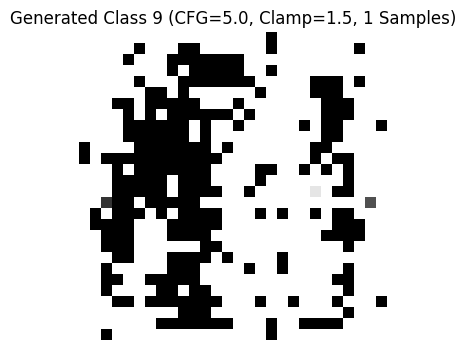


--- Testing Generation with Clamping (CFG=3.0) ---

--- generate_samples_cfg (Debug Mode) ---
Generating 1 samples of class 9 (CFG Scale: 3.0, Clamp Eps: 1.5)
Will print details for t = [98, 50, 25, 1]
--- Starting Denoising Loop for Sample 1 (Class 9) ---
  t=98: Input x | Range=[-53.370, 54.046], Mean=0.891, Std=8.359
  t=98: eps_cond   | Range=[-6.878, 6.172], Mean=-0.103, Std=1.112
  t=98: eps_uncond | Range=[-7.155, 6.339], Mean=-0.040, Std=1.156
  t=98: eps (CFG)  | Range=[-6.046, 5.671], Mean=-0.293, Std=0.994
  t=98: eps (CLAMPED)| Range=[-1.500, 1.500], Mean=-0.258, Std=0.767
  t=98: mean       | Range=[-104.478, 105.828], Mean=2.169, Std=15.733
  t=98: sqrt(beta_t)=0.8660
  t=98: Output x   | Range=[-103.390, 105.458], Mean=2.139, Std=15.702
--------------------
  t=50: Input x | Range=[-2243.024, 2292.361], Mean=51.324, Std=322.826
  t=50: eps_cond   | Range=[-7.843, 6.675], Mean=0.001, Std=1.156
  t=50: eps_uncond | Range=[-7.650, 6.603], Mean=-0.049, Std=1.139
  t=50: eps

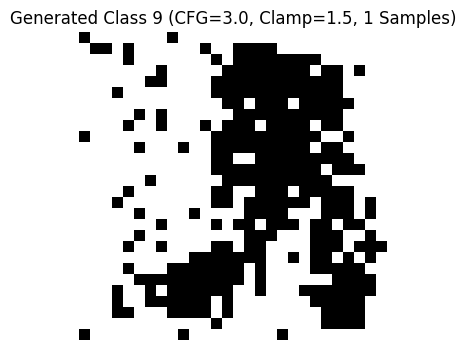


--- Testing Generation WITHOUT Clamping (CFG=5.0) ---

--- generate_samples_cfg (Debug Mode) ---
Generating 1 samples of class 9 (CFG Scale: 5.0, Clamp Eps: None)
Will print details for t = [98, 50, 25, 1]
--- Starting Denoising Loop for Sample 1 (Class 9) ---
  t=98: Input x | Range=[-18.222, 21.779], Mean=0.912, Std=8.468
  t=98: eps_cond   | Range=[-2.421, 2.309], Mean=-0.094, Std=0.937
  t=98: eps_uncond | Range=[-2.521, 2.257], Mean=-0.017, Std=0.957
  t=98: eps (CFG)  | Range=[-1.929, 2.568], Mean=-0.474, Std=1.026
  t=98: mean       | Range=[-33.564, 39.702], Mean=2.534, Std=15.637
  t=98: sqrt(beta_t)=0.8660
  t=98: Output x   | Range=[-32.364, 39.702], Mean=2.536, Std=15.576
--------------------
  t=50: Input x | Range=[-641.496, 803.818], Mean=66.825, Std=312.175
  t=50: eps_cond   | Range=[-2.481, 2.206], Mean=0.032, Std=0.963
  t=50: eps_uncond | Range=[-2.459, 2.189], Mean=0.017, Std=0.974
  t=50: eps (CFG)  | Range=[-2.590, 3.067], Mean=0.107, Std=0.980
  t=50: mean     

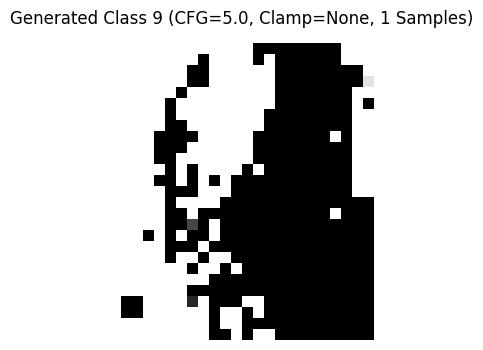

In [ ]:
print("\n--- Testing Generation with Clamping (CFG=5.0) ---")
generate_samples_cfg(model, n_samples=1, cfg_scale=5.0, target_class=9, # Class 9 (boot)
                     print_steps=[n_steps-2, n_steps//2, n_steps//4, 1], clamp_eps=1.5) # Activate prints & clamping

print("\n--- Testing Generation with Clamping (CFG=3.0) ---")
generate_samples_cfg(model, n_samples=1, cfg_scale=3.0, target_class=9,
                     print_steps=[n_steps-2, n_steps//2, n_steps//4, 1], clamp_eps=1.5)

# Maybe try without clamping to compare
print("\n--- Testing Generation WITHOUT Clamping (CFG=5.0) ---")
generate_samples_cfg(model, n_samples=1, cfg_scale=5.0, target_class=9,
                     print_steps=[n_steps-2, n_steps//2, n_steps//4, 1], clamp_eps=None) # Disable clamp


--- Experiment: CFG=5.0, NO Clamping ---

Generating 5 samples of class 9 (CFG=5.0)...


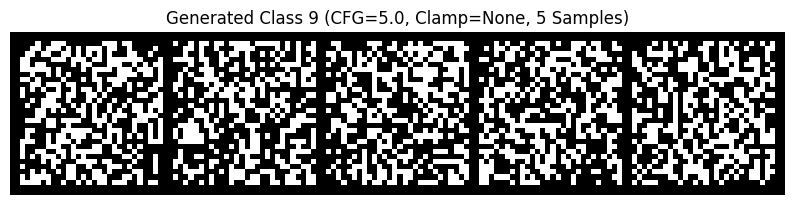


--- Experiment: CFG=5.0, WITH Clamping (eps=1.5) ---

Generating 5 samples of class 9 (CFG=5.0)...


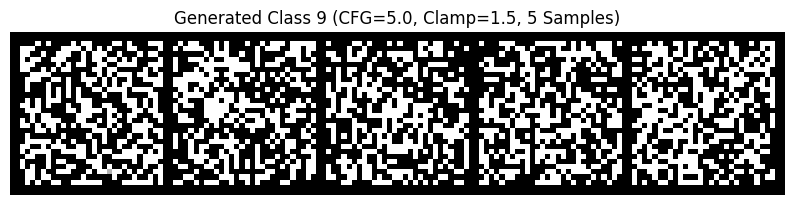


--- Experiment: CFG=7.0, WITH Clamping (eps=1.5) ---

Generating 5 samples of class 9 (CFG=7.0)...


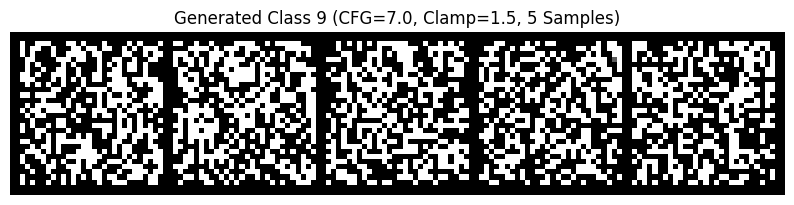


--- Experiment: CFG=3.0, WITH Clamping (eps=1.5) ---

Generating 5 samples of class 9 (CFG=3.0)...


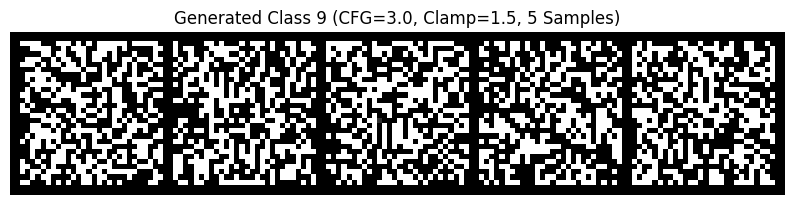


--- Experiment: CFG=7.0, NO Clamping ---

Generating 5 samples of class 9 (CFG=7.0)...


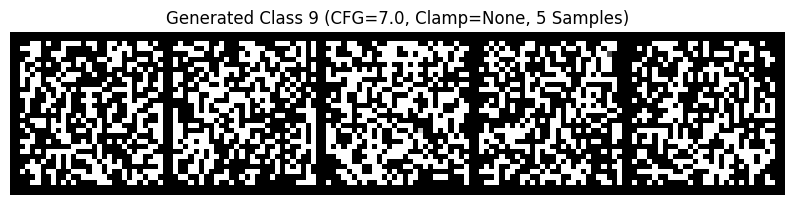

In [ ]:
# Assume 'model' is your loaded and trained model set to eval() mode
model.eval() # Make sure model is in eval mode

# --- Example Experiments (modify or add more like these) ---

target_class_to_generate = 9 # Set the digit/class you want to see
num_images_per_run = 5    # Generate a few samples each time

print(f"\n--- Experiment: CFG=5.0, NO Clamping ---")
generate_samples_cfg(model,
                     n_samples=num_images_per_run,
                     cfg_scale=5.0,
                     target_class=target_class_to_generate,
                     clamp_eps=None) # <--- clamp_eps=None means NO clamping

print(f"\n--- Experiment: CFG=5.0, WITH Clamping (eps=1.5) ---")
generate_samples_cfg(model,
                     n_samples=num_images_per_run,
                     cfg_scale=5.0,
                     target_class=target_class_to_generate,
                     clamp_eps=1.5) # <--- Clamp between -1.5 and +1.5

print(f"\n--- Experiment: CFG=7.0, WITH Clamping (eps=1.5) ---")
generate_samples_cfg(model,
                     n_samples=num_images_per_run,
                     cfg_scale=7.0,  # <--- Higher CFG
                     target_class=target_class_to_generate,
                     clamp_eps=1.5)

print(f"\n--- Experiment: CFG=3.0, WITH Clamping (eps=1.5) ---")
generate_samples_cfg(model,
                     n_samples=num_images_per_run,
                     cfg_scale=3.0,  # <--- Lower CFG
                     target_class=target_class_to_generate,
                     clamp_eps=1.5)

print(f"\n--- Experiment: CFG=7.0, NO Clamping ---")
generate_samples_cfg(model,
                     n_samples=num_images_per_run,
                     cfg_scale=7.0,  # <--- Higher CFG
                     target_class=target_class_to_generate,
                     clamp_eps=None) # <--- NO clamping

# Add more calls with different combinations as needed...
# For example, try different clamp_eps values like 1.0, 2.0, etc.
# print(f"\n--- Experiment: CFG=5.0, WITH Clamping (eps=1.0) ---")
# generate_samples_cfg(model, n_samples=num_images_per_run, cfg_scale=5.0, target_class=target_class_to_generate, clamp_eps=1.0)

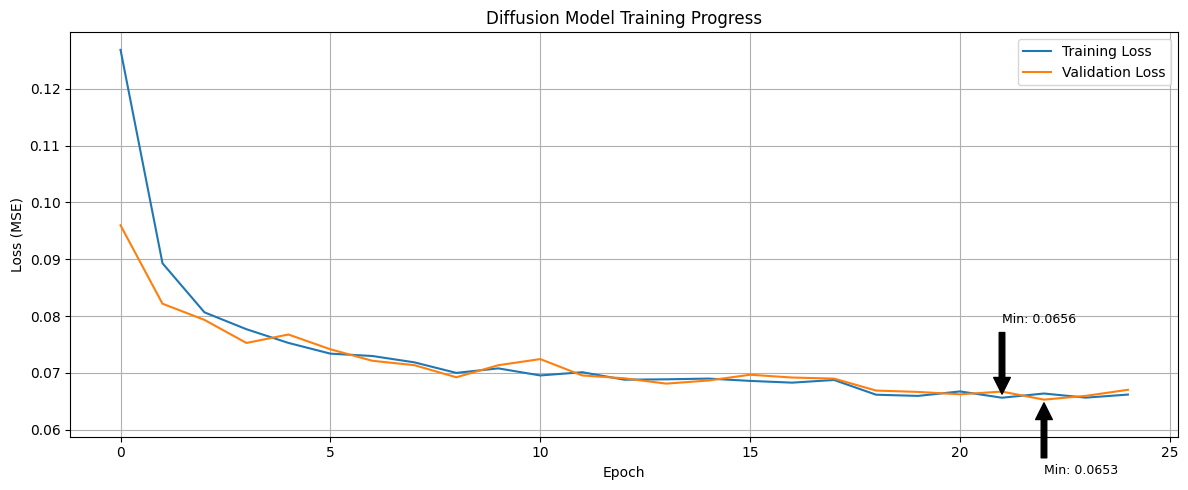


Training Statistics:
------------------------------
Starting training loss:    0.1269
Final training loss:       0.0662
Best training loss:        0.0656
Training loss improvement: 48.3%

Validation Statistics:
------------------------------
Starting validation loss: 0.0960
Final validation loss:    0.0670
Best validation loss:     0.0653


In [ ]:
# Plot training progress
plt.figure(figsize=(12, 5))

# Plot training and validation losses for comparison
plt.plot(train_losses, label='Training Loss')
if len(val_losses) > 0:  # Only plot validation if it exists
    plt.plot(val_losses, label='Validation Loss')

# Improve the plot with better labels and styling
plt.title('Diffusion Model Training Progress')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

# Add annotations for key points
if len(train_losses) > 1:
    min_train_idx = train_losses.index(min(train_losses))
    plt.annotate(f'Min: {min(train_losses):.4f}',
                 xy=(min_train_idx, min(train_losses)),
                 xytext=(min_train_idx, min(train_losses)*1.2),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 fontsize=9)

# Add validation min point if available
if len(val_losses) > 1:
    min_val_idx = val_losses.index(min(val_losses))
    plt.annotate(f'Min: {min(val_losses):.4f}',
                xy=(min_val_idx, min(val_losses)),
                xytext=(min_val_idx, min(val_losses)*0.8),
                arrowprops=dict(facecolor='black', shrink=0.05),
                fontsize=9)

# Set y-axis to start from 0 or slightly lower than min value
plt.ylim(bottom=max(0, min(min(train_losses) if train_losses else float('inf'),
                          min(val_losses) if val_losses else float('inf'))*0.9))

plt.tight_layout()
plt.show()

# Add statistics summary for students to analyze
print("\nTraining Statistics:")
print("-" * 30)
if train_losses:
    print(f"Starting training loss:    {train_losses[0]:.4f}")
    print(f"Final training loss:       {train_losses[-1]:.4f}")
    print(f"Best training loss:        {min(train_losses):.4f}")
    print(f"Training loss improvement: {((train_losses[0] - min(train_losses)) / train_losses[0] * 100):.1f}%")

if val_losses:
    print("\nValidation Statistics:")
    print("-" * 30)
    print(f"Starting validation loss: {val_losses[0]:.4f}")
    print(f"Final validation loss:    {val_losses[-1]:.4f}")
    print(f"Best validation loss:     {min(val_losses):.4f}")

# STUDENT EXERCISE:
# 1. Try modifying this plot to show a smoothed version of the losses
# 2. Create a second plot showing the ratio of validation to training loss
#    (which can indicate overfitting when the ratio increases)

## Step 6: Generating New Images

Now that our model is trained, let's generate some new images! We can:
1. Generate specific numbers
2. Generate multiple versions of each number
3. See how the generation process works step by step

In [ ]:
# Create our model and move it to GPU if available
# Define Architecture Params consistent with previous steps (e.g., Cell 20)
unet_down_chs = (64, 128, 256) # Recommended for Fashion-MNIST
unet_t_embed_dim = 256       # Recommended for Fashion-MNIST
unet_c_embed_dim = N_CLASSES # From dataset cell

print(f"--- Step 5: Instantiating Model ---")
model = UNet(
    T=n_steps,                 # Number of diffusion time steps (e.g., 200 from Cell 20)
    img_ch=IMG_CH,             # Number of channels (1 for Fashion-MNIST)
    img_size=IMG_SIZE,         # Size of input images (28 for Fashion-MNIST)
    down_chs=unet_down_chs,    # Channel dimensions for U-Net
    t_embed_dim=unet_t_embed_dim, # Dimension for time step embeddings
    c_embed_dim=unet_c_embed_dim # Number of classes for conditioning (10)
).to(device)
print(f"✓ UNet Model Instantiated on {device}")


# Set up the optimizer with parameters tuned for diffusion models
# Note: Lower learning rates tend to work better for diffusion models
initial_lr = 5e-4  # Starting learning rate (tuned slightly higher for Fashion-MNIST)
weight_decay = 1e-5  # L2 regularization
print(f"\n--- Step 5: Defining Optimizer & Scheduler ---")
optimizer = Adam(
    model.parameters(),
    lr=initial_lr,
    weight_decay=weight_decay
)
print(f"✓ Optimizer: Adam (LR={initial_lr}, Weight Decay={weight_decay})")

# Learning rate scheduler to reduce LR when validation loss plateaus
# This helps fine-tune the model toward the end of training
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',              # Reduce LR when monitored value stops decreasing
    factor=0.5,              # Multiply LR by this factor
    patience=3,              # Number of epochs with no improvement after which LR will be reduced
    verbose=True,            # Print message when LR is reduced
    min_lr=1e-6              # Lower bound on the learning rate
)
print("✓ LR Scheduler: ReduceLROnPlateau (Patience=3, Factor=0.5)")

# Training configuration constants (will be used in training loop cell)
early_stopping_patience = 10
gradient_clip_value = 1.0
display_frequency = 100       # Log loss every N steps
generate_frequency = 500      # Generate samples every N steps (mid-epoch)
epoch_generate_frequency = 5  # Generate samples every N epochs (end-of-epoch)
epoch_plot_frequency = 5      # Plot loss every N epochs
print(f"✓ Training configured: Early Stop Patience={early_stopping_patience}, Grad Clip={gradient_clip_value}")


# STUDENT EXPERIMENT: (Keep template comment)
# Try different channel configurations and see how they affect:
# 1. Model size (parameter count)
# 2. Training time
# 3. Generated image quality
#
# Suggestions:
# - Smaller: down_chs=(16, 32, 64)
# - Larger: down_chs=(64, 128, 256, 512)

--- Step 5: Instantiating Model ---
✓ Created UNet with 3 scale levels.
Channel dimensions: (64, 128, 256)
✓ UNet Model Instantiated on cuda

--- Step 5: Defining Optimizer & Scheduler ---
✓ Optimizer: Adam (LR=0.0005, Weight Decay=1e-05)
✓ LR Scheduler: ReduceLROnPlateau (Patience=3, Factor=0.5)
✓ Training configured: Early Stop Patience=10, Grad Clip=1.0


In [ ]:
# Define helper functions needed for training and evaluation
print(f"\n--- Step 5: Defining Helper Functions ---")

def validate_model_parameters(model):
    """Counts model parameters and estimates memory usage."""
    # (Code exactly as in template Cell 37)
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nModel Parameters Check:")
    print(f"  Total params: {total_params:,}, Trainable: {trainable_params:,}")
    param_memory = total_params * 4 / (1024**2); grad_memory = trainable_params * 4 / (1024**2)
    buffer_memory = param_memory * 2
    print(f"  Estimated GPU memory usage: ~{param_memory + grad_memory + buffer_memory:.1f} MB")

def verify_data_range(dataloader, name="Dataset"):
    """Verifies the range and integrity of the data."""
    # (Code exactly as in template Cell 37)
    try:
        batch = next(iter(dataloader))[0]
        print(f"\n{name} range check:")
        print(f"  Shape: {batch.shape}, Type: {batch.dtype}")
        print(f"  Min: {batch.min().item():.2f}, Max: {batch.max().item():.2f}")
        print(f"  NaNs: {torch.isnan(batch).any().item()}, Infs: {torch.isinf(batch).any().item()}")
    except StopIteration: print(f"⚠️ {name} dataloader is empty, cannot verify range.")
    except Exception as e: print(f"Could not verify data range for {name}: {e}")

# Define original generate_samples (template Cell 38) - uses remove_noise (non-CFG)
# This is needed for the template's original CLIP evaluation step later (Cell 38)
@torch.no_grad()
def generate_samples_original(model, n_samples=10): # Renamed
    """
    Generates sample images using the model for visualization during training. (NO CFG)
    """
    # (Code exactly as in template Cell 38, using remove_noise)
    model.eval()
    samples = []
    num_to_generate = min(n_samples, N_CLASSES)
    print(f"\n(Generating {num_to_generate} samples using ORIGINAL non-CFG method...)")
    for digit in range(num_to_generate):
        x = torch.randn(1, IMG_CH, IMG_SIZE, IMG_SIZE).to(device)
        c = torch.tensor([digit], dtype=torch.long).to(device)
        c_one_hot = F.one_hot(c, N_CLASSES).float().to(device)
        c_mask = torch.ones(1, dtype=torch.bool, device=device) # Boolean mask [B]
        for t in range(n_steps-1, -1, -1): # Use global n_steps
            t_batch = torch.full((1,), t, dtype=torch.long).to(device)
            x = remove_noise(x, t_batch, model, c_one_hot, c_mask) # Call original remove_noise
        samples.append(x)
    samples = torch.cat(samples, dim=0)
    samples_display = to_image(samples) # Un-normalize
    grid = make_grid(samples_display, nrow=min(n_samples, 5))
    if plt:
        plt.figure(figsize=(10, max(2, 2 * (num_to_generate // 5 + 1)) ))
        if IMG_CH == 1: plt.imshow(grid[0].cpu(), cmap='gray')
        else: plt.imshow(grid.permute(1, 2, 0).cpu())
        plt.axis('off'); plt.title('Generated Samples (Original Method - No CFG)')
        plt.show()
    model.train()
    return samples # Return samples in [-1, 1] range

# Define NEW generate_samples_cfg function for use IN THE TRAINING LOOP
@torch.no_grad()
def generate_samples_cfg(model, n_samples=10, cfg_scale=5.0):
    """Generates sample images (0-9) using the model with CFG (Fashion-MNIST)."""
    # (Code from previous responses for CFG generation)
    # print(f"Generating samples with CFG (scale={cfg_scale})...") # Less verbose
    model.eval()
    samples_list = []
    num_to_generate = min(n_samples, N_CLASSES)
    for item_class_index in range(num_to_generate):
        x = torch.randn(1, IMG_CH, IMG_SIZE, IMG_SIZE).to(device)
        c = torch.tensor([item_class_index], dtype=torch.long).to(device)
        c_one_hot = F.one_hot(c, num_classes=N_CLASSES).float()
        c_mask_cond = torch.ones(1, dtype=torch.bool, device=device)
        c_mask_uncond = torch.zeros(1, dtype=torch.bool, device=device)
        for t_val in range(n_steps - 1, -1, -1): # Use global n_steps
            t_batch = torch.full((1,), t_val, device=device, dtype=torch.long)
            eps_uncond = model(x, t_batch, c_one_hot, c_mask_uncond)
            eps_cond = model(x, t_batch, c_one_hot, c_mask_cond)
            eps = (1 + cfg_scale) * eps_cond - cfg_scale * eps_uncond # CFG calculation
            # Denoising step math
            alpha_t=alpha[t_val]; beta_t=beta[t_val]; sqrt_one_minus_alpha_bar_t=sqrt_one_minus_alpha_bar[t_val]
            alpha_t_rs=alpha_t.view(-1,1,1,1); beta_t_rs=beta_t.view(-1,1,1,1); sqrt_one_minus_alpha_bar_t_rs=sqrt_one_minus_alpha_bar_t.view(-1,1,1,1)
            mean = (1/torch.sqrt(alpha_t_rs)) * (x-(beta_t_rs/sqrt_one_minus_alpha_bar_t_rs)*eps)
            if t_val > 0: noise=torch.randn_like(x); variance=torch.sqrt(beta_t_rs); x=mean+variance*noise
            else: x=mean
        samples_list.append(x)
    samples = torch.cat(samples_list, dim=0)
    samples_display = to_image(samples) # Un-normalize
    grid = make_grid(samples_display, nrow=min(n_samples, 5))
    if plt:
      plt.figure(figsize=(10, max(2, 2 * (num_to_generate // 5 + 1)) ))
      plt.imshow(grid[0].cpu(), cmap='gray'); plt.axis('off'); plt.title(f'Generated Samples (CFG Scale: {cfg_scale})')
      plt.show()
    model.train() # Set back to train mode
    # No return needed if only used for display during training

# Define safe_save_model (from template Cell 39)
def safe_save_model(model, path, optimizer=None, epoch=None, best_loss=None):
    """Safely saves model with error handling and backup."""
    # (Code exactly as in template Cell 39)
    try:
        save_dict = {'model_state_dict': model.state_dict()}
        if optimizer is not None: save_dict['optimizer_state_dict'] = optimizer.state_dict()
        if epoch is not None: save_dict['epoch'] = epoch
        if best_loss is not None: save_dict['best_loss'] = best_loss
        if os.path.exists(path):
            backup_path = path + '.backup'
            try: os.replace(path, backup_path)
            except Exception as e: print(f"Warning: Could not create backup - {e}")
        torch.save(save_dict, path)
        print(f"✓ Model successfully saved to {path}") # Use checkmark
    except Exception as e: print(f"❌ Error saving model: {e}") # Use cross mark

# Define calculate_val_loss function (needed for validation loop)
@torch.no_grad()
def calculate_val_loss(model, x, c):
    """Calculates validation loss without CFG training strategy and no grads."""
    model.eval() # Ensure eval mode
    c_one_hot = F.one_hot(c, num_classes=N_CLASSES).float().to(device)
    c_mask_cond = torch.ones(c.shape[0], dtype=torch.bool, device=device) # Always condition
    t = torch.randint(0, n_steps, (x.shape[0],), device=device, dtype=torch.long)
    x_t, noise = add_noise(x, t)
    predicted_noise = model(x_t, t, c_one_hot, c_mask_cond) # Use conditional mask
    loss = F.mse_loss(predicted_noise, noise)
    # model.train() # Let the main loop handle setting mode back
    return loss.item() # Return scalar value

print("✓ Helper functions for validation, saving, and generation defined.")

# --- Run Validation Checks Now ---
validate_model_parameters(model)
verify_data_range(train_dataloader, name="Training Data")
verify_data_range(val_dataloader, name="Validation Data")


--- Step 5: Defining Helper Functions ---
✓ Helper functions for validation, saving, and generation defined.

Model Parameters Check:
  Total params: 6,343,169, Trainable: 6,343,169
  Estimated GPU memory usage: ~96.8 MB

Training Data range check:
  Shape: torch.Size([128, 1, 28, 28]), Type: torch.float32
  Min: -1.00, Max: 1.00
  NaNs: False, Infs: False

Validation Data range check:
  Shape: torch.Size([128, 1, 28, 28]), Type: torch.float32
  Min: -1.00, Max: 1.00
  NaNs: False, Infs: False


In [ ]:
#  Implementation of the training step function (Template Cell 40 - REVISED)
print(f"\n--- Step 5: Defining Training Step Function (with CFG) ---")
def train_step(x, c):
    """
    Performs a single training step for the diffusion model with CFG strategy.

    This function:
    1. Prepares class conditioning (one-hot)
    2. Implements CFG by randomly masking conditioning for some samples
    3. Samples random timesteps for each image
    4. Adds corresponding noise to the images (using add_noise)
    5. Asks the model to predict the noise (using the CFG mask)
    6. Calculates the loss between predicted and actual noise

    Args:
        x (torch.Tensor): Batch of clean images [B, C, H, W]
        c (torch.Tensor): Batch of class labels [B]

    Returns:
        torch.Tensor: Mean squared error loss tensor (for backpropagation)
    """
    # Convert number labels to one-hot encoding for class conditioning
    c_one_hot = F.one_hot(c, N_CLASSES).float().to(device) # Use global N_CLASSES

    # Create conditioning mask (all ones for standard training was template)
    # --- Classifier-Free Guidance Training Mask ---
    # Randomly drop conditioning for ~10% of samples
    prob_uncond = 0.1
    # c_mask_cfg is True if we condition, False if we don't (unconditional)
    c_mask_cfg = (torch.rand(c.shape[0], device=device) > prob_uncond) # Boolean mask [B]


    # Pick random timesteps for each image in the batch
    # Use global n_steps (e.g., 200 for Fashion-MNIST)
    t = torch.randint(0, n_steps, (x.shape[0],), device=device, dtype=torch.long)

    # Add noise to images according to the forward diffusion process
    # Hint: Use the add_noise function you defined earlier
    # Enter your code here:
    x_t, noise = add_noise(x, t) # add_noise defined in template Cell 21

    # The model tries to predict the exact noise that was added
    # Pass the CFG mask (c_mask_cfg) to the model's forward method
    predicted_noise = model(x_t, t, c_one_hot, c_mask_cfg) # Model uses boolean mask [B]

    # Calculate loss: how accurately did the model predict the noise?
    # MSE loss works well for image-based diffusion models
    # Hint: Use F.mse_loss to compare predicted and actual noise
    # Enter your code here:
    loss = F.mse_loss(predicted_noise, noise)

    # Return the loss tensor (backprop happens outside this function)
    return loss

print("✓ Training step function `train_step` (with CFG logic) defined.")


--- Step 5: Defining Training Step Function (with CFG) ---
✓ Training step function `train_step` (with CFG logic) defined.



STARTING Fashion-MNIST TRAINING
Epochs: 25, Batch Size: 128, Diffusion Steps: 200
Device: cuda

--- Epoch 1/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 1 Avg Loss: 0.1269
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 1 Avg Loss: 0.0960
Current LR: 0.000500
✓ New best model found! Saving to 'best_diffusion_model_fashion_mnist.pth' (Val Loss: 0.0960)
✓ Model successfully saved to best_diffusion_model_fashion_mnist.pth

--- Epoch 2/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 2 Avg Loss: 0.0893
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 2 Avg Loss: 0.0822
Current LR: 0.000500
✓ New best model found! Saving to 'best_diffusion_model_fashion_mnist.pth' (Val Loss: 0.0822)
✓ Model successfully saved to best_diffusion_model_fashion_mnist.pth

--- Epoch 3/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 3 Avg Loss: 0.0807
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 3 Avg Loss: 0.0793
Current LR: 0.000500
✓ New best model found! Saving to 'best_diffusion_model_fashion_mnist.pth' (Val Loss: 0.0793)
✓ Model successfully saved to best_diffusion_model_fashion_mnist.pth

--- Epoch 4/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 4 Avg Loss: 0.0777
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 4 Avg Loss: 0.0753
Current LR: 0.000500
✓ New best model found! Saving to 'best_diffusion_model_fashion_mnist.pth' (Val Loss: 0.0753)
✓ Model successfully saved to best_diffusion_model_fashion_mnist.pth

--- Epoch 5/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 5 Avg Loss: 0.0753
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 5 Avg Loss: 0.0768
Current LR: 0.000500
Validation loss did not improve for 1/10 epochs.

Generating samples end of epoch 5...


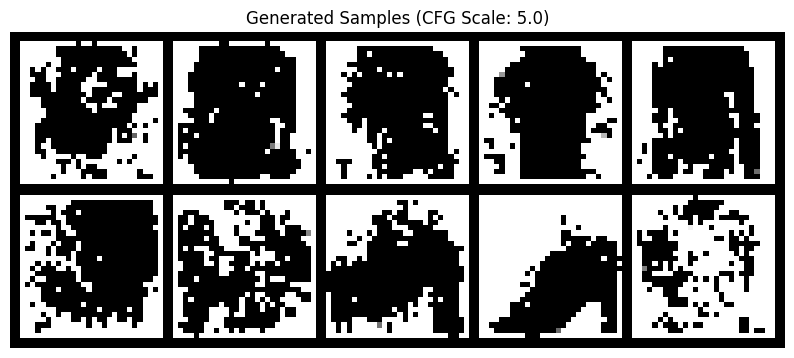

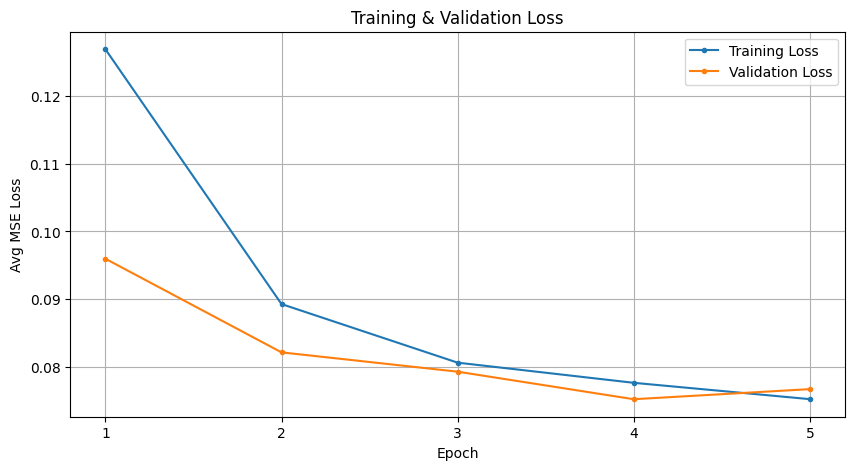


--- Epoch 6/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 6 Avg Loss: 0.0734
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 6 Avg Loss: 0.0741
Current LR: 0.000500
✓ New best model found! Saving to 'best_diffusion_model_fashion_mnist.pth' (Val Loss: 0.0741)
✓ Model successfully saved to best_diffusion_model_fashion_mnist.pth

--- Epoch 7/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 7 Avg Loss: 0.0730
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 7 Avg Loss: 0.0721
Current LR: 0.000500
✓ New best model found! Saving to 'best_diffusion_model_fashion_mnist.pth' (Val Loss: 0.0721)
✓ Model successfully saved to best_diffusion_model_fashion_mnist.pth

--- Epoch 8/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 8 Avg Loss: 0.0719
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 8 Avg Loss: 0.0714
Current LR: 0.000500
✓ New best model found! Saving to 'best_diffusion_model_fashion_mnist.pth' (Val Loss: 0.0714)
✓ Model successfully saved to best_diffusion_model_fashion_mnist.pth

--- Epoch 9/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 9 Avg Loss: 0.0700
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 9 Avg Loss: 0.0692
Current LR: 0.000500
✓ New best model found! Saving to 'best_diffusion_model_fashion_mnist.pth' (Val Loss: 0.0692)
✓ Model successfully saved to best_diffusion_model_fashion_mnist.pth

--- Epoch 10/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 10 Avg Loss: 0.0708
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 10 Avg Loss: 0.0713
Current LR: 0.000500
Validation loss did not improve for 1/10 epochs.

Generating samples end of epoch 10...


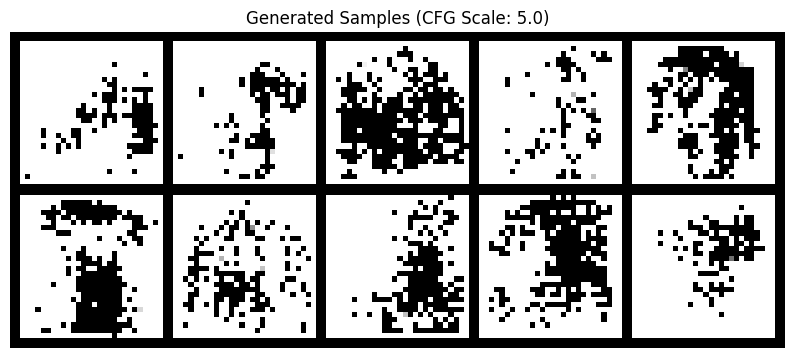

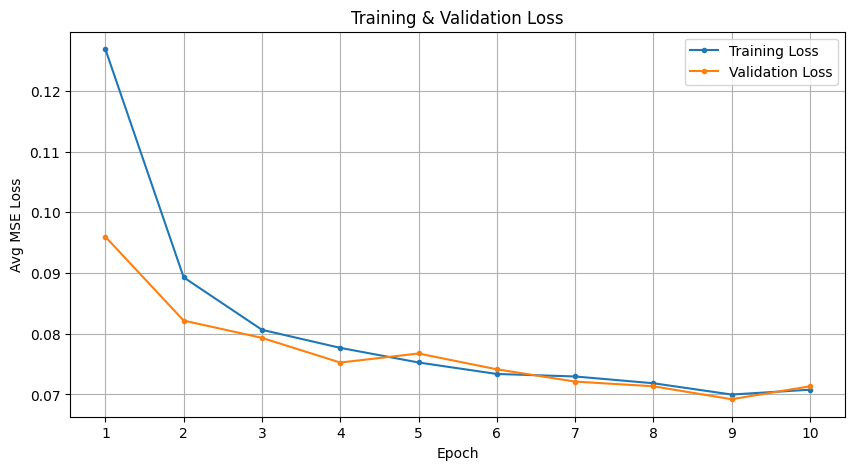


--- Epoch 11/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 11 Avg Loss: 0.0695
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 11 Avg Loss: 0.0724
Current LR: 0.000500
Validation loss did not improve for 2/10 epochs.

--- Epoch 12/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 12 Avg Loss: 0.0701
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 12 Avg Loss: 0.0695
Current LR: 0.000500
Validation loss did not improve for 3/10 epochs.

--- Epoch 13/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 13 Avg Loss: 0.0688
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 13 Avg Loss: 0.0690
Current LR: 0.000500
✓ New best model found! Saving to 'best_diffusion_model_fashion_mnist.pth' (Val Loss: 0.0690)
✓ Model successfully saved to best_diffusion_model_fashion_mnist.pth

--- Epoch 14/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 14 Avg Loss: 0.0689
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 14 Avg Loss: 0.0681
Current LR: 0.000500
✓ New best model found! Saving to 'best_diffusion_model_fashion_mnist.pth' (Val Loss: 0.0681)
✓ Model successfully saved to best_diffusion_model_fashion_mnist.pth

--- Epoch 15/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 15 Avg Loss: 0.0690
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 15 Avg Loss: 0.0686
Current LR: 0.000500
Validation loss did not improve for 1/10 epochs.

Generating samples end of epoch 15...


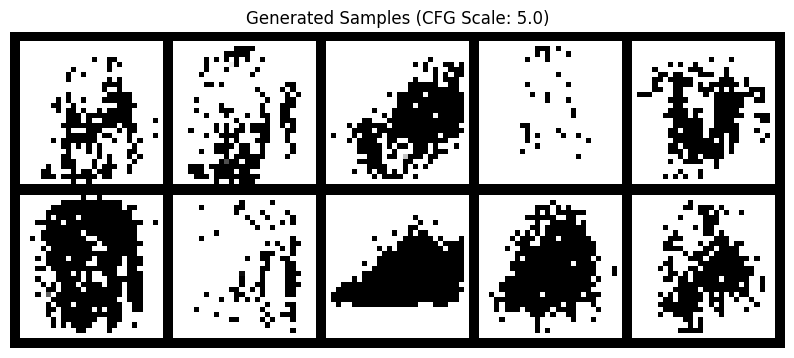

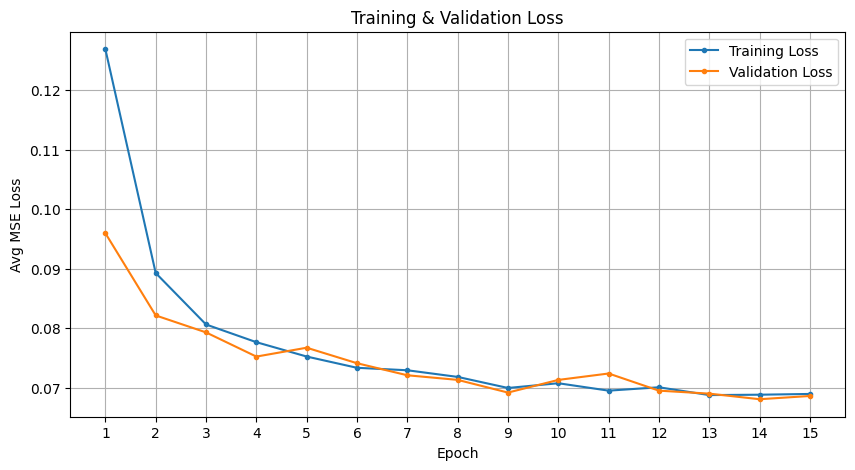


--- Epoch 16/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 16 Avg Loss: 0.0686
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 16 Avg Loss: 0.0697
Current LR: 0.000500
Validation loss did not improve for 2/10 epochs.

--- Epoch 17/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 17 Avg Loss: 0.0683
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 17 Avg Loss: 0.0692
Current LR: 0.000500
Validation loss did not improve for 3/10 epochs.

--- Epoch 18/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 18 Avg Loss: 0.0687
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 18 Avg Loss: 0.0690
Current LR: 0.000250
Validation loss did not improve for 4/10 epochs.

--- Epoch 19/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 19 Avg Loss: 0.0662
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 19 Avg Loss: 0.0669
Current LR: 0.000250
✓ New best model found! Saving to 'best_diffusion_model_fashion_mnist.pth' (Val Loss: 0.0669)
✓ Model successfully saved to best_diffusion_model_fashion_mnist.pth

--- Epoch 20/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 20 Avg Loss: 0.0659
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 20 Avg Loss: 0.0666
Current LR: 0.000250
✓ New best model found! Saving to 'best_diffusion_model_fashion_mnist.pth' (Val Loss: 0.0666)
✓ Model successfully saved to best_diffusion_model_fashion_mnist.pth

Generating samples end of epoch 20...


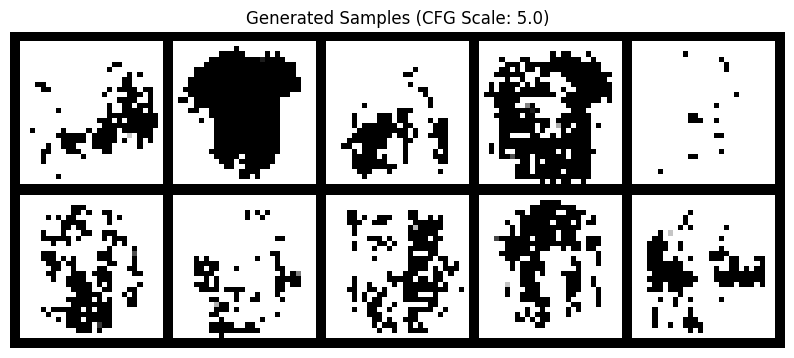

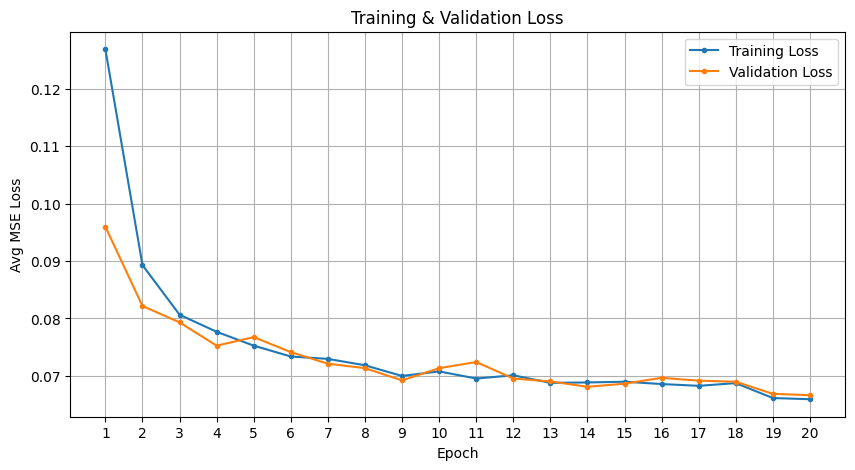


--- Epoch 21/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 21 Avg Loss: 0.0667
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 21 Avg Loss: 0.0662
Current LR: 0.000250
✓ New best model found! Saving to 'best_diffusion_model_fashion_mnist.pth' (Val Loss: 0.0662)
✓ Model successfully saved to best_diffusion_model_fashion_mnist.pth

--- Epoch 22/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 22 Avg Loss: 0.0656
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 22 Avg Loss: 0.0667
Current LR: 0.000250
Validation loss did not improve for 1/10 epochs.

--- Epoch 23/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 23 Avg Loss: 0.0664
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 23 Avg Loss: 0.0653
Current LR: 0.000250
✓ New best model found! Saving to 'best_diffusion_model_fashion_mnist.pth' (Val Loss: 0.0653)
✓ Model successfully saved to best_diffusion_model_fashion_mnist.pth

--- Epoch 24/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 24 Avg Loss: 0.0656
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 24 Avg Loss: 0.0660
Current LR: 0.000250
Validation loss did not improve for 1/10 epochs.

--- Epoch 25/25 ---


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Training Finished - Epoch 25 Avg Loss: 0.0662
Running validation...


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Finished - Epoch 25 Avg Loss: 0.0670
Current LR: 0.000250
Validation loss did not improve for 2/10 epochs.

Generating samples end of epoch 25...


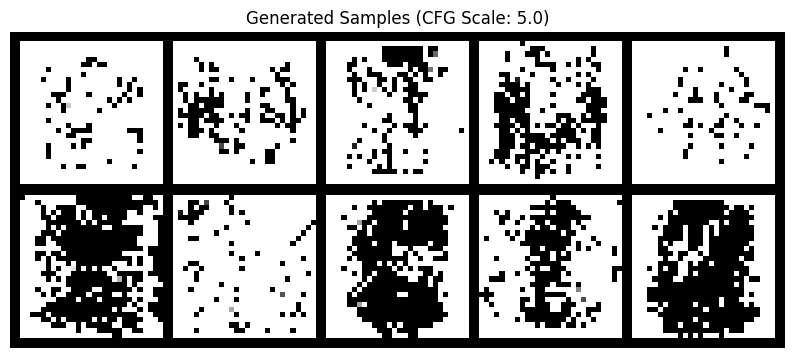

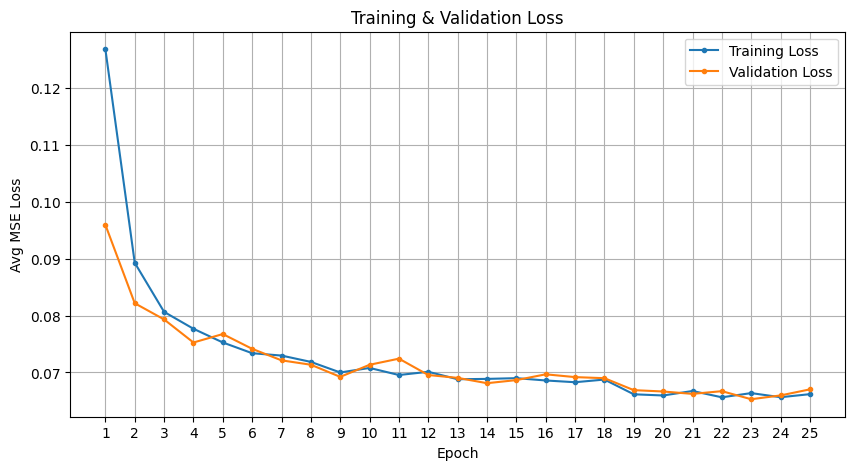


TRAINING PROCESS COMPLETE (Fashion-MNIST)
Best validation loss achieved: 0.0653

Loading best model ('best_diffusion_model_fashion_mnist.pth') for final samples...
✓ Created UNet with 3 scale levels.
Channel dimensions: (64, 128, 256)
✓ Best model loaded.


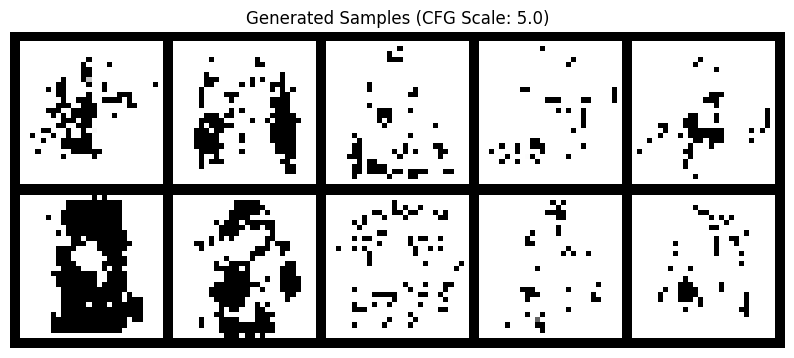


Displaying final loss curves...


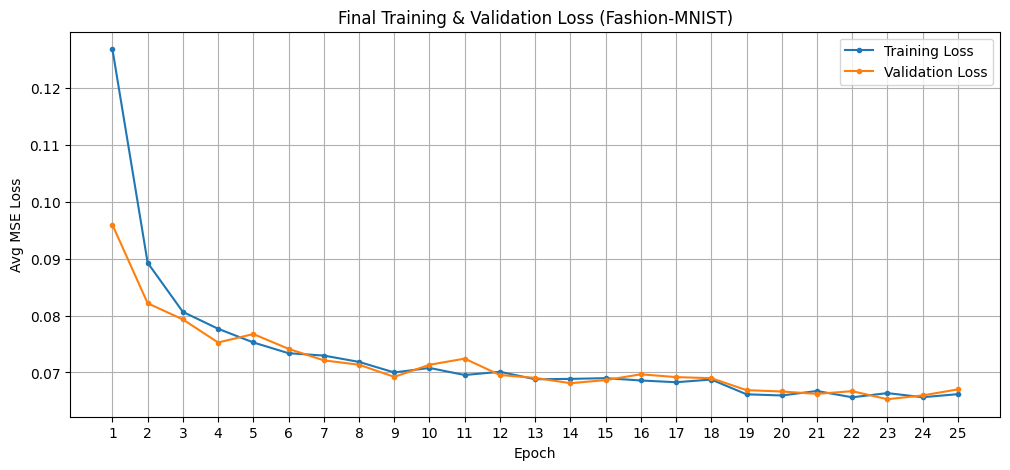


Attempting final memory cleanup...
✓ Memory cleanup attempted.


In [ ]:
# Implementation of the main training loop (Template Cell 41)

# Progress tracking variables
best_loss = float('inf')
train_losses = []
val_losses = []
no_improve_epochs = 0

# Training loop
print("\n" + "="*50)
print(f"STARTING {dataset} TRAINING")
print(f"Epochs: {EPOCHS}, Batch Size: {BATCH_SIZE}, Diffusion Steps: {n_steps}")
print(f"Device: {device}")
print("="*50)


# Wrap the training loop in a try-except block for better error handling:
# Your code for the training loop
# Hint: Use a try-except block for better error handling
# Process each epoch and each batch, with validation after each epoch

# Enter your code here:
try:
    for epoch in range(EPOCHS): # Use EPOCHS defined in dataset cell
        print(f"\n--- Epoch {epoch+1}/{EPOCHS} ---")
        # print("-" * 20) # Template comment

        # === Training phase ===
        model.train()
        epoch_train_losses = [] # Renamed from epoch_losses

        # Process each batch
        pbar_train = tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc="Training", leave=False) # Use train_dataloader
        for step, (images, labels) in pbar_train:
            images = images.to(device)
            labels = labels.to(device)

            # --- Training step ---
            optimizer.zero_grad()
            loss = train_step(images, labels) # Calls CFG train_step (returns tensor)
            loss.backward() # Backpropagate
            # Add gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clip_value)
            optimizer.step() # Update weights
            # ---------------------

            current_loss_item = loss.item()
            epoch_train_losses.append(current_loss_item)
            pbar_train.set_postfix(Loss=f"{current_loss_item:.4f}") # Update progress bar

            # Show progress at regular intervals
            # if (step + 1) % display_frequency == 0: # Less verbose default
            #    avg_recent_loss = sum(epoch_train_losses[-display_frequency:]) / max(1, len(epoch_train_losses[-display_frequency:]))
            #    print(f"  Epoch {epoch+1}, Step {step+1}/{len(train_dataloader)}, Avg Loss (last {display_frequency}): {avg_recent_loss:.4f}")

            # Generate samples less frequently to save time (mid-epoch)
            if (step + 1) % generate_frequency == 0 and step > 0:
                 try:
                     print(f"\n  Generating samples mid-epoch (step {step+1})...")
                     generate_samples_cfg(model, n_samples=10, cfg_scale=5.0) # Use CFG version defined in Cell 26
                     model.train() # Ensure back to train mode
                 except Exception as e: print(f"  Error generating mid-epoch samples: {e}"); model.train()

        # End of epoch - calculate average training loss
        avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses) if epoch_train_losses else 0
        train_losses.append(avg_train_loss)
        print(f"Training Finished - Epoch {epoch+1} Avg Loss: {avg_train_loss:.4f}")

        # === Validation phase ===
        model.eval()
        val_epoch_losses = []
        print("Running validation...")
        pbar_val = tqdm(val_dataloader, desc="Validation", leave=False) # Use val_dataloader
        with torch.no_grad():
            for val_images, val_labels in pbar_val:
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)
                # Calculate validation loss using the helper function
                val_loss = calculate_val_loss(model, val_images, val_labels) # Use helper defined in Cell 26
                val_epoch_losses.append(val_loss) # Append scalar loss
                pbar_val.set_postfix(Loss=f"{val_loss:.4f}")

        # Calculate average validation loss
        avg_val_loss = sum(val_epoch_losses) / len(val_epoch_losses) if val_epoch_losses else float('inf')
        val_losses.append(avg_val_loss)
        print(f"Validation Finished - Epoch {epoch+1} Avg Loss: {avg_val_loss:.4f}")

        # Learning rate scheduling based on validation loss
        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Current LR: {current_lr:.6f}") # Print LR each epoch

        # Save best model based on validation loss
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            # Use safe_save_model instead of just saving state_dict
            save_path = f'best_diffusion_model_{dataset.lower().replace("-","_")}.pth' # Dynamic save path
            try:
                print(f"✓ New best model found! Saving to '{save_path}' (Val Loss: {best_loss:.4f})")
                safe_save_model(model, save_path, optimizer, epoch, best_loss) # Use safe_save_model from Cell 26
            except NameError:
                 print(f"  safe_save_model not found, using basic torch.save to '{save_path}'.")
                 torch.save({'epoch': epoch,'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer.state_dict(),'best_loss': best_loss }, save_path)
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            print(f"Validation loss did not improve for {no_improve_epochs}/{early_stopping_patience} epochs.")
            # Early stopping
            if no_improve_epochs >= early_stopping_patience:
                print(f"\nEarly stopping triggered after {epoch+1} epochs.")
                break # Exit loop

        # Generate samples at the end of each epoch periodically
        if (epoch + 1) % epoch_generate_frequency == 0 or epoch == EPOCHS - 1:
            try:
                print(f"\nGenerating samples end of epoch {epoch+1}...")
                generate_samples_cfg(model, n_samples=10, cfg_scale=5.0) # Use CFG version from Cell 26
                model.train() # Back to train mode
            except Exception as e: print(f"  Error generating end-of-epoch samples: {e}"); model.train()

        # Plot loss curves every few epochs
        if plt and ((epoch + 1) % epoch_plot_frequency == 0 or epoch == EPOCHS - 1):
             try:
                 plt.figure(figsize=(10, 5))
                 plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='.')
                 plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='.')
                 plt.xlabel('Epoch'); plt.ylabel('Avg MSE Loss'); plt.title('Training & Validation Loss')
                 plt.legend(); plt.grid(True); plt.xticks(range(1, len(train_losses) + 1))
                 plt.show()
             except Exception as e: print(f"Error plotting losses: {e}")


# === End of Training Loop ===
except KeyboardInterrupt:
    print("\n--- Training interrupted by user ---")
except Exception as e:
    print(f"\n--- An error occurred during training: {e} ---")
    traceback.print_exc()

# ––– Final wrap-up ––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
print("\n" + "="*50)
print(f"TRAINING PROCESS COMPLETE ({dataset})")
print("="*50)
if val_losses: print(f"Best validation loss achieved: {best_loss:.4f}")
else: print("No validation epochs completed.")

# Generate final samples using the *best* model weights if saved
final_save_path = f'best_diffusion_model_{dataset.lower().replace("-","_")}.pth'
try:
    print(f"\nLoading best model ('{final_save_path}') for final samples...")
    checkpoint = torch.load(final_save_path, map_location=device)
    # Re-instantiate the model architecture to load the state dict into
    final_model = UNet( T=n_steps, img_ch=IMG_CH, img_size=IMG_SIZE, down_chs=unet_down_chs,
                       t_embed_dim=unet_t_embed_dim, c_embed_dim=unet_c_embed_dim ).to(device)
    final_model.load_state_dict(checkpoint['model_state_dict'])
    print("✓ Best model loaded.")
    # Use the CFG generation function for final output
    generate_samples_cfg(final_model, n_samples=10, cfg_scale=5.0)
except FileNotFoundError:
    print(f"Best model checkpoint ('{final_save_path}') not found. Generating samples from final model state.")
    generate_samples_cfg(model, n_samples=10, cfg_scale=5.0) # Generate with final model using CFG
except Exception as e:
    print(f"Could not load best model or generate final samples: {e}")
    traceback.print_exc()

# Display final loss curves
if plt and train_losses and val_losses:
    try:
        print("\nDisplaying final loss curves...")
        plt.figure(figsize=(12, 5))
        plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='.')
        plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='.')
        plt.xlabel('Epoch'); plt.ylabel('Avg MSE Loss'); plt.title(f'Final Training & Validation Loss ({dataset})')
        plt.legend(); plt.grid(True); plt.xticks(range(1, len(train_losses) + 1))
        plt.show()
    except Exception as e: print(f"Error plotting final losses: {e}")

# Clean up memory (Template wrap-up)
print("\nAttempting final memory cleanup...")
try:
    del images, labels, val_images, val_labels, loss, x_t, noise, predicted_noise
    del final_model, checkpoint
except NameError: pass
gc.collect(); torch.cuda.empty_cache()
print("✓ Memory cleanup attempted.")

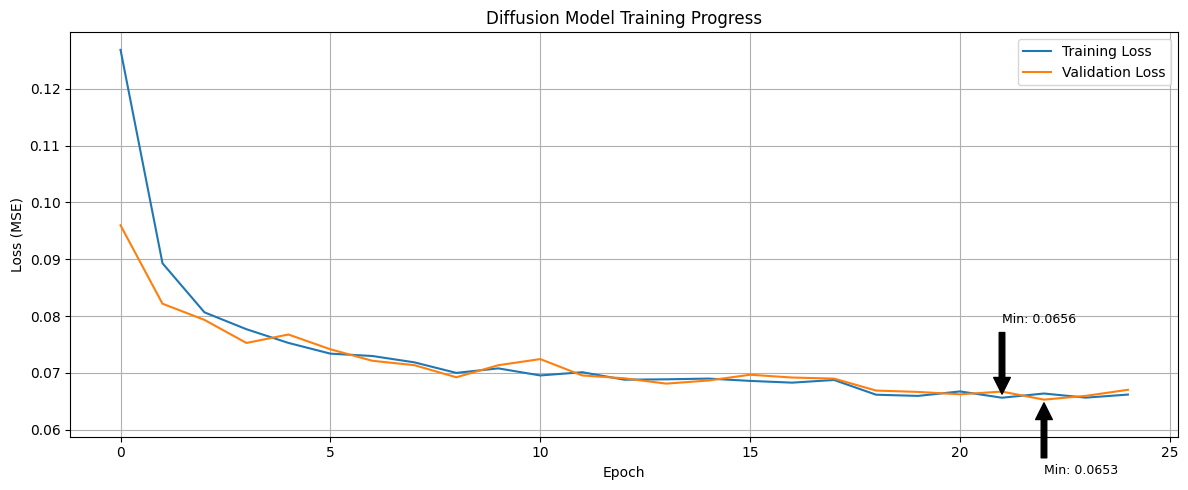


Training Statistics:
------------------------------
Starting training loss:    0.1269
Final training loss:       0.0662
Best training loss:        0.0656
Training loss improvement: 48.3%

Validation Statistics:
------------------------------
Starting validation loss: 0.0960
Final validation loss:    0.0670
Best validation loss:     0.0653


In [ ]:
# Plot training progress
plt.figure(figsize=(12, 5))

# Plot training and validation losses for comparison
plt.plot(train_losses, label='Training Loss')
if len(val_losses) > 0:  # Only plot validation if it exists
    plt.plot(val_losses, label='Validation Loss')

# Improve the plot with better labels and styling
plt.title('Diffusion Model Training Progress')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

# Add annotations for key points
if len(train_losses) > 1:
    min_train_idx = train_losses.index(min(train_losses))
    plt.annotate(f'Min: {min(train_losses):.4f}',
                 xy=(min_train_idx, min(train_losses)),
                 xytext=(min_train_idx, min(train_losses)*1.2),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 fontsize=9)

# Add validation min point if available
if len(val_losses) > 1:
    min_val_idx = val_losses.index(min(val_losses))
    plt.annotate(f'Min: {min(val_losses):.4f}',
                xy=(min_val_idx, min(val_losses)),
                xytext=(min_val_idx, min(val_losses)*0.8),
                arrowprops=dict(facecolor='black', shrink=0.05),
                fontsize=9)

# Set y-axis to start from 0 or slightly lower than min value
plt.ylim(bottom=max(0, min(min(train_losses) if train_losses else float('inf'),
                          min(val_losses) if val_losses else float('inf'))*0.9))

plt.tight_layout()
plt.show()

# Add statistics summary for students to analyze
print("\nTraining Statistics:")
print("-" * 30)
if train_losses:
    print(f"Starting training loss:    {train_losses[0]:.4f}")
    print(f"Final training loss:       {train_losses[-1]:.4f}")
    print(f"Best training loss:        {min(train_losses):.4f}")
    print(f"Training loss improvement: {((train_losses[0] - min(train_losses)) / train_losses[0] * 100):.1f}%")

if val_losses:
    print("\nValidation Statistics:")
    print("-" * 30)
    print(f"Starting validation loss: {val_losses[0]:.4f}")
    print(f"Final validation loss:    {val_losses[-1]:.4f}")
    print(f"Best validation loss:     {min(val_losses):.4f}")

# STUDENT EXERCISE:
# 1. Try modifying this plot to show a smoothed version of the losses
# 2. Create a second plot showing the ratio of validation to training loss
#    (which can indicate overfitting when the ratio increases)


Generating multiple versions of each item class using CFG...
Generating 4 versions of class 0 (CFG Scale: 5.0)...
✓ Finished class 0.
Generating 4 versions of class 1 (CFG Scale: 5.0)...
✓ Finished class 1.
Generating 4 versions of class 2 (CFG Scale: 5.0)...
✓ Finished class 2.
Generating 4 versions of class 3 (CFG Scale: 5.0)...
✓ Finished class 3.
Generating 4 versions of class 4 (CFG Scale: 5.0)...
✓ Finished class 4.
Generating 4 versions of class 5 (CFG Scale: 5.0)...
✓ Finished class 5.
Generating 4 versions of class 6 (CFG Scale: 5.0)...
✓ Finished class 6.
Generating 4 versions of class 7 (CFG Scale: 5.0)...
✓ Finished class 7.
Generating 4 versions of class 8 (CFG Scale: 5.0)...
✓ Finished class 8.
Generating 4 versions of class 9 (CFG Scale: 5.0)...
✓ Finished class 9.


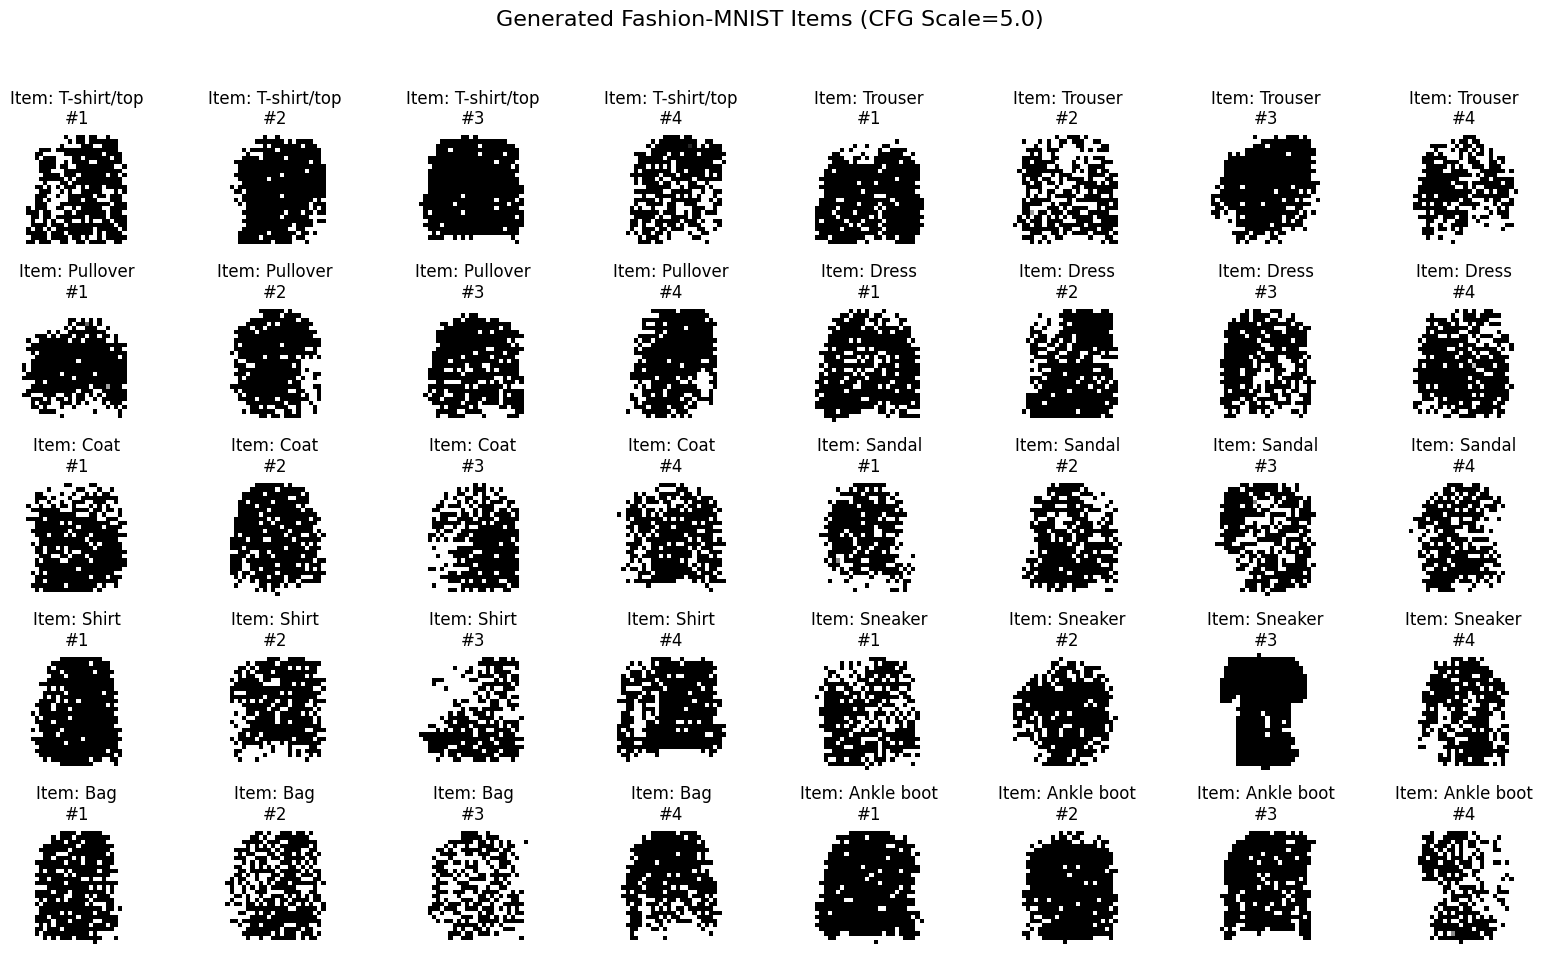


STUDENT ACTIVITY: Generating items with different noise seeds
Generating variations of Item 'Ankle boot' with different seeds...
Generating 1 versions of class 9 (CFG Scale: 5.0)...
✓ Finished class 9.
Generating 1 versions of class 9 (CFG Scale: 5.0)...
✓ Finished class 9.
Generating 1 versions of class 9 (CFG Scale: 5.0)...
✓ Finished class 9.
Generating 1 versions of class 9 (CFG Scale: 5.0)...
✓ Finished class 9.
Generating 1 versions of class 9 (CFG Scale: 5.0)...
✓ Finished class 9.


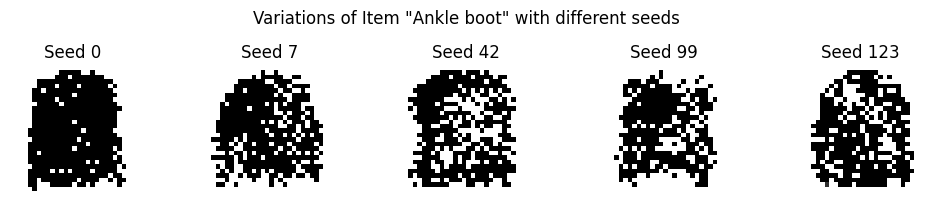

In [ ]:
# ============================================
# Step 6: Generating New Images (Revised with CFG)
# ============================================

# --- Redefine generate_number function to use CFG ---
# (Template Cell 28 definition - modified for CFG)
@torch.no_grad()
def generate_number(model, number, n_samples=4, cfg_scale=5.0): # Added cfg_scale
    """
    Generate multiple versions of a specific number/item using the diffusion model with CFG.
    (Uses CFG logic instead of remove_noise)
    """
    model.eval()  # Set model to evaluation mode
    # Start with random noise
    samples = torch.randn(n_samples, IMG_CH, IMG_SIZE, IMG_SIZE).to(device)
    # Set up the number we want to generate
    c = torch.full((n_samples,), number, dtype=torch.long).to(device) # Ensure Long
    c_one_hot = F.one_hot(c, N_CLASSES).float().to(device)
    # Conditioning masks for CFG
    c_mask_cond = torch.ones(n_samples, dtype=torch.bool, device=device)
    c_mask_uncond = torch.zeros(n_samples, dtype=torch.bool, device=device)

    # Display progress information
    print(f"Generating {n_samples} versions of class {number} (CFG Scale: {cfg_scale})...")

    # Remove noise step by step using CFG
    for t_val in range(n_steps - 1, -1, -1): # Use global n_steps
        t_batch = torch.full((n_samples,), t_val, device=device, dtype=torch.long)
        # CFG Prediction
        eps_uncond = model(samples, t_batch, c_one_hot, c_mask_uncond)
        eps_cond = model(samples, t_batch, c_one_hot, c_mask_cond)
        eps = (1 + cfg_scale) * eps_cond - cfg_scale * eps_uncond
        # Denoising Step
        alpha_t=alpha[t_val]; beta_t=beta[t_val]; sqrt_one_minus_alpha_bar_t=sqrt_one_minus_alpha_bar[t_val]
        alpha_t_rs=alpha_t.view(-1,1,1,1); beta_t_rs=beta_t.view(-1,1,1,1); sqrt_one_minus_alpha_bar_t_rs=sqrt_one_minus_alpha_bar_t.view(-1,1,1,1)
        mean = (1/torch.sqrt(alpha_t_rs)) * (samples-(beta_t_rs/sqrt_one_minus_alpha_bar_t_rs)*eps)
        if t_val > 0: noise=torch.randn_like(samples); variance=torch.sqrt(beta_t_rs); samples=mean+variance*noise
        else: samples=mean
        # Optional: Display occasional progress updates (from template)
        # if t_val > 0 and t_val % (n_steps // 5) == 0:
        #     print(f"  Denoising step {n_steps-1-t_val}/{n_steps-1} completed for class {number}")

    print(f"✓ Finished class {number}.")
    return samples # Return images in [-1, 1]

# --- Generate 4 versions of each Fashion-MNIST class ---
# Use the 'model_to_use' from the end of the training loop (loads best model if possible)
if 'model_to_use' not in locals():
     print("WARNING: 'model_to_use' not found from training loop end. Using current 'model'.")
     model_to_use = model # Fallback to current model state
model_to_use.eval() # Ensure eval mode

print("\nGenerating multiple versions of each item class using CFG...")
if plt: # Check if plotting is available
    plt.figure(figsize=(16, 10)) # Keep similar size
    n_versions = 4
    cfg_gen_scale = 5.0 # CFG scale for generation (tune if needed)

    for i in range(N_CLASSES): # Loop 0-9
        # Call the NEW CFG version of generate_number defined above
        samples = generate_number(model_to_use, i, n_samples=n_versions, cfg_scale=cfg_gen_scale)
        samples_display = to_image(samples) # Un-normalize

        # Display each sample (using template's subplot logic if desired, simplified below)
        for j in range(n_versions):
            # subplot_index = (i % 5) * 8 + (i // 5) * 4 + j + 1 # Original template complex index
            plt.subplot(5, 8, i * n_versions + j + 1) # Simpler index for 5 rows, 8 cols
            plt.imshow(samples_display[j, 0].cpu(), cmap='gray') # Display grayscale
            plt.title(f'Item: {class_names[i]}\n#{j+1}') # Use class names from Cell 8
            plt.axis('off')

    plt.suptitle(f"Generated {dataset} Items (CFG Scale={cfg_gen_scale})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else: print("Matplotlib (plt) unavailable, skipping image grid display.")


# --- STUDENT ACTIVITY: Try generating the same item with different noise seeds ---
# (Using template Cell 28 structure - `generate_with_seed` calls new `generate_number`)
print("\nSTUDENT ACTIVITY: Generating items with different noise seeds")

# Helper function to generate with seed (calls CFG generate_number)
def generate_with_seed(number, seed_value=42, n_samples=1, cfg_scale=5.0): # Renamed from template's original
    torch.manual_seed(seed_value)
    # Call the CFG generate_number defined above
    return generate_number(model_to_use, number, n_samples=n_samples, cfg_scale=cfg_scale) # Pass scale

# Pick a item class (e.g., 9 for Ankle boot)
digit_to_vary = 9 # Use 'digit' variable name from template if preferred
seed_list = [0, 7, 42, 99, 123]
print(f"Generating variations of Item '{class_names[digit_to_vary]}' with different seeds...")
if plt:
    plt.figure(figsize=(len(seed_list)*2, 2))
    for i, seed in enumerate(seed_list):
        sample = generate_with_seed(digit_to_vary, seed_value=seed, n_samples=1, cfg_scale=cfg_gen_scale)[0] # Use same scale
        sample_display = to_image(sample) # Un-normalize

        plt.subplot(1, len(seed_list), i+1)
        plt.imshow(sample_display[0].cpu(), cmap='gray') # Grayscale
        plt.title(f'Seed {seed}')
        plt.axis('off')

    plt.suptitle(f'Variations of Item "{class_names[digit_to_vary]}" with different seeds')
    plt.tight_layout(); plt.show()
else: print("Matplotlib (plt) unavailable, skipping seed variation plot.")

## Step 7: Watching the Generation Process

Let's see how our model turns random noise into clear images, step by step. This helps us understand how the diffusion process works!


Visualizing step-by-step generation using CFG...

Visualizing generation steps for Item: T-shirt/top (CFG Scale: 5.0)


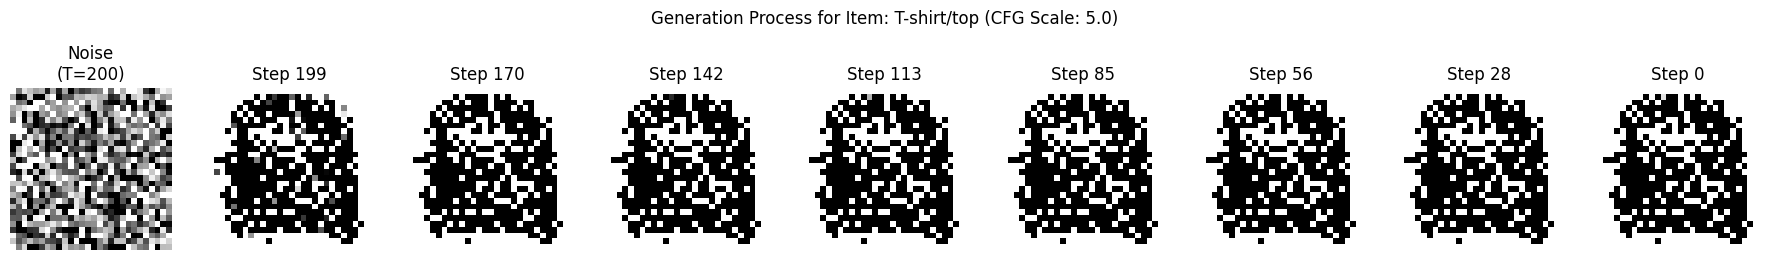


Visualizing generation steps for Item: Ankle boot (CFG Scale: 5.0)


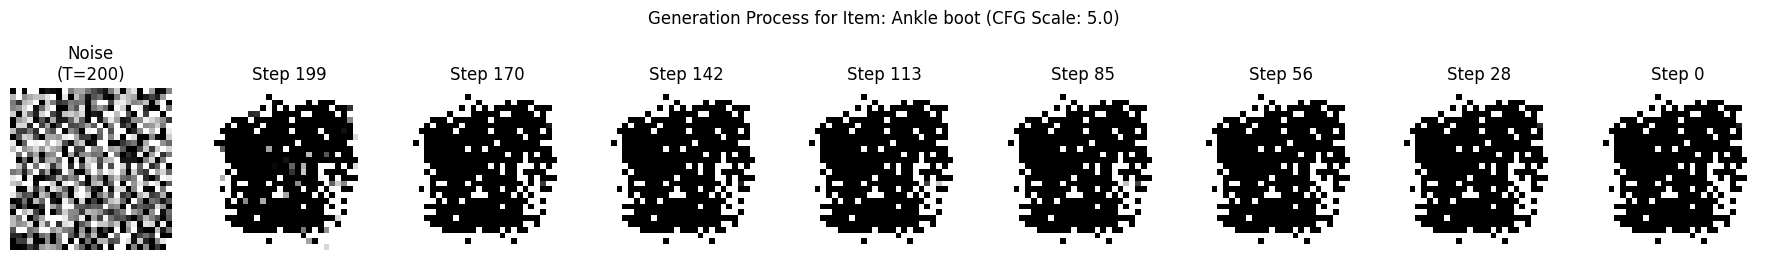


Visualizing generation steps for Item: Sneaker (CFG Scale: 5.0)


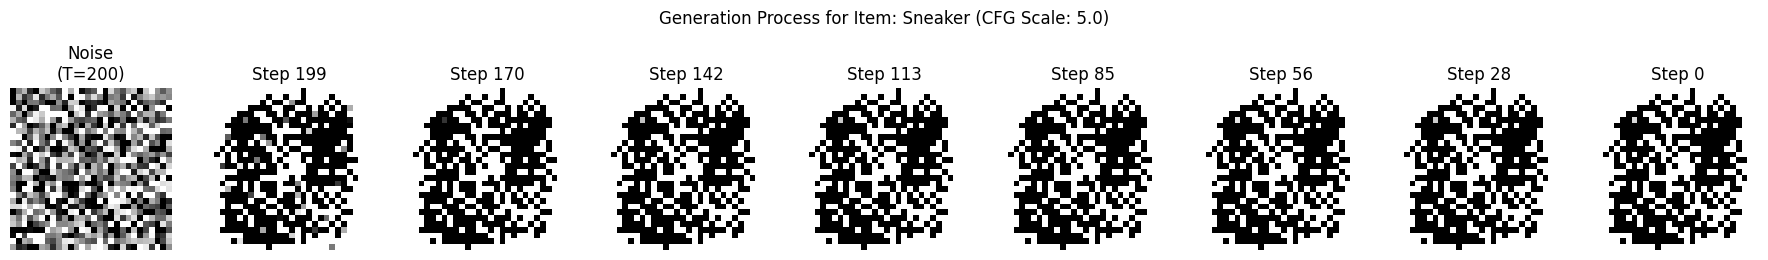

In [ ]:
# ============================================
# Step 7: Watching the Generation Process (Revised with CFG)
# ============================================

# --- Redefine visualize_generation_steps function to use CFG ---
# (Template Cell 33 definition - modified for CFG)
@torch.no_grad()
def visualize_generation_steps(model, number, n_preview_steps=10, cfg_scale=5.0): # Added cfg_scale
    """
    Show how an image evolves from noise to a clear number/item using CFG.
    """
    model.eval()
    print(f"\nVisualizing generation steps for Item: {class_names[number]} (CFG Scale: {cfg_scale})")
    x = torch.randn(1, IMG_CH, IMG_SIZE, IMG_SIZE).to(device)
    # Set up which number to generate
    c = torch.tensor([number], dtype=torch.long).to(device) # Ensure Long type
    c_one_hot = F.one_hot(c, N_CLASSES).float().to(device) # Use global N_CLASSES
    # Conditioning masks for CFG
    c_mask_cond = torch.ones(1, dtype=torch.bool, device=device)
    c_mask_uncond = torch.zeros(1, dtype=torch.bool, device=device)

    # Calculate which steps to show
    # Linspace from n_steps-1 down to 0
    steps_to_show_indices = torch.linspace(n_steps - 1, 0, n_preview_steps).long().unique()
    steps_to_show_indices = torch.sort(steps_to_show_indices, descending=True).values

    # Store images for visualization
    images = [to_image(x[0].cpu())] # Store initial noise (un-normalized)

    # Remove noise step by step using CFG
    for t_val in range(n_steps - 1, -1, -1): # Use global n_steps
        t_batch = torch.full((1,), t_val, device=device, dtype=torch.long)
        # CFG Prediction
        eps_uncond = model(x, t_batch, c_one_hot, c_mask_uncond)
        eps_cond = model(x, t_batch, c_one_hot, c_mask_cond)
        eps = (1 + cfg_scale) * eps_cond - cfg_scale * eps_uncond
        # Denoising Step
        alpha_t=alpha[t_val]; beta_t=beta[t_val]; sqrt_one_minus_alpha_bar_t=sqrt_one_minus_alpha_bar[t_val]
        alpha_t_rs=alpha_t.view(-1,1,1,1); beta_t_rs=beta_t.view(-1,1,1,1); sqrt_one_minus_alpha_bar_t_rs=sqrt_one_minus_alpha_bar_t.view(-1,1,1,1)
        mean = (1/torch.sqrt(alpha_t_rs)) * (x-(beta_t_rs/sqrt_one_minus_alpha_bar_t_rs)*eps)
        if t_val > 0: noise=torch.randn_like(x); variance=torch.sqrt(beta_t_rs); x=mean+variance*noise
        else: x=mean
        # Store image if needed
        if t_val in steps_to_show_indices: images.append(to_image(x[0].cpu())) # Store un-normalized

    # Show the progression
    if plt:
      plt.figure(figsize=(2 * len(images), 2.5))
      for i, img in enumerate(images):
          plt.subplot(1, len(images), i + 1)
          plt.imshow(img[0], cmap='gray') # Grayscale display
          # Determine step number for title
          step_title = f'Noise\n(T={n_steps})' if i == 0 else f'Step {steps_to_show_indices[i-1].item()}'
          plt.title(step_title); plt.axis('off')
      plt.suptitle(f'Generation Process for Item: {class_names[number]} (CFG Scale: {cfg_scale})', y=1.02)
      plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()
    else: print("Matplotlib unavailable, skipping visualization.")

# --- Show generation process for a few numbers (item classes) ---
# Use the 'model_to_use' from the end of the training loop/Step 6
if 'model_to_use' not in locals(): model_to_use = model # Fallback
model_to_use.eval()

item_indices_to_visualize = [0, 9, 7] # Example: T-shirt, Ankle boot, Sneaker
cfg_vis_scale = 5.0 # CFG scale for visualization

print("\nVisualizing step-by-step generation using CFG...")
for number in item_indices_to_visualize: # Use 'number' from template
    # Call the NEW CFG visualization function defined above
    visualize_generation_steps(model_to_use, number, n_preview_steps=8, cfg_scale=cfg_vis_scale) # Pass scale

## Step 8: Adding CLIP Evaluation

[CLIP](https://openai.com/research/clip) is a powerful AI model that can understand both images and text. We'll use it to:
1. Evaluate how realistic our generated images are
2. Score how well they match their intended numbers
3. Help guide the generation process towards better quality

In [ ]:
## Step 8: Adding CLIP Evaluation

# CLIP (Contrastive Language-Image Pre-training) is a powerful model by OpenAI that connects text and images.
# We'll use it to evaluate how recognizable our generated digits are by measuring how strongly
# the CLIP model associates our generated images with text descriptions like "an image of the digit 7".

# First, we need to install CLIP and its dependencies
print("Setting up CLIP (Contrastive Language-Image Pre-training) model...")

# Track installation status
clip_available = False

try:
    # Install dependencies first - these help CLIP process text and images
    print("Installing CLIP dependencies...")
    !pip install -q ftfy regex tqdm

    # Install CLIP from GitHub
    print("Installing CLIP from GitHub repository...")
    !pip install -q git+https://github.com/openai/CLIP.git

    # Import and verify CLIP is working
    print("Importing CLIP...")
    import clip

    # Test that CLIP is functioning
    models = clip.available_models()
    print(f"✓ CLIP installation successful! Available models: {models}")
    clip_available = True

except ImportError:
    print("❌ Error importing CLIP. Installation might have failed.")
    print("Try manually running: !pip install git+https://github.com/openai/CLIP.git")
    print("If you're in a Colab notebook, try restarting the runtime after installation.")

except Exception as e:
    print(f"❌ Error during CLIP setup: {e}")
    print("Some CLIP functionality may not work correctly.")

# Provide guidance based on installation result
if clip_available:
    print("\nCLIP is now available for evaluating your generated images!")
else:
    print("\nWARNING: CLIP installation failed. We'll skip the CLIP evaluation parts.")

# Import necessary libraries
import functools
import torch.nn.functional as F


 Below we are createing  a helper function to manage GPU memory when using CLIP. CLIP can be memory-intensive, so this will help prevent out-of-memory errors:

In [ ]:
# Memory management decorator to prevent GPU OOM errors
def manage_gpu_memory(func):
    """
    Decorator that ensures proper GPU memory management.

    This wraps functions that might use large amounts of GPU memory,
    making sure memory is properly freed after function execution.
    """
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        if torch.cuda.is_available():
            # Clear cache before running function
            torch.cuda.empty_cache()
            try:
                return func(*args, **kwargs)
            finally:
                # Clear cache after running function regardless of success/failure
                torch.cuda.empty_cache()
        return func(*args, **kwargs)
    return wrapper

In [ ]:
#==============================================================================
# Step 8: CLIP Model Loading and Evaluation Setup
#==============================================================================
# CLIP (Contrastive Language-Image Pre-training) is a neural network that connects
# vision and language. It was trained on 400 million image-text pairs to understand
# the relationship between images and their descriptions.
# We use it here as an "evaluation judge" to assess our generated images.

# Load CLIP model with error handling
try:
    # Load the ViT-B/32 CLIP model (Vision Transformer-based)
    clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
    print(f"✓ Successfully loaded CLIP model: {clip_model.visual.__class__.__name__}")
except Exception as e:
    print(f"❌ Failed to load CLIP model: {e}")
    clip_available = False
    # Instead of raising an error, we'll continue with degraded functionality
    print("CLIP evaluation will be skipped. Generated images will still be displayed but without quality scores.")

def evaluate_with_clip(images, target_number, max_batch_size=16):
    """
    Use CLIP to evaluate generated images by measuring how well they match textual descriptions.

    This function acts like an "automatic critic" for our generated digits by measuring:
    1. How well they match the description of a handwritten digit
    2. How clear and well-formed they appear to be
    3. Whether they appear blurry or poorly formed

    The evaluation process works by:
    - Converting our images to a format CLIP understands
    - Creating text prompts that describe the qualities we want to measure
    - Computing similarity scores between images and these text descriptions
    - Returning normalized scores (probabilities) for each quality

    Args:
        images (torch.Tensor): Batch of generated images [batch_size, channels, height, width]
        target_number (int): The specific digit (0-9) the images should represent
        max_batch_size (int): Maximum images to process at once (prevents GPU out-of-memory errors)

    Returns:
        torch.Tensor: Similarity scores tensor of shape [batch_size, 3] with scores for:
                     [good handwritten digit, clear digit, blurry digit]
                     Each row sums to 1.0 (as probabilities)
    """
    # If CLIP isn't available, return placeholder scores
    if not clip_available:
        print("⚠️ CLIP not available. Returning default scores.")
        # Equal probabilities (0.33 for each category)
        return torch.ones(len(images), 3).to(device) / 3

    try:
        # For large batches, we process in chunks to avoid memory issues
        # This is crucial when working with big images or many samples
        if len(images) > max_batch_size:
            all_similarities = []

            # Process images in manageable chunks
            for i in range(0, len(images), max_batch_size):
                print(f"Processing CLIP batch {i//max_batch_size + 1}/{(len(images)-1)//max_batch_size + 1}")
                batch = images[i:i+max_batch_size]

                # Use context managers for efficiency and memory management:
                # - torch.no_grad(): disables gradient tracking (not needed for evaluation)
                # - torch.cuda.amp.autocast(): uses mixed precision to reduce memory usage
                with torch.no_grad(), torch.cuda.amp.autocast():
                    batch_similarities = _process_clip_batch(batch, target_number)
                    all_similarities.append(batch_similarities)

                # Explicitly free GPU memory between batches
                # This helps prevent cumulative memory buildup that could cause crashes
                torch.cuda.empty_cache()

            # Combine results from all batches into a single tensor
            return torch.cat(all_similarities, dim=0)
        else:
            # For small batches, process all at once
            with torch.no_grad(), torch.cuda.amp.autocast():
                return _process_clip_batch(images, target_number)

    except Exception as e:
        # If anything goes wrong, log the error but don't crash
        print(f"❌ Error in CLIP evaluation: {e}")
        print(f"Traceback: {traceback.format_exc()}")
        # Return default scores so the rest of the notebook can continue
        return torch.ones(len(images), 3).to(device) / 3

def _process_clip_batch(images, target_number):
    """
    Core CLIP processing function that computes similarity between images and text descriptions.

    This function handles the technical details of:
    1. Preparing relevant text prompts for evaluation
    2. Preprocessing images to CLIP's required format
    3. Extracting feature embeddings from both images and text
    4. Computing similarity scores between these embeddings

    The function includes advanced error handling for GPU memory issues,
    automatically reducing batch size if out-of-memory errors occur.

    Args:
        images (torch.Tensor): Batch of images to evaluate
        target_number (int): The digit these images should represent

    Returns:
        torch.Tensor: Normalized similarity scores between images and text descriptions
    """
    try:
        # Create text descriptions (prompts) to evaluate our generated digits
        # We check three distinct qualities:
        # 1. If it looks like a handwritten example of the target digit
        # 2. If it appears clear and well-formed
        # 3. If it appears blurry or poorly formed (negative case)
        text_inputs = torch.cat([
            clip.tokenize(f"A handwritten number {target_number}"),
            clip.tokenize(f"A clear, well-written digit {target_number}"),
            clip.tokenize(f"A blurry or unclear number")
        ]).to(device)

        # Process images for CLIP, which requires specific formatting:

        # 1. Handle different channel configurations (dataset-dependent)
        if IMG_CH == 1:
            # CLIP expects RGB images, so we repeat the grayscale channel 3 times
            # For example, MNIST/Fashion-MNIST are grayscale (1-channel)
            images_rgb = images.repeat(1, 3, 1, 1)
        else:
            # For RGB datasets like CIFAR-10/CelebA, we can use as-is
            images_rgb = images

        # 2. Normalize pixel values to [0,1] range if needed
        # Different datasets may have different normalization ranges
        if images_rgb.min() < 0:  # If normalized to [-1,1] range
            images_rgb = (images_rgb + 1) / 2  # Convert to [0,1] range

        # 3. Resize images to CLIP's expected input size (224x224 pixels)
        # CLIP was trained on this specific resolution
        resized_images = F.interpolate(images_rgb, size=(224, 224),
                                      mode='bilinear', align_corners=False)

        # Extract feature embeddings from both images and text prompts
        # These are high-dimensional vectors representing the content
        image_features = clip_model.encode_image(resized_images)
        text_features = clip_model.encode_text(text_inputs)

        # Normalize feature vectors to unit length (for cosine similarity)
        # This ensures we're measuring direction, not magnitude
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # Calculate similarity scores between image and text features
        # The matrix multiplication computes all pairwise dot products at once
        # Multiplying by 100 scales to percentage-like values before applying softmax
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

        return similarity

    except RuntimeError as e:
        # Special handling for CUDA out-of-memory errors
        if "out of memory" in str(e):
            # Free GPU memory immediately
            torch.cuda.empty_cache()

            # If we're already at batch size 1, we can't reduce further
            if len(images) <= 1:
                print("❌ Out of memory even with batch size 1. Cannot process.")
                return torch.ones(len(images), 3).to(device) / 3

            # Adaptive batch size reduction - recursively try with smaller batches
            # This is an advanced technique to handle limited GPU memory gracefully
            half_size = len(images) // 2
            print(f"⚠️ Out of memory. Reducing batch size to {half_size}.")

            # Process each half separately and combine results
            # This recursive approach will keep splitting until processing succeeds
            first_half = _process_clip_batch(images[:half_size], target_number)
            second_half = _process_clip_batch(images[half_size:], target_number)

            # Combine results from both halves
            return torch.cat([first_half, second_half], dim=0)

        # For other errors, propagate upward
        raise e

#==============================================================================
# CLIP Evaluation - Generate and Analyze Sample Digits
#==============================================================================
# This section demonstrates how to use CLIP to evaluate generated digits
# We'll generate examples of all ten digits and visualize the quality scores

try:
    for number in range(10):
        print(f"\nGenerating and evaluating number {number}...")

        # Generate 4 different variations of the current digit
        samples = generate_number(model, number, n_samples=4)

        # Evaluate quality with CLIP (without tracking gradients for efficiency)
        with torch.no_grad():
            similarities = evaluate_with_clip(samples, number)

        # Create a figure to display results
        plt.figure(figsize=(15, 3))

        # Show each sample with its CLIP quality scores
        for i in range(4):
            plt.subplot(1, 4, i+1)

            # Display the image with appropriate formatting based on dataset type
            if IMG_CH == 1:  # Grayscale images (MNIST, Fashion-MNIST)
                plt.imshow(samples[i][0].cpu(), cmap='gray')
            else:  # Color images (CIFAR-10, CelebA)
                img = samples[i].permute(1, 2, 0).cpu()  # Change format for matplotlib
                if img.min() < 0:  # Handle [-1,1] normalization
                    img = (img + 1) / 2  # Convert to [0,1] range
                plt.imshow(img)

            # Extract individual quality scores for display
            # These represent how confidently CLIP associates the image with each description
            good_score = similarities[i][0].item() * 100  # Handwritten quality
            clear_score = similarities[i][1].item() * 100  # Clarity quality
            blur_score = similarities[i][2].item() * 100   # Blurriness assessment

            # Color-code the title based on highest score category:
            # - Green: if either "good handwritten" or "clear" score is highest
            # - Red: if "blurry" score is highest (poor quality)
            max_score_idx = torch.argmax(similarities[i]).item()
            title_color = 'green' if max_score_idx < 2 else 'red'

            # Show scores in the plot title
            plt.title(f'Number {number}\nGood: {good_score:.0f}%\nClear: {clear_score:.0f}%\nBlurry: {blur_score:.0f}%',
                      color=title_color)
            plt.axis('off')

        plt.tight_layout()
        plt.show()
        plt.close()  # Properly close figure to prevent memory leaks

        # Clean up GPU memory after processing each number
        # This is especially important for resource-constrained environments
        torch.cuda.empty_cache()

except Exception as e:
    # Comprehensive error handling to help students debug issues
    print(f"❌ Error in generation and evaluation loop: {e}")
    print("Detailed error information:")
    import traceback
    traceback.print_exc()

    # Clean up resources even if we encounter an error
    if torch.cuda.is_available():
        print("Clearing GPU cache...")
        torch.cuda.empty_cache()

#==============================================================================
# STUDENT ACTIVITY: Exploring CLIP Evaluation
#==============================================================================
# This section provides code templates for students to experiment with
# evaluating larger batches of generated digits using CLIP.

print("\nSTUDENT ACTIVITY:")
print("Try the code below to evaluate a larger sample of a specific digit")
print("""
# Example: Generate and evaluate 10 examples of the digit 6
# digit = 6
# samples = generate_number(model, digit, n_samples=10)
# similarities = evaluate_with_clip(samples, digit)
#
# # Calculate what percentage of samples CLIP considers "good quality"
# # (either "good handwritten" or "clear" score exceeds "blurry" score)
# good_or_clear = (similarities[:,0] + similarities[:,1] > similarities[:,2]).float().mean()
# print(f"CLIP recognized {good_or_clear.item()*100:.1f}% of the digits as good examples of {digit}")
#
# # Display a grid of samples with their quality scores
# plt.figure(figsize=(15, 8))
# for i in range(len(samples)):
#     plt.subplot(2, 5, i+1)
#     plt.imshow(samples[i][0].cpu(), cmap='gray')
#     quality = "Good" if similarities[i,0] + similarities[i,1] > similarities[i,2] else "Poor"
#     plt.title(f"Sample {i+1}: {quality}", color='green' if quality == "Good" else 'red')
#     plt.axis('off')
# plt.tight_layout()
# plt.show()
""")

## Assessment Questions

Now that you've completed the exercise, answer these questions include explanations, observations, and your analysis
Support your answers with specific examples from your experiments:

### 1. Understanding Diffusion
- Explain what happens during the forward diffusion process, using your own words and referencing the visualization examples from your notebook.

- Why do we add noise gradually instead of all at once? How does this affect the learning process?

- Look at the step-by-step visualization - at what point (approximately what percentage through the denoising process) can you first recognize the image? Does this vary by image?

### 2. Model Architecture
- Why is the U-Net architecture particularly well-suited for diffusion models? What advantages does it provide over simpler architectures?

- What are skip connections and why are they important? Explain them in relations to our model

- Describe in detail how our model is conditioned to generate specific images. How does the class conditioning mechanism work?

### 3. Training Analysis (20 points)
- What does the loss value tell of your model tell us?

- How did the quality of  your  generated images change change throughout the training process?

- Why do we need the time embedding in diffusion models? How does it help the model understand where it is in the denoising process?

### 4. CLIP Evaluation (20 points)
- What do the CLIP scores tell you about your generated images? Which  images got  the highest and lowest quality scores?

- Develop a hypothesis explaining why certain images might be easier or harder for the model to generate convincingly.

- How could CLIP scores be used to improve the diffusion model's generation process? Propose a specific technique.

### 5. Practical Applications (20 points)
- How could this type of model be useful in the real world?

- What are the limitations of our current model?

- If you were to continue developing this project, what three specific improvements would you make and why?

### Bonus Challenge (Extra 20 points)
Try one or more of these experiments:
1. If you were to continue developing this project, what three specific improvements would you make and why?

2. Modify the U-Net architecture (e.g., add more layers, increase channel dimensions) and train the model. How do these changes affect training time and generation quality?

3. CLIP-Guided Selection: Generate 10 samples of each image, use CLIP to evaluate them, and select the top 3 highest-quality examples of each. Analyze patterns in what CLIP considers "high quality."

4. tyle Conditioning: Modify the conditioning mechanism to generate multiple styles of the same digit (e.g., slanted, thick, thin). Document your approach and results.


Deliverables:
1. A PDF copy of your notebook with
    - Complete code, outputs, and generated images
    - Include all experiment results, training plots, and generated samples
    - CLIP evaluation scores of ythe images you generated
    - Answers and any interesting findings from the bonus challenges